In [239]:
from gym.spaces import Discrete, Tuple
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.ndimage.measurements import label
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
import copy
class PackEnv2(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, board_shape = (5, 5), input_shapes=[],max_moves=100, replacement=True):
        self.counter = 0
        self.max_moves = max_moves
        self.done = False
        self.reward = 0
        self.board_shape = board_shape
        self.observation_space = np.zeros((board_shape[0], board_shape[1]*2))
        self.action_space = Discrete(board_shape[0]*board_shape[1]+1)
        self.state = [np.zeros(board_shape),np.zeros(board_shape)]
        self.return_state = np.concatenate((self.state[0], self.state[1]), axis=1)
        self.replace = replacement

        self.num_possible_moves = board_shape[0]*board_shape[1]

        if len(input_shapes) == 0:
            mat = np.zeros(board_shape)
            mat[0][0] = 1
            self.shapes = [mat]
        else:
            self.shapes = []
            for shape in input_shapes:
                base_mat = np.zeros(board_shape)
                for i in range(len(shape)):
                    for j in range(len(shape[0])):
                        base_mat[i][j] = shape[i][j]
                self.shapes.append(base_mat)
        self.remaining_shapes = copy.deepcopy(self.shapes)
        val = random.choice(range(len(self.shapes)))
        self.state[1] = self.shapes[val]
        if not self.replace:
            self.remaining_shapes.pop(val)

    def reset(self):
        val = random.choice(range(len(self.shapes)))
        random_shape = self.shapes[val]
        self.counter = 0
        self.done = False
        self.reward = 0
        self.state = [np.zeros(self.board_shape), random_shape]
        self.return_state = np.concatenate((self.state[0], self.state[1]), axis=1)
        self.remaining_shapes = copy.deepcopy(self.shapes)
        if not self.replace:
            self.remaining_shapes.pop(val)
        return self.return_state


    def valid_move(self, target):
        state = self.state
        board = state[0]
        piece = state[1]
        h = self.board_shape[0]
        w = self.board_shape[1]

        #do nothing
        if target == h * w:
            return True

        if target > h*w or target < 0:
            return False

        h_offset = int(target / h)
        w_offset = target % w

        for H in range(len(piece)):
            for W in range(len(piece[0])):
                if piece[H][W] == 1:
                    if (h_offset + H >= h) or (w_offset + W  >= w):
                        return False
                    if board[H+h_offset][W+w_offset] == 1:
                        return False
        return True


    def calculate_reward(self, target, divisor=20):
        state = self.state
        board = state[0]
        h = self.board_shape[0]
        w = self.board_shape[1]
        if target == self.num_possible_moves:
            return -.5
        
        

        #connection structure
        #structure = np.ones((3, 3), dtype=np.int)
        structure = np.array([[0,1,0],[1,1,1],[0,1,0]])
        labeled, ncomponents = label(board, structure)
        component_num = labeled[int(target/h)][target % w]
        if component_num == 0:
            #invalid
            return -1
        indices = np.indices(board.shape).T[:,:,[1, 0]]
        component = indices[labeled == component_num]

        size = len(component)
        max_h = max([pair[0] for pair in component])
        min_h = min([pair[0] for pair in component])
        max_w = max([pair[1] for pair in component])
        min_w = min([pair[1] for pair in component])
        block_size = abs(max_h-min_h + 1)*abs(max_w-min_w + 1)
        return size**2/block_size/divisor

    def merge(self, target):
        state = self.state
        board = state[0]
        piece = state[1]
        h = self.board_shape[0]
        w = self.board_shape[1]

        #do nothing
        if target == h * w:
            return state[0]

        h_offset = int(target / h)
        w_offset = target % w

        for H in range(len(piece)):
            for W in range(len(piece[0])):
                if piece[H][W] == 1:
                    #print("HIIIIIII")
                    board[H+h_offset][W+w_offset] = 1
        return board

    def final_reward(self):
        h = self.board_shape[0]
        w = self.board_shape[1]
        state = self.state
        board = state[0]
        if np.sum(board) == h*w:
            return 1
        else:
            return -1
        

    def step(self, target):
        h = self.board_shape[0]
        w = self.board_shape[1]
        if self.done == True:
            self.reward = self.final_reward()
            print("It's over")
            return [self.return_state, self.reward, self.done, {}]
        elif target > self.num_possible_moves:
            print("Impossible. Invalid position")
            return [self.return_state, self.reward, self.done, {}]
        else:
            self.counter+=1
            #print("counter", self.counter)
            if (self.counter == self.max_moves):
                self.done = True
                self.reward = self.final_reward()                
                return [self.return_state, self.reward, self.done, {}]
            #self.state[0][int(target/h)][target%k] = 1
            if not self.valid_move(target):
                self.reward = -1
                return [self.return_state, self.reward, self.done, {}]

            updated_board = self.merge(target)
            self.reward = self.calculate_reward(target)
            self.state[0] = updated_board
            
            #do nothing so same state
            if (target == h*w):
                return [self.return_state, self.reward, self.done, {}]
            #no pieces left so we're done
            if len(self.remaining_shapes) == 0:
                print("hi")
                self.state[1] = np.zeros(self.board_shape)
                self.return_state = np.concatenate((self.state[0], self.state[1]), axis=1)
                self.done = True
                self.reward = self.final_reward()
                return [self.return_state, self.reward, self.done, {}]
            else:
                val = random.choice(range(len(self.remaining_shapes)))
                self.state[1] = self.remaining_shapes[val]
                if not self.replace:
                    self.remaining_shapes.pop(val)
                self.return_state = np.concatenate((self.state[0], self.state[1]), axis=1)
                return [self.return_state, self.reward, self.done, {}]


    def render(self, mode='human'):
        fig, ax = plt.subplots()
        # define the colors
        cmap = mpl.colors.ListedColormap(['w', 'k'])

        # create a normalize object the describes the limits of
        # each color
        bounds = [0., 0.5, 1.]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        # plot it
        ax.imshow(self.state[0], interpolation='none', cmap=cmap, norm=norm)
    def render_piece(self, mode='human'):
        fig, ax = plt.subplots()
        # define the colors
        cmap = mpl.colors.ListedColormap(['w', 'k'])

        # create a normalize object the describes the limits of
        # each color
        bounds = [0., 0.5, 1.]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

        # plot it
        ax.imshow(self.state[1], interpolation='none', cmap=cmap, norm=norm)

In [101]:
a = PackEnv2()

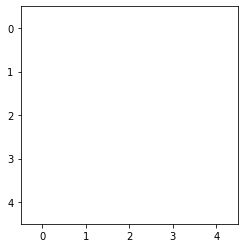

In [102]:
a.render()

In [103]:
a.step(5)

[array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), 0.01, False, {}]

In [104]:
%%capture
import gym
#import gym_pack
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import keras

from collections import deque

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.optimizers import Adam
from keras import layers, models

from rl.agents.cem import CEMAgent
from rl.memory import EpisodeParameterMemory

In [278]:
class PrupeQN:
    def __init__(self, env):
        self.env     = env
        self.memory  = deque(maxlen=10000)
        
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.01
        self.tau = .08
        self.min_tau = .02
        self.tau_decay = .999

        self.model        = self.create_model()
        self.target_model = self.create_model()
    
    #def subgrid_q()
    
    
    def grid_preprocess(self, board):
        return
    #input should be a binary array describing which action we are taking
    #along with the current state space which is made smaller by solving 
    #using subproblems and then put through several convolutional layers
    #then this is put through several fully connected layers and finally
    #output through a single node
    def create_model(self):
        input_shape = self.env.observation_space.shape + (1,)
        vals_shape = (self.env.num_possible_moves+1,)
        
        input1 = layers.Input(shape=input_shape)
        input2 = layers.Input(shape=vals_shape)
        conved1 = layers.Conv2D(32, (5, 5),padding="same",input_shape=input_shape, activation="relu")(input1)
        conved2 = layers.Conv2D(32, (5, 5),padding="same",input_shape=input_shape, activation="relu")(conved1)
        compressed = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conved2)
        x = Flatten()(compressed)
        processed = Dense(self.env.num_possible_moves+1, activation="relu")(x)

        merged = keras.layers.Concatenate(axis=1)([processed, input2])
        a = Dense(24, activation="relu")(merged)
        b = Dense(48, activation="relu")(a)
        #flat = Flatten()(b)
        output = Dense(1, activation="linear")(b)
        model = keras.models.Model(inputs=[input1, input2], output=output)
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=.01))
        print(model.summary())
        #print(model.input_shape)
        return model

    def max_q(self, state):
        new_shape = (1,) + self.env.observation_space.shape + (1,)
        input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))
        q_vals = self.target_model.predict([input_states, actions])
        return max(q_vals)
        
    
    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        
        new_shape = (1,) + self.env.observation_space.shape + (1,)
        input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))
        
        #print("input states!", input_states, input_states.shape)
        #print("Actions!", actions, actions.shape)
        
        predictions = self.model.predict([input_states, actions])
        for i in range(len(predictions)):
            if not self.env.valid_move(i):
                #predictions[i] -= 10
                pass
        #print("predictions", (predictions))
        return np.argmax(predictions)
    
    def trained_act(self, state):
        new_shape = (1,) + self.env.observation_space.shape + (1,)
        input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))


        
        
        predictions = self.model.predict([input_states, actions])
        for i in range(len(predictions)):
            if not self.env.valid_move(i):
                #predictions[i] -= 10
                pass
        #print(list(predictions))
        return np.argmax(predictions)

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size = 32
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        states = []
        outputs = []
        actions = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            
            output_prime = 0
            if done:
                output_prime = reward
            else:
                Q_future = self.max_q(new_state)
                output_prime = reward + Q_future * self.gamma
            #print("reward is", reward, "output_prime is", output_prime)
            outputs.append(output_prime)
            states.extend(state)
            actions.append([int(j == action) for j in range(self.env.num_possible_moves+1)])
        print("reward is", reward, "output_prime is", output_prime)
        states = np.array(states)
        outputs = np.array(outputs)
        actions = np.array(actions)
        self.model.fit([states,actions], outputs, epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        self.tau = max(self.min_tau, self.tau*self.tau_decay)
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save(fn)

def main():
    #env = PackEnv2(board_shape=(2,2), input_shapes=[[[1]]]*2+[[[1,1],[0,0]]], replacement=False, max_moves=4)
    env = PackEnv2(board_shape=(4,4), input_shapes=[[[1]]]*4+[[[1,1],[1,1]]]*3, replacement=False, max_moves=8)
    gamma   = 0.95
    epsilon = .99

    trials  = 5000
    trial_len = 50

    # updateTargetNetwork = 1000
    dqn_agent = PrupeQN(env=env)
    steps = []
    for trial in range(trials):
        cur_state = env.reset()
        state_shape = (1,) + env.observation_space.shape + (1,)
        cur_state = cur_state.reshape(state_shape)
        for step in range(trial_len):
            action = dqn_agent.act(cur_state)
            new_state, reward, done, _ = env.step(action)
            #print("info", new_state, reward, done)

            #reward = reward/abs(reward) if not done else -.01
            #reward = -.01 if not done else reward/abs(reward)
            #print("reward is ")
            new_state = new_state.reshape(state_shape)
            dqn_agent.remember(cur_state, action, reward, new_state, done)
            
            dqn_agent.replay()       # internally iterates default (prediction) model
            dqn_agent.target_train() # iterates target model

            cur_state = new_state
            if done:
                break
        print("trial #{}".format(trial))
    return env, dqn_agent

In [282]:
env, agent, accuracies1 = main()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Model: "model_67"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_135 (InputLayer)          (None, 4, 8, 1)      0                                            
__________________________________________________________________________________________________
conv2d_129 (Conv2D)             (None, 4, 8, 32)     832         input_135[0][0]                  
__________________________________________________________________________________________________
conv2d_130 (Conv2D)             (None, 4, 8, 32)     25632       conv2d_129[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_65 (MaxPooling2D) (None, 2, 4, 32)     0           conv2d_130[0][0]                 
___________________________________________________________________________________________

reward is -1 output_prime is [-1.557068]
reward is -1 output_prime is [-1.4036939]
reward is -1 output_prime is [-1.3684496]
trial #11
reward is 0.27222222222222225 output_prime is [-0.1802882]
reward is -1 output_prime is [-0.8549662]
reward is -1 output_prime is [-1.5116932]
reward is -1 output_prime is [-1.602987]
reward is -0.5 output_prime is [-0.2444689]
reward is 0.2 output_prime is [0.28426084]
reward is -1 output_prime is [-1.7521592]
reward is 0.20833333333333334 output_prime is [-0.11192779]
trial #12
reward is -1 output_prime is [-1.3468823]
reward is 0.2 output_prime is [0.32162106]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [0.32276675]
reward is -0.5 output_prime is [-0.29963982]
reward is -1 output_prime is -1
reward is -1 output_prime is [-0.93898493]
reward is -1 output_prime is -1
trial #13
reward is 0.225 output_prime is [-0.05819982]
reward is -1 output_prime is [-0.86095643]
reward is -1 output_prime is [-1.2876128]
reward is 0.1 output_prime i

reward is -1 output_prime is [-1.54049]
reward is -1 output_prime is [-1.7096368]
trial #34
reward is -0.5 output_prime is [-0.40979955]
reward is -1 output_prime is [-0.906345]
reward is -0.5 output_prime is [-1.3570027]
reward is 0.1 output_prime is [-0.12736914]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.41635823]
reward is 0.05 output_prime is [-0.8721849]
trial #35
reward is -1 output_prime is [-2.2417712]
reward is 0.2 output_prime is [0.19447233]
reward is 0.225 output_prime is [-0.35656843]
reward is -1 output_prime is [-0.82910776]
reward is -1 output_prime is [-1.5269105]
reward is -1 output_prime is [-1.8444085]
reward is 0.05 output_prime is [-0.44495976]
reward is -1 output_prime is [-1.9095099]
trial #36
reward is -1 output_prime is [-0.974872]
reward is 0.20833333333333334 output_prime is [-0.3423016]
reward is -0.5 output_prime is [-0.3141039]
reward is -1 output_prime is -1
reward is 0.3 output_prime is [0.17313544

reward is -1 output_prime is [-1.6934948]
reward is 0.4166666666666667 output_prime is [0.25978592]
reward is 0.2 output_prime is [-0.19041304]
reward is 0.2 output_prime is [0.21159527]
reward is -1 output_prime is [-1.5435127]
trial #58
reward is 0.2 output_prime is [0.27790827]
reward is 0.05 output_prime is [0.10270861]
reward is -1 output_prime is [-0.9918719]
reward is 0.05 output_prime is [0.12294328]
reward is 0.05 output_prime is [0.19263227]
reward is 0.1 output_prime is [-1.0263387]
reward is 0.05 output_prime is [-0.32942012]
reward is 0.05 output_prime is [-0.6431276]
trial #59
reward is 0.1 output_prime is [-0.7678554]
reward is -1 output_prime is [-0.5991769]
reward is -1 output_prime is [-1.7369361]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.28270924]
reward is -1 output_prime is [-1.1430179]
reward is 0.4166666666666667 output_prime is [-0.23595747]
reward is 0.05 output_prime is [-0.9677935]
trial #60
reward is 0.20833333333333334 output_prime 

reward is -1 output_prime is [-2.049708]
reward is 0.2 output_prime is [-0.03730348]
reward is -1 output_prime is [-2.2986681]
reward is -1 output_prime is [-1.1160392]
reward is 0.05 output_prime is [-0.26309705]
reward is 0.05 output_prime is [-0.22959141]
reward is -1 output_prime is [-1.721536]
reward is -1 output_prime is [-1.6765287]
trial #81
reward is -1 output_prime is [-2.1092005]
reward is 0.05 output_prime is [-0.18980198]
reward is 0.20833333333333334 output_prime is [-0.65183777]
reward is 0.4 output_prime is [0.21527961]
reward is 0.225 output_prime is [-0.8610033]
reward is 0.20833333333333334 output_prime is [-0.17954238]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
trial #82
reward is 0.20833333333333334 output_prime is [-1.7100899]
reward is 0.5041666666666667 output_prime is [-0.03329504]
reward is 0.05 output_prime is [-0.08724234]
reward is -1 output_prime is [-1.4544371]
reward is -1 output_prime is [-1.4724509]
reward is -1 output_prime is [-2

reward is 0.4166666666666667 output_prime is [-0.9377657]
reward is 0.05 output_prime is [0.06439447]
reward is 0.20833333333333334 output_prime is [-0.04872246]
reward is -1 output_prime is [-1.3699284]
reward is 0.05 output_prime is [-0.4109343]
trial #102
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [0.02813682]
reward is -1 output_prime is [-1.8909227]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.2032536]
reward is -1 output_prime is [-1.6569524]
reward is 0.05 output_prime is [-0.82419276]
reward is -1 output_prime is [-1.1736531]
trial #103
reward is -1 output_prime is [-1.5723557]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.45227414]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.06011946]
reward is -1 output_prime is [-1.5428154]
reward is 0.20833333333333334 output_prime is [0.04976091]
reward is 0.05 output_prime is [-0.84614366]
trial #104
reward is 0.4166666666666667 output_prime

reward is 0.05 output_prime is [-0.28769505]
reward is 0.05 output_prime is [-0.29359883]
reward is 0.26666666666666666 output_prime is [-1.0693668]
reward is 0.05 output_prime is [-0.19383913]
trial #125
reward is 0.2 output_prime is [-0.04322809]
reward is -1 output_prime is [-2.2192168]
reward is 0.05 output_prime is [-0.98280364]
reward is 0.26666666666666666 output_prime is [-0.7454454]
reward is 0.05 output_prime is [-0.21124513]
reward is 0.3375 output_prime is [-0.80015254]
reward is -1 output_prime is [-2.2134001]
reward is -1 output_prime is [-1.3957787]
trial #126
reward is 0.05 output_prime is [-0.787091]
reward is -1 output_prime is [-2.3737576]
reward is -1 output_prime is [-1.8360312]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.652852]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.05003382]
reward is -0.5 output_prime is [-0.58872837]
trial #127
reward is 0.20833333333333334 output_prime is [-0.02447267]
reward is 0.2 output_prime

trial #148
reward is -1 output_prime is [-1.1718632]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.6517467]
reward is 0.2 output_prime is [-0.20444022]
reward is -1 output_prime is [-1.8309083]
reward is -1 output_prime is [-1.2164825]
reward is -1 output_prime is [-1.0266743]
trial #149
reward is 0.378125 output_prime is [-0.47652006]
reward is 0.05 output_prime is [-0.8236789]
reward is 0.2 output_prime is [-0.58206165]
reward is -1 output_prime is [-1.4777513]
reward is -1 output_prime is [-1.5408553]
reward is 0.4 output_prime is [-1.2357004]
reward is 0.05 output_prime is [-0.45812118]
reward is -1 output_prime is [-1.5300763]
trial #150
reward is 0.253125 output_prime is [-0.1508013]
reward is -1 output_prime is [-2.2477155]
reward is 0.4166666666666667 output_prime is [-0.05169445]
reward is 0.1125 output_prime is [-0.9423855]
reward is -1 output_prime is [-1.685471]
reward is -1 output_prime is [-2.1626225]
reward is 0.20833333

reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.53843856]
reward is -1 output_prime is [-2.571715]
reward is 0.05 output_prime is [-0.49894238]
reward is 0.20833333333333334 output_prime is [-0.20673777]
trial #172
reward is 0.05 output_prime is [-0.22163524]
reward is 0.4 output_prime is [-0.81022274]
reward is -1 output_prime is [-1.8725561]
reward is 0.05 output_prime is [-1.0130788]
reward is -1 output_prime is [-1.0839192]
reward is -1 output_prime is [-2.1507132]
reward is 0.05 output_prime is [-0.6295255]
reward is 0.20833333333333334 output_prime is [-0.15356289]
trial #173
reward is -1 output_prime is [-2.0878959]
reward is 0.05 output_prime is [-0.32569408]
reward is -1 output_prime is [-1.4625412]
reward is -1 output_prime is [-1.2777694]
reward is -1 output_prime is [-1.7006476]
reward is 0.05 output_prime is [-0.46168762]
reward is 0.2 output_prime is [-0.16701446]
reward is -1 output_prime is -1
trial #174
reward is 0.4 output_prime is [-0.5495038]
rewar

reward is -1 output_prime is -1
reward is -1 output_prime is [-1.3454319]
trial #195
reward is -1 output_prime is [-2.249623]
reward is 0.3 output_prime is [-0.07773581]
reward is 0.2 output_prime is [-0.1353452]
reward is 0.05 output_prime is [-0.17205119]
reward is 0.05 output_prime is [-0.5392943]
reward is -1 output_prime is [-2.1296086]
reward is -1 output_prime is [-1.2986706]
reward is 0.26666666666666666 output_prime is [-0.16614583]
trial #196
reward is -1 output_prime is [-1.8003174]
reward is 0.4 output_prime is [-0.03479117]
reward is -1 output_prime is [-1.2027074]
reward is 0.05 output_prime is [-0.7879975]
reward is -1 output_prime is [-1.4267086]
reward is 0.05 output_prime is [-0.39054447]
reward is -1 output_prime is [-1.2891737]
reward is -1 output_prime is [-2.4320338]
trial #197
reward is 0.05 output_prime is [-0.75680983]
reward is 0.26666666666666666 output_prime is [-0.7787497]
reward is 0.05 output_prime is [-0.03887447]
reward is 0.05 output_prime is [-0.22289

trial #216
reward is -1 output_prime is [-1.0752357]
reward is 0.05 output_prime is [-0.49261725]
reward is 0.05 output_prime is [-0.26540697]
reward is -1 output_prime is [-1.8139906]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.48540854]
reward is 0.2 output_prime is [-0.3360604]
reward is -1 output_prime is [-1.7215703]
trial #217
reward is 0.05 output_prime is [-0.1280761]
reward is 0.2 output_prime is [-0.09537838]
reward is -1 output_prime is [-1.5304418]
reward is 0.4 output_prime is [-0.77141416]
reward is 0.1 output_prime is [-1.1968966]
reward is -1 output_prime is [-1.0922133]
reward is 0.20833333333333334 output_prime is [-0.15042208]
reward is 0.26666666666666666 output_prime is [-0.04958463]
trial #218
reward is -1 output_prime is [-2.6533175]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.452173]
reward is 0.05 output_prime is [-0.7868371]
reward is 0.2 output_prime is [-0.10742868]
reward is -1 output_prime is [-1.7108557]
reward 

reward is -0.5 output_prime is [-1.561307]
trial #239
reward is -1 output_prime is [-2.1759756]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.34547538]
reward is 0.2 output_prime is [-1.2913156]
reward is 0.05 output_prime is [-0.55658036]
reward is 0.20833333333333334 output_prime is [-0.42850435]
reward is 0.26666666666666666 output_prime is [-0.11454296]
reward is 0.225 output_prime is [-0.89936197]
trial #240
reward is -1 output_prime is [-2.3483977]
reward is -1 output_prime is [-2.4372]
reward is -1 output_prime is [-2.2152553]
reward is 0.4 output_prime is [0.00014722]
reward is 0.1 output_prime is [-0.27782956]
reward is -1 output_prime is [-2.4321387]
reward is 0.2 output_prime is [-0.5747199]
reward is 0.253125 output_prime is [-1.2105305]
trial #241
reward is 0.3375 output_prime is [-1.0226345]
reward is 0.4166666666666667 output_prime is [-0.16261706]
reward is 0.05 output_prime is [-1.1023705]
reward is 0.2 output_prime is [-0.10651104]
reward is 0.208

reward is -1 output_prime is [-1.7843223]
reward is -1 output_prime is [-2.2224326]
trial #262
reward is 0.3375 output_prime is [-0.20814767]
reward is -1 output_prime is [-1.5030072]
reward is -1 output_prime is [-1.3706217]
reward is -1 output_prime is [-2.330934]
reward is -1 output_prime is [-1.9137633]
reward is -1 output_prime is [-2.3386424]
reward is -1 output_prime is [-2.7265494]
reward is -1 output_prime is -1
trial #263
reward is 0.2 output_prime is [-0.44577575]
reward is -1 output_prime is [-2.5593626]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.17114699]
reward is -1 output_prime is [-1.3976548]
reward is -1 output_prime is [-1.580554]
reward is 0.3125 output_prime is [-0.45562977]
reward is 0.05 output_prime is [-0.848492]
trial #264
reward is -1 output_prime is [-1.4940317]
reward is 0.4166666666666667 output_prime is [-1.3793787]
reward is 0.05 output_prime is [-0.44063976]
reward is -1 output_prime is [-2.8193426]
reward is -1 output_prime is [

reward is -1 output_prime is [-1.7733784]
reward is 0.05 output_prime is [-0.64958113]
reward is 0.05 output_prime is [-0.52369523]
reward is 0.05 output_prime is [-0.69192785]
reward is 0.05 output_prime is [-0.44973052]
reward is 0.1 output_prime is [-0.8334123]
trial #286
reward is -1 output_prime is [-3.577119]
reward is -1 output_prime is [-1.8334761]
reward is 0.528125 output_prime is [-0.22177684]
reward is -0.5 output_prime is [-1.1967776]
reward is 0.05 output_prime is [-0.54731095]
reward is -1 output_prime is [-1.7281272]
reward is -1 output_prime is [-2.6848001]
reward is 0.20833333333333334 output_prime is [-0.6766474]
trial #287
reward is -1 output_prime is [-3.1324337]
reward is 0.05 output_prime is [-0.9399613]
reward is 0.2 output_prime is [-0.49769878]
reward is -1 output_prime is [-2.0369322]
reward is -1 output_prime is [-1.8884535]
reward is -1 output_prime is [-2.79538]
reward is -1 output_prime is [-2.212201]
reward is 0.253125 output_prime is [-0.5126041]
trial 

reward is 0.2 output_prime is [-0.1572897]
reward is 0.20416666666666666 output_prime is [-0.7395396]
reward is -1 output_prime is [-1.860161]
reward is -1 output_prime is [-1.8405497]
reward is -1 output_prime is [-2.0258653]
reward is -1 output_prime is -1
trial #307
reward is 0.45 output_prime is [-0.6745282]
reward is 0.05 output_prime is [-0.46817708]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.8823992]
reward is 0.1 output_prime is [-1.3540028]
reward is 0.225 output_prime is [-0.6608814]
trial #308
reward is 0.2 output_prime is [-0.39662325]
reward is 0.05 output_prime is [-0.48169786]
reward is -1 output_prime is [-2.0597744]
reward is 0.05 output_prime is [-0.7315314]
reward is 0.05 output_prime is [-0.3190727]
reward is -1 output_prime is [-3.3058906]
reward is -1 output_prime is [-1.5507154]
reward is -1 output_prime is -1
trial #309
reward is 0.05 output_prime is [-0.550047]
reward is 0.2

reward is -1 output_prime is [-1.7608886]
reward is 0.05 output_prime is [-0.6191758]
reward is -1 output_prime is [-1.5500319]
reward is 0.225 output_prime is [-0.53005207]
reward is 0.05 output_prime is [-0.54247665]
reward is 0.05 output_prime is [-1.4928092]
trial #330
reward is -1 output_prime is [-2.264174]
reward is -1 output_prime is [-2.0799787]
reward is 0.6125 output_prime is [-0.3218736]
reward is 0.1 output_prime is [-0.57137233]
reward is -0.5 output_prime is [-1.8134028]
reward is -1 output_prime is [-1.3116825]
reward is -1 output_prime is [-1.961691]
reward is 0.4 output_prime is [-0.9182986]
trial #331
reward is 0.2 output_prime is [-0.31111503]
reward is -1 output_prime is [-1.5024726]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.6499183]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.9675193]
reward is 0.3375 output_prime is [-0.5063858]
reward is 0.2 output_prime is [-0.57911307]
trial #332
reward is 0.05 output_prime is [-0.55

reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [-0.59020036]
reward is -1 output_prime is [-1.9843059]
reward is -1 output_prime is [-1.5060159]
reward is 0.2 output_prime is [-0.12032355]
reward is -1 output_prime is [-1.6556495]
trial #353
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.72099835]
reward is 0.05 output_prime is [-0.53307486]
reward is -1 output_prime is [-1.9279623]
reward is 0.378125 output_prime is [-0.8420531]
reward is 0.20833333333333334 output_prime is [-1.2840288]
reward is 0.3125 output_prime is [-0.768911]
reward is -1 output_prime is -1
trial #354
reward is 0.45 output_prime is [-0.76656264]
reward is 0.2 output_prime is [-0.561376]
reward is -1 output_prime is [-1.6301377]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.8353642]
reward is 0.4166666666666667 output_prime is [-1.0205727]
reward is -1 output_prime is [-2.4528155]
trial #355
reward is -1 output_p

reward is 0.2 output_prime is [-0.00640674]
reward is 0.20833333333333334 output_prime is [-0.53757656]
reward is 0.3375 output_prime is [-0.39046875]
reward is 0.05 output_prime is [-0.5855681]
reward is 0.20833333333333334 output_prime is [-0.68619204]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
trial #376
reward is -1 output_prime is [-1.7476791]
reward is -1 output_prime is [-2.5240846]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.5620225]
reward is 0.05 output_prime is [-0.43418118]
reward is -1 output_prime is [-3.6090488]
reward is 0.2 output_prime is [-0.36913466]
reward is -1 output_prime is [-2.1955209]
trial #377
reward is 0.05 output_prime is [-1.4828457]
reward is -1 output_prime is [-1.5314252]
reward is 0.378125 output_prime is [-0.9822468]
reward is -1 output_prime is [-1.8382089]
reward is -1 output_prime is [-2.343365]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.2867482]
reward is -1 output_prime is -1
t

reward is -1 output_prime is -1
reward is -1 output_prime is [-2.3564131]
reward is 0.2 output_prime is [-0.5297074]
reward is -0.5 output_prime is [-1.194082]
reward is 0.05 output_prime is [-0.96211785]
reward is -1 output_prime is [-2.7054923]
trial #399
reward is 0.05 output_prime is [-0.6479778]
reward is -1 output_prime is -1
reward is 0.27222222222222225 output_prime is [-0.6868962]
reward is -0.5 output_prime is [-1.616675]
reward is 0.05 output_prime is [-0.23093013]
reward is 0.2 output_prime is [-0.09141715]
reward is -1 output_prime is [-1.6674155]
reward is -1 output_prime is -1
sub accuracy is 0.4375
sub accuracy is 0.375
sub accuracy is 0.875
sub accuracy is 0.6875
sub accuracy is 0.75
sub accuracy is 0.5625
sub accuracy is 0.5625
sub accuracy is 0.4375
sub accuracy is 0.6875
sub accuracy is 0.375
sub accuracy is 0.625
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.6875
sub accuracy is 0.375
sub accuracy is 0.4375
sub accuracy is 0.375
sub accuracy is 0.

reward is -1 output_prime is [-2.0839868]
reward is 0.05 output_prime is [-0.28112274]
reward is 0.1 output_prime is [-0.8012048]
reward is 0.05 output_prime is [-0.6075798]
trial #420
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.2416134]
reward is -1 output_prime is [-1.9602108]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.5926712]
reward is -1 output_prime is [-2.1236563]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
trial #421
reward is 0.20833333333333334 output_prime is [-0.425439]
reward is 0.05 output_prime is [-0.67281187]
reward is 0.2 output_prime is [-0.2279811]
reward is 0.05 output_prime is [-0.80295914]
reward is 0.3375 output_prime is [-0.32651624]
reward is -1 output_prime is [-1.5057411]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.6672003]
trial #422
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.50540006]
reward is 0.05 output_prime is 

reward is 0.2 output_prime is [-0.06944872]
reward is -0.5 output_prime is [-1.9408698]
trial #443
reward is 0.2 output_prime is [-0.5735592]
reward is -1 output_prime is [-2.1948576]
reward is -1 output_prime is [-1.9949272]
reward is -0.5 output_prime is [-1.9972844]
reward is 0.3125 output_prime is [-0.5232038]
reward is -0.5 output_prime is [-1.8379813]
reward is 0.20416666666666666 output_prime is [-0.4941178]
reward is -1 output_prime is [-1.8281763]
trial #444
reward is 0.2 output_prime is [-0.30631024]
reward is -1 output_prime is [-2.7583187]
reward is 0.05 output_prime is [-1.6871879]
reward is 0.05 output_prime is [-2.663122]
reward is -1 output_prime is [-1.6996864]
reward is 0.05 output_prime is [-0.2958516]
reward is -1 output_prime is [-1.8477126]
reward is 0.05 output_prime is [-0.92180467]
trial #445
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.3964753]
reward is 0.26666666666666666 output_prime is [-0.7278364]
reward is -1 output_prime is [-1.71583

reward is 0.05 output_prime is [-0.43212548]
reward is -1 output_prime is [-1.7524376]
reward is -1 output_prime is [-2.6093197]
reward is 0.05 output_prime is [-1.0224124]
reward is -1 output_prime is [-1.6179202]
trial #466
reward is 0.05 output_prime is [-0.8600391]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.5715399]
reward is -0.5 output_prime is [-2.1911879]
reward is -1 output_prime is [-2.6736364]
reward is -1 output_prime is [-2.093939]
reward is -1 output_prime is [-2.4994283]
reward is -1 output_prime is [-2.527688]
trial #467
reward is -1 output_prime is [-2.8186412]
reward is -1 output_prime is [-2.5624435]
reward is 0.45 output_prime is [-1.0665274]
reward is 0.225 output_prime is [-0.50563586]
reward is -1 output_prime is [-1.9776049]
reward is -1 output_prime is [-2.0487473]
reward is -1 output_prime is [-1.9660721]
reward is -1 output_prime is [-1.2188365]
trial #468
reward is 0.2 output_prime is [-0.34087038]
reward is -1 output_prime is [-2.07786

reward is 0.2 output_prime is [-0.08605428]
reward is -1 output_prime is [-2.5332222]
trial #489
reward is 0.20833333333333334 output_prime is [-0.38297343]
reward is 0.378125 output_prime is [-0.408391]
reward is -1 output_prime is [-1.5726299]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.6883395]
reward is 0.4 output_prime is [-1.1017413]
reward is -1 output_prime is [-2.6711657]
reward is -1 output_prime is [-2.2493374]
trial #490
reward is 0.378125 output_prime is [-0.9823021]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.5349965]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.6134763]
reward is -1 output_prime is -1
reward is -1 output_prime is [-3.2721038]
reward is 0.20833333333333334 output_prime is [-0.4742574]
trial #491
reward is 0.05 output_prime is [-0.60615665]
reward is -0.5 output_prime is [-1.4003952]
reward is -1 output_prime is [-2.382449]
reward is 0.3375 output_prime is [-0.5152484]
reward is -1 output_prime 

reward is 0.20416666666666666 output_prime is [-1.1120032]
reward is -1 output_prime is [-2.1857715]
reward is -1 output_prime is [-2.849483]
reward is 0.2 output_prime is [-0.23516227]
reward is -1 output_prime is [-2.5225372]
reward is 0.4 output_prime is [-0.9021957]
reward is -1 output_prime is [-2.144844]
reward is -1 output_prime is -1
trial #511
reward is -1 output_prime is [-2.259028]
reward is 0.20416666666666666 output_prime is [-0.73407036]
reward is -1 output_prime is [-2.3817635]
reward is -0.5 output_prime is [-1.2967117]
reward is -1 output_prime is [-1.7923654]
reward is 0.05 output_prime is [-0.60798985]
reward is 0.05 output_prime is [-0.7071987]
reward is -1 output_prime is [-2.8169432]
trial #512
reward is 0.05 output_prime is [-0.8955273]
reward is 0.20833333333333334 output_prime is [-0.5938056]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.124042]
reward is 0.2 output_prime is [-0.74005866]
reward is 0.2 output_prime is [-0.23961873]
reward is 

trial #533
reward is 0.20833333333333334 output_prime is [-1.6913346]
reward is 0.05 output_prime is [-0.6776682]
reward is -1 output_prime is [-2.7239676]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.3285392]
reward is -1 output_prime is [-2.652701]
reward is -1 output_prime is [-2.1777945]
reward is -1 output_prime is [-1.7536857]
trial #534
reward is -1 output_prime is [-2.6524038]
reward is -0.5 output_prime is [-1.0796227]
reward is -1 output_prime is [-1.6459444]
reward is -1 output_prime is -1
reward is 0.1 output_prime is [-1.1618993]
reward is 0.20833333333333334 output_prime is [-0.7252536]
reward is -1 output_prime is [-1.7041953]
reward is -1 output_prime is -1
trial #535
reward is 0.26666666666666666 output_prime is [-0.45739713]
reward is -1 output_prime is [-2.763802]
reward is 0.20833333333333334 output_prime is [-0.44163334]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.6188889]
reward is 0.2 output_prime is [-0.23694958]
reward 

reward is -1 output_prime is [-2.6630783]
reward is 0.2 output_prime is [-0.5720227]
reward is 0.05 output_prime is [-0.95078343]
reward is 0.3375 output_prime is [-1.2200283]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [-1.5809722]
reward is 0.05 output_prime is [-1.2761732]
trial #557
reward is -1 output_prime is [-1.6235949]
reward is 0.1 output_prime is [-0.8856464]
reward is 0.20833333333333334 output_prime is [-0.8587224]
reward is -0.5 output_prime is [-1.8655698]
reward is -1 output_prime is [-2.6514914]
reward is 0.05 output_prime is [-0.89423937]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.7548158]
trial #558
reward is 0.378125 output_prime is [-1.301626]
reward is -1 output_prime is [-2.2203345]
reward is 0.05 output_prime is [-1.878057]
reward is 0.45 output_prime is [-1.2501209]
reward is 0.20833333333333334 output_prime is [-1.1957047]
reward is 0.05 output_prime is [-0.78157127]
reward is 0.4166666666666667 output_p

reward is 0.378125 output_prime is [-1.2310433]
reward is -1 output_prime is [-1.5494103]
reward is -1 output_prime is [-2.284749]
reward is 0.2 output_prime is [-1.3519299]
reward is 0.2 output_prime is [-0.16198094]
reward is 0.20833333333333334 output_prime is [-1.0774132]
trial #580
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.26367703]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.3998542]
reward is 0.3125 output_prime is [-1.2292414]
reward is 0.4 output_prime is [-0.9287503]
reward is -1 output_prime is [-2.104221]
reward is -1 output_prime is [-2.6329508]
trial #581
reward is 0.2 output_prime is [-0.63947535]
reward is -1 output_prime is [-2.356577]
reward is 0.4166666666666667 output_prime is [-1.2287929]
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [-1.1595781]
reward is 0.528125 output_prime is [-0.69023305]
reward is -1 output_prime is [-2.6692815]
reward is -1 output_prime is -1
trial #582
reward is -1 output_p

reward is -1 output_prime is -1
reward is -1 output_prime is [-2.4009337]
reward is 0.05 output_prime is [-0.607242]
reward is -0.5 output_prime is [-2.1042848]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.9876929]
reward is 0.05 output_prime is [-0.63960695]
trial #601
reward is 0.20833333333333334 output_prime is [-0.50184655]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-1.1490415]
reward is -1 output_prime is [-1.9828691]
reward is 0.2 output_prime is [-0.8851978]
reward is -1 output_prime is [-2.7407517]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.7170081]
trial #602
reward is -1 output_prime is [-2.298048]
reward is -1 output_prime is [-1.8436271]
reward is -1 output_prime is [-1.7576821]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.62599945]
reward is 0.05 output_prime is [-0.7096796]
reward is -0.5 output_prime is [-2.1971407]
trial #603
reward is 0.528125 output_p

reward is -1 output_prime is [-1.9623429]
reward is 0.20833333333333334 output_prime is [-0.22734927]
reward is 0.05 output_prime is [-0.6951512]
reward is -1 output_prime is -1
reward is 0.4 output_prime is [-1.2461586]
reward is -1 output_prime is -1
trial #624
reward is 0.1125 output_prime is [-1.6485825]
reward is -1 output_prime is [-1.9325774]
reward is 0.05 output_prime is [-1.6023883]
reward is 0.45 output_prime is [-0.33968002]
reward is -1 output_prime is [-1.865555]
reward is -1 output_prime is [-2.363235]
reward is 0.05 output_prime is [-0.4853338]
reward is -1 output_prime is [-2.7388072]
trial #625
reward is -1 output_prime is [-2.7379715]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [-0.51335764]
reward is -1 output_prime is [-2.4294345]
reward is 0.2 output_prime is [-0.7581881]
reward is 0.2 output_prime is [-0.21865334]
reward is -0.5 output_prime is [-1.445796]
reward is 0.05 output_prime is [-0.36643153]
trial #626
reward is -1 output_prime is [-

reward is -0.5 output_prime is [-1.1814687]
reward is -0.5 output_prime is [-1.9628279]
reward is 0.05 output_prime is [-1.5153968]
trial #647
reward is -1 output_prime is [-2.582705]
reward is -1 output_prime is [-1.7681825]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.67128855]
reward is -1 output_prime is [-1.9879913]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.7252464]
reward is -1 output_prime is -1
trial #648
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.6706576]
reward is -1 output_prime is [-2.7338572]
reward is -1 output_prime is [-2.458592]
reward is 0.4166666666666667 output_prime is [-1.417392]
reward is 0.20833333333333334 output_prime is [-0.51064175]
reward is -1 output_prime is -1
reward is 0.4 output_prime is [-1.2308642]
trial #649
reward is 0.05 output_prime is [-1.3601313]
reward is 0.20833333333333334 output_prime is [-0.7866831]
reward is 0.4166666666666667 output_prime is [-0.8556783]
reward is 0.2 out

reward is 0.05 output_prime is [-0.7159359]
reward is 0.05 output_prime is [-1.2884848]
reward is 0.1 output_prime is [-1.1448414]
trial #670
reward is -1 output_prime is [-2.62891]
reward is -1 output_prime is [-1.8202393]
reward is 0.05 output_prime is [-0.5426496]
reward is -1 output_prime is [-2.823234]
reward is -1 output_prime is [-1.6912758]
reward is 0.05 output_prime is [-1.0068375]
reward is 0.20833333333333334 output_prime is [-0.51031935]
reward is -1 output_prime is [-3.0148158]
trial #671
reward is -1 output_prime is [-2.1776633]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-1.6150982]
reward is -1 output_prime is [-2.0277114]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.4564488]
reward is -1 output_prime is [-1.6075447]
reward is 0.1 output_prime is [-1.0683482]
trial #672
reward is 0.05 output_prime is [-0.8468872]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [-0.7154076]
reward is 0.20416666666666666 output_pr

reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.4399989]
reward is 0.2 output_prime is [-0.5847984]
reward is -1 output_prime is -1
trial #693
reward is 0.20833333333333334 output_prime is [-0.56156486]
reward is 0.3125 output_prime is [-0.7532643]
reward is 0.20833333333333334 output_prime is [-0.4667651]
reward is -1 output_prime is [-3.2609355]
reward is 0.05 output_prime is [-0.6936286]
reward is 0.2 output_prime is [-0.26495624]
reward is 0.2 output_prime is [-0.7382407]
reward is 0.05 output_prime is [-1.4538234]
trial #694
reward is -1 output_prime is [-1.4901285]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.5140814]
reward is 0.05 output_prime is [-0.9763542]
reward is 0.528125 output_prime is [-1.1643059]
reward is 0.528125 output_prime is [-1.1623147]
reward is 0.20416666666666666 output_prime is [-0.4401402]
reward is 0.05 output_prime is [-1.8552806]
trial #695
reward is -1 output_prime is [-2.6050127]


reward is -1 output_prime is [-2.798845]
trial #713
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.7183728]
reward is 0.5041666666666667 output_prime is [-0.973453]
reward is 0.3375 output_prime is [-0.82246315]
reward is 0.2 output_prime is [-0.61968404]
reward is -1 output_prime is [-2.8343234]
reward is 0.05 output_prime is [-0.42180315]
reward is 0.27222222222222225 output_prime is [-1.1524551]
trial #714
reward is 0.20833333333333334 output_prime is [-0.48597497]
reward is -1 output_prime is [-2.1365318]
reward is 0.2 output_prime is [-0.9397065]
reward is 0.05 output_prime is [-0.6759245]
reward is -0.5 output_prime is [-1.7703884]
reward is -1 output_prime is [-2.9522731]
reward is 0.2 output_prime is [-1.2144545]
reward is -1 output_prime is [-2.841248]
trial #715
reward is 0.45 output_prime is [-1.0484571]
reward is 0.1 output_prime is [-1.0093951]
reward is 0.05 output_prime is [-0.87277824]
reward is -1 output_prime is [-1.9060612]
reward is 0.05 output_pri

reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.1 output_prime is [-0.77793574]
trial #736
reward is -1 output_prime is [-1.80567]
reward is -1 output_prime is [-2.1245434]
reward is 0.05 output_prime is [-0.62005854]
reward is -1 output_prime is [-2.6733718]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-2.3550246]
reward is 0.05 output_prime is [-0.5795973]
reward is -1 output_prime is [-2.222878]
trial #737
reward is 0.4166666666666667 output_prime is [-1.4233998]
reward is 0.05 output_prime is [-0.7048197]
reward is 0.4166666666666667 output_prime is [-0.6558027]
reward is -1 output_prime is [-2.6102314]
reward is 0.378125 output_prime is [-0.49772865]
reward is -1 output_prime is [-2.1623912]
reward is -1 output_prime is [-2.7205243]
reward is 0.225 output_prime is [-0.6029539]
trial #738
reward is 0.20833333333333334 output_prime is [-1.2053367]
reward is -1 output_prime is [-2.1289663]
reward is -0.5 output_prime is [-1.5860889]
rewa

reward is -1 output_prime is [-3.0194325]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.1451871]
trial #759
reward is 0.05 output_prime is [-0.92020583]
reward is 0.2 output_prime is [-0.91623884]
reward is 0.05 output_prime is [-0.7948752]
reward is -1 output_prime is -1
reward is 0.1125 output_prime is [-0.80424476]
reward is 0.2 output_prime is [-0.5799202]
reward is 0.20833333333333334 output_prime is [-0.8250137]
reward is 0.253125 output_prime is [-0.97345346]
trial #760
reward is 0.20833333333333334 output_prime is [-0.9669122]
reward is 0.05 output_prime is [-0.6027584]
reward is 0.1 output_prime is [-1.1026262]
reward is 0.2 output_prime is [-0.7347267]
reward is 0.05 output_prime is [-1.0646659]
reward is -1 output_prime is [-2.697647]
reward is 0.05 output_prime is [-1.0150399]
reward is 0.20833333333333334 output_prime is [-1.6941241]
trial #761
reward is 0.05 output_prime is [-0.78690314]
reward is 0.15 output_prime is [-0.9420451]
reward is 0.05 output_

reward is 0.05 output_prime is [-1.2166789]
reward is 0.20833333333333334 output_prime is [-0.6374406]
reward is 0.2 output_prime is [-0.38894522]
reward is 0.3375 output_prime is [-0.6989771]
trial #782
reward is 0.26666666666666666 output_prime is [-0.55763006]
reward is 0.05 output_prime is [-0.7955557]
reward is -1 output_prime is [-2.9549384]
reward is 0.4166666666666667 output_prime is [-1.6691331]
reward is 0.3125 output_prime is [-1.1399671]
reward is 0.1 output_prime is [-1.1593606]
reward is 0.2 output_prime is [-0.53818595]
reward is -1 output_prime is [-2.2761903]
trial #783
reward is 0.05 output_prime is [-1.7021538]
reward is 0.2 output_prime is [-0.8716392]
reward is -1 output_prime is [-2.2767682]
reward is -1 output_prime is [-2.1578817]
reward is -1 output_prime is [-2.0735765]
reward is 0.2 output_prime is [-0.3646865]
reward is 0.05 output_prime is [-0.73278373]
reward is 0.05 output_prime is [-0.9517316]
trial #784
reward is 0.2 output_prime is [-0.7651226]
reward 

reward is 0.05 output_prime is [-0.9265868]
reward is 0.378125 output_prime is [-1.4309106]
trial #803
reward is 0.2 output_prime is [-0.36613017]
reward is -1 output_prime is [-3.2748516]
reward is 0.05 output_prime is [-0.8267603]
reward is 0.05 output_prime is [-0.97293407]
reward is 0.15 output_prime is [-0.99057865]
reward is 0.20833333333333334 output_prime is [-0.66039413]
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [-0.89199513]
trial #804
reward is -1 output_prime is [-2.080017]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.3977556]
reward is -1 output_prime is [-2.1398351]
reward is 0.2 output_prime is [-1.2714766]
reward is 0.1 output_prime is [-0.71951866]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [-0.6055557]
trial #805
reward is -1 output_prime is [-2.325498]
reward is -0.5 output_prime is [-2.314342]
reward is 0.378125 output_prime is [-0.9354809]
reward is -1 output_prime is -1
reward is 0.337

reward is -0.5 output_prime is [-1.7661895]
reward is 0.4166666666666667 output_prime is [-1.5797108]
reward is -1 output_prime is [-2.806495]
trial #826
reward is -1 output_prime is [-2.2319937]
reward is 0.20833333333333334 output_prime is [-0.59575677]
reward is 0.05 output_prime is [-0.5642788]
reward is -1 output_prime is [-1.9500742]
reward is 0.378125 output_prime is [-0.8362296]
reward is 0.05 output_prime is [-0.8654768]
reward is 0.15 output_prime is [-1.6463836]
reward is -1 output_prime is [-2.2366245]
trial #827
reward is 0.05 output_prime is [-0.854661]
reward is -0.5 output_prime is [-2.3524547]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.8263507]
reward is 0.05 output_prime is [-0.9435711]
reward is -1 output_prime is [-3.0249794]
reward is -1 output_prime is [-1.7492701]
trial #828
reward is 0.05 output_prime is [-0.85982597]
reward is 0.20833333333333334 output_prime is [-0.51420826]
reward is -1 output_prime is [-2

reward is 0.05 output_prime is [-0.4916166]
reward is 0.2 output_prime is [-0.5104833]
reward is -1 output_prime is [-1.5922326]
reward is -1 output_prime is [-2.7587996]
reward is -1 output_prime is -1
trial #849
reward is 0.20833333333333334 output_prime is [-0.28486812]
reward is 0.2 output_prime is [-0.24622314]
reward is -1 output_prime is [-2.6326585]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.9535131]
reward is -1 output_prime is -1
reward is 0.225 output_prime is [-0.6301321]
reward is -1 output_prime is [-1.3282226]
trial #850
reward is -1 output_prime is [-2.5992866]
reward is 0.15 output_prime is [-1.0227695]
reward is 0.2 output_prime is [-0.9716452]
reward is 0.3125 output_prime is [-0.8059287]
reward is 0.2 output_prime is [-0.36341518]
reward is -1 output_prime is [-2.0388145]
reward is -1 output_prime is [-2.068989]
reward is 0.05 output_prime is [-0.82799137]
trial #851
reward is 0.20833333333333334 output_prime is [-0.8608125]
reward is -1 outp

reward is -1 output_prime is [-2.296239]
reward is -1 output_prime is [-2.7580943]
reward is 0.05 output_prime is [-0.7681983]
trial #872
reward is 0.2 output_prime is [-1.0070419]
reward is 0.20833333333333334 output_prime is [-1.3517157]
reward is -1 output_prime is [-2.5917418]
reward is 0.6125 output_prime is [-0.98797303]
reward is 0.26666666666666666 output_prime is [-0.43882528]
reward is 0.2 output_prime is [-0.21268846]
reward is -1 output_prime is [-2.0323722]
reward is 0.3375 output_prime is [-0.707801]
trial #873
reward is 0.3375 output_prime is [-0.6470555]
reward is 0.528125 output_prime is [-1.1554646]
reward is 0.20833333333333334 output_prime is [-1.539116]
reward is 0.20833333333333334 output_prime is [-0.58364874]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.9498806]
reward is -1 output_prime is [-2.7978916]
reward is 0.05 output_prime is [-1.6989973]
trial #874
reward is 0.05 output_prime is [-0.8766384]
reward is -1 output_prime is [-2.2896945]


reward is -1 output_prime is [-2.0066333]
reward is -1 output_prime is -1
reward is 0.26666666666666666 output_prime is [-0.3336875]
trial #895
reward is 0.05 output_prime is [-0.99704605]
reward is 0.2 output_prime is [-0.14108653]
reward is -1 output_prime is [-2.724869]
reward is -1 output_prime is [-1.7276833]
reward is -1 output_prime is [-1.9427869]
reward is -1 output_prime is [-3.2232914]
reward is 0.05 output_prime is [-0.8219831]
reward is -1 output_prime is [-2.7205555]
trial #896
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-1.4469746]
reward is -1 output_prime is [-2.6848967]
reward is -1 output_prime is [-2.506051]
reward is -1 output_prime is [-2.148796]
reward is 0.1 output_prime is [-0.6321494]
reward is -0.5 output_prime is [-1.4275296]
reward is 0.3125 output_prime is [-1.0648749]
trial #897
reward is 0.26666666666666666 output_prime is [-0.42828533]
reward is 0.05 output_prime is [-0.68980396]
reward is -1 output_prime is [-2.2871637]
reward is 0.

reward is -1 output_prime is [-2.0465739]
reward is -1 output_prime is [-2.3035407]
reward is 0.05 output_prime is [-0.66284436]
reward is 0.20833333333333334 output_prime is [-0.5223649]
trial #916
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.827311]
reward is -1 output_prime is [-2.3101606]
reward is 0.4166666666666667 output_prime is [-0.85345197]
reward is -1 output_prime is [-2.501583]
reward is -1 output_prime is [-1.7019663]
reward is 0.1 output_prime is [-0.6693482]
reward is 0.05 output_prime is [-0.9929419]
trial #917
reward is -0.5 output_prime is [-2.0934]
reward is -1 output_prime is [-2.3037944]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.680869]
reward is 0.05 output_prime is [-0.6739543]
reward is -1 output_prime is [-2.7058196]
reward is 0.4166666666666667 output_prime is [-0.8645034]
reward is -1 output_prime is [-2.034349]
trial #918
reward is -1 output_prime is [-1.8454356]
reward is 0.1 output_prime is [-0.6775202]
reward is

reward is -1 output_prime is [-2.6044207]
reward is -1 output_prime is [-2.9457042]
reward is 0.3375 output_prime is [-0.5385375]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.9026823]
trial #939
reward is -1 output_prime is [-2.826045]
reward is 0.05 output_prime is [-1.0733368]
reward is -1 output_prime is [-2.6409113]
reward is -0.5 output_prime is [-2.3399854]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.5842624]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.85102755]
trial #940
reward is 0.2 output_prime is [-0.42028302]
reward is 0.26666666666666666 output_prime is [-0.4066073]
reward is -1 output_prime is [-1.8611882]
reward is 0.05 output_prime is [-1.1412745]
reward is -0.5 output_prime is [-2.3727283]
reward is 0.05 output_prime is [-0.64228255]
reward is 0.2 output_prime is [-0.08177076]
reward is -1 output_prime is -1
trial #941
reward is 0.6125 output_prime is [-0.9115506]
reward is -1 output_prime is [-3.0566938]

reward is 0.2 output_prime is [-0.24486358]
reward is -1 output_prime is [-2.595226]
reward is 0.20833333333333334 output_prime is [-0.38922793]
trial #962
reward is -0.5 output_prime is [-1.5174342]
reward is -1 output_prime is [-1.9021311]
reward is 0.3375 output_prime is [-0.4712502]
reward is -1 output_prime is [-2.865586]
reward is -1 output_prime is [-2.902674]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.2668512]
reward is 0.26666666666666666 output_prime is [-0.48515704]
trial #963
reward is 0.05 output_prime is [-0.5524577]
reward is 0.05 output_prime is [-0.5866978]
reward is -1 output_prime is [-1.8350434]
reward is 0.05 output_prime is [-0.8024453]
reward is 0.05 output_prime is [-0.715252]
reward is 0.05 output_prime is [-0.4182688]
reward is 0.6125 output_prime is [-0.3976838]
reward is -1 output_prime is [-2.758339]
trial #964
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-1.010681]
reward is -1 output_prime is -1
reward is -1 output

reward is 0.20833333333333334 output_prime is [-0.31436574]
reward is 0.05 output_prime is [-1.2066995]
reward is -1 output_prime is -1
trial #985
reward is 0.05 output_prime is [-0.54248816]
reward is -1 output_prime is [-1.7608614]
reward is 0.2 output_prime is [-0.58200485]
reward is 0.05 output_prime is [-0.6184971]
reward is -1 output_prime is [-2.491558]
reward is 0.2 output_prime is [-0.07022358]
reward is 0.378125 output_prime is [-0.8026145]
reward is -1 output_prime is [-2.0874512]
trial #986
reward is 0.26666666666666666 output_prime is [-0.8550056]
reward is 0.2 output_prime is [-0.40977913]
reward is 0.45 output_prime is [-1.2577024]
reward is 0.20833333333333334 output_prime is [-0.5409646]
reward is 0.2 output_prime is [0.23407204]
reward is 0.05 output_prime is [-0.83435196]
reward is 0.3125 output_prime is [-1.5751287]
reward is -1 output_prime is [-2.4383602]
trial #987
reward is 0.05 output_prime is [-0.4088063]
reward is -1 output_prime is -1
reward is 0.05 output_p

reward is 0.378125 output_prime is [-0.7561334]
reward is -0.5 output_prime is [-2.3265574]
reward is -0.5 output_prime is [-0.7295472]
trial #1006
reward is 0.05 output_prime is [-0.7173254]
reward is 0.3125 output_prime is [-0.60399514]
reward is -1 output_prime is [-1.8457942]
reward is -1 output_prime is [-1.7524552]
reward is 0.05 output_prime is [-0.653067]
reward is -1 output_prime is [-2.4911218]
reward is -1 output_prime is [-2.1883779]
reward is -1 output_prime is [-2.9680052]
trial #1007
reward is 0.20833333333333334 output_prime is [-0.33369648]
reward is 0.2 output_prime is [-0.00981314]
reward is 0.2 output_prime is [-0.00667128]
reward is -1 output_prime is [-2.8093348]
reward is -1 output_prime is [-1.5853502]
reward is 0.3375 output_prime is [-0.677629]
reward is -1 output_prime is [-2.140891]
reward is 0.20416666666666666 output_prime is [-0.78132844]
trial #1008
reward is 0.1125 output_prime is [-1.8108099]
reward is -1 output_prime is -1
reward is -1 output_prime is

reward is 0.378125 output_prime is [-0.8983328]
reward is 0.3125 output_prime is [-0.80865014]
reward is 0.2 output_prime is [0.04500586]
reward is 0.4166666666666667 output_prime is [-1.5719134]
reward is 0.4166666666666667 output_prime is [-0.6621045]
reward is 0.20833333333333334 output_prime is [-0.44299442]
reward is 0.20833333333333334 output_prime is [-0.30806285]
reward is -1 output_prime is [-3.0094721]
trial #1029
reward is -1 output_prime is [-3.024928]
reward is 0.3 output_prime is [-0.12497255]
reward is 0.2 output_prime is [-0.06272005]
reward is -1 output_prime is [-1.9537868]
reward is -1 output_prime is [-3.0790567]
reward is 0.26666666666666666 output_prime is [-0.09970593]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.9040992]
trial #1030
reward is 0.05 output_prime is [-0.6207948]
reward is 0.528125 output_prime is [-0.39047766]
reward is -1 output_prime is [-1.7215338]
reward is 0.4 output_prime is [-0.97821176]
reward is -0.5 output_prime is [-1

reward is 0.15 output_prime is [-0.5559448]
reward is -1 output_prime is [-1.682942]
reward is -1 output_prime is [-2.7505846]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.67810506]
reward is -1 output_prime is [-2.4055328]
trial #1051
reward is 0.2 output_prime is [-0.4638645]
reward is 0.20833333333333334 output_prime is [-0.698542]
reward is 0.2 output_prime is [-0.0233072]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.32889533]
reward is -1 output_prime is -1
reward is 0.27222222222222225 output_prime is [-1.607331]
reward is 0.2 output_prime is [-0.01919898]
trial #1052
reward is -1 output_prime is [-2.2042038]
reward is 0.20833333333333334 output_prime is [-0.12742881]
reward is 0.05 output_prime is [-0.6939539]
reward is -1 output_prime is [-2.2132895]
reward is -1 output_prime is [-1.0234369]
reward is -0.5 output_prime is [-2.1767845]
reward is -1 output_prime is [-2.1136727]
reward is 0.20833333333333334 output_prime is [-0.31477875]

reward is 0.2 output_prime is [-0.01130758]
reward is 0.2 output_prime is [-0.26655477]
reward is -1 output_prime is [-2.8506138]
reward is -1 output_prime is [-2.62727]
reward is -1 output_prime is [-2.378839]
reward is 0.4166666666666667 output_prime is [-0.9469193]
reward is 0.05 output_prime is [-0.9414878]
trial #1074
reward is 0.05 output_prime is [-0.6654225]
reward is 0.05 output_prime is [-0.60278416]
reward is 0.2 output_prime is [0.12514547]
reward is 0.3375 output_prime is [-0.49742493]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [-1.0817238]
reward is 0.378125 output_prime is [-1.4459043]
reward is -1 output_prime is -1
trial #1075
reward is 0.4166666666666667 output_prime is [-0.25671324]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.2260404]
reward is -0.5 output_prime is [-1.402887]
reward is 0.05 output_prime is [-0.6506945]
reward is -0.5 output_prime is [-2.4055076]
reward is -1 output_prime is [-2.7119627]
reward 

reward is 0.05 output_prime is [-0.22080262]
reward is 0.378125 output_prime is [-0.7352069]
trial #1096
reward is 0.528125 output_prime is [-0.26885772]
reward is -1 output_prime is [-2.3451881]
reward is -1 output_prime is [-2.289763]
reward is 0.26666666666666666 output_prime is [-1.6004469]
reward is 0.20833333333333334 output_prime is [-0.67399156]
reward is 0.05 output_prime is [-0.21408118]
reward is 0.20833333333333334 output_prime is [-0.41597623]
reward is 0.3125 output_prime is [-0.5954472]
trial #1097
reward is 0.2 output_prime is [0.2696616]
reward is -1 output_prime is [-2.0414033]
reward is -1 output_prime is [-2.5392923]
reward is 0.20833333333333334 output_prime is [-1.107973]
reward is 0.1 output_prime is [-1.0755495]
reward is 0.26666666666666666 output_prime is [-0.03434882]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.767927]
trial #1098
reward is 0.15 output_prime is [-0.8344089]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.

reward is 0.20833333333333334 output_prime is [-1.0220655]
reward is 0.20833333333333334 output_prime is [-1.5328451]
reward is -1 output_prime is [-2.4436846]
reward is 0.05 output_prime is [-0.8646323]
reward is -1 output_prime is [-2.0536447]
reward is 0.20833333333333334 output_prime is [-0.77888566]
trial #1117
reward is -0.5 output_prime is [-1.8158648]
reward is -1 output_prime is [-2.2789826]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-2.4154441]
reward is 0.05 output_prime is [-0.25224468]
reward is -1 output_prime is [-2.7260065]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.2558932]
trial #1118
reward is 0.2 output_prime is [-0.65874314]
reward is 0.3375 output_prime is [-0.51156473]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.3430725]
reward is 0.20833333333333334 output_prime is [-0.94971913]
reward is -1 output_prime is [-1.8134215]
reward is 0.2 output_prime is [-0.59760225]
reward is -0.5 output_prime is [

reward is 0.26666666666666666 output_prime is [-0.06163123]
trial #1139
reward is -1 output_prime is [-1.8567415]
reward is -1 output_prime is [-2.5693154]
reward is 0.05 output_prime is [-1.2954609]
reward is -1 output_prime is [-1.8389513]
reward is -1 output_prime is [-2.7203717]
reward is -1 output_prime is [-2.87266]
reward is 0.05 output_prime is [-0.5679961]
reward is 0.2 output_prime is [-1.4134898]
trial #1140
reward is 0.3375 output_prime is [-0.30383685]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-1.8442836]
reward is 0.4166666666666667 output_prime is [-1.5249068]
reward is 0.20833333333333334 output_prime is [-0.81468886]
reward is 0.26666666666666666 output_prime is [-0.8061403]
reward is -1 output_prime is [-1.9782913]
reward is -1 output_prime is [-3.1753237]
trial #1141
reward is 0.26666666666666666 output_prime is [-0.06064564]
reward is -0.5 output_prime is [-1.6599755]
reward is -1 output_prime is [-2.036703]
reward is 0.6125 output_prime is [-0

reward is -0.5 output_prime is [-2.5785992]
reward is -0.5 output_prime is [-2.1773863]
reward is -1 output_prime is [-0.9775636]
reward is 0.20833333333333334 output_prime is [-0.31692243]
reward is 0.2 output_prime is [-0.34135205]
reward is 0.45 output_prime is [-0.895155]
reward is 0.05 output_prime is [-0.3735927]
trial #1162
reward is -1 output_prime is [-1.8533683]
reward is 0.45 output_prime is [-1.2906663]
reward is 0.378125 output_prime is [-0.2131905]
reward is -1 output_prime is [-1.6033107]
reward is -0.5 output_prime is [-2.384424]
reward is -0.5 output_prime is [-2.2663286]
reward is -1 output_prime is [-2.9653797]
reward is 0.20833333333333334 output_prime is [-0.10086359]
trial #1163
reward is 0.1 output_prime is [-0.31738466]
reward is 0.2 output_prime is [0.02975067]
reward is -1 output_prime is [-2.721607]
reward is 0.4 output_prime is [-0.46177503]
reward is 0.225 output_prime is [-1.057935]
reward is 0.3125 output_prime is [-0.85521257]
reward is -1 output_prime i

reward is -1 output_prime is [-1.9500039]
reward is 0.05 output_prime is [-0.22972505]
reward is -1 output_prime is [-1.7228258]
reward is -1 output_prime is [-3.0514526]
trial #1184
reward is -0.5 output_prime is [-1.8943717]
reward is 0.20833333333333334 output_prime is [-1.0554721]
reward is 0.05 output_prime is [-0.8826002]
reward is 0.253125 output_prime is [-0.7335343]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.45313472]
reward is 0.4166666666666667 output_prime is [-1.5664942]
reward is 0.4 output_prime is [-0.5559268]
trial #1185
reward is -1 output_prime is [-1.813439]
reward is -1 output_prime is [-2.9076014]
reward is 0.05 output_prime is [-0.8627818]
reward is -1 output_prime is [-2.6525855]
reward is 0.05 output_prime is [-0.5687719]
reward is -1 output_prime is [-1.4038886]
reward is -0.5 output_prime is [-2.5864375]
reward is 0.2 output_prime is [-0.72407234]
trial #1186
reward is 0.05 output_prime is [-0.9541723]
reward is -1 output_prime is [-2.

reward is -0.5 output_prime is [-2.0563626]
reward is 0.1 output_prime is [-1.3359189]
reward is -1 output_prime is [-1.8364962]
reward is -1 output_prime is [-3.1660106]
trial #1205
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.7273443]
reward is 0.3125 output_prime is [-1.636838]
reward is -1 output_prime is [-2.5569706]
reward is -1 output_prime is [-2.561913]
reward is 0.20833333333333334 output_prime is [-0.4261772]
reward is -1 output_prime is [-1.433627]
trial #1206
reward is 0.6125 output_prime is [-0.5244052]
reward is -1 output_prime is [-1.3572077]
reward is -1 output_prime is [-3.0663593]
reward is -1 output_prime is [-3.2739563]
reward is -1 output_prime is [-3.0428429]
reward is 0.05 output_prime is [-0.17908414]
reward is -1 output_prime is [-1.3111842]
reward is -1 output_prime is [-1.8658158]
trial #1207
reward is 0.3125 output_prime is [-0.5421944]
reward is -0.5 output_prime is [-1.0648855]
reward is 0.05 output_prim

reward is 0.2 output_prime is [-0.16726865]
reward is -1 output_prime is [-2.9064567]
reward is 0.05 output_prime is [-0.52797973]
reward is -1 output_prime is [-2.9446173]
reward is 0.2 output_prime is [0.3437532]
reward is -1 output_prime is -1
reward is -1 output_prime is [-3.0513608]
trial #1228
reward is 0.4166666666666667 output_prime is [-0.54027283]
reward is 0.2 output_prime is [0.02889791]
reward is 0.2 output_prime is [-0.5870011]
reward is 0.05 output_prime is [-0.30432236]
reward is -1 output_prime is [-1.4743621]
reward is 0.2 output_prime is [-0.9994207]
reward is 0.45 output_prime is [-0.6680339]
reward is 0.2 output_prime is [-0.29681057]
trial #1229
reward is 0.05 output_prime is [-0.5787236]
reward is 0.253125 output_prime is [-0.1628156]
reward is 0.05 output_prime is [-0.30027577]
reward is -1 output_prime is [-2.222941]
reward is 0.05 output_prime is [-0.30238798]
reward is 0.2 output_prime is [-1.0253567]
reward is -1 output_prime is -1
reward is 0.2 output_prime

reward is 0.2 output_prime is [0.29375407]
trial #1250
reward is -1 output_prime is [-1.5307755]
reward is 0.225 output_prime is [-0.48944017]
reward is -1 output_prime is [-2.0248733]
reward is 0.05 output_prime is [-0.22952946]
reward is 0.6125 output_prime is [-0.63503104]
reward is 0.05 output_prime is [-1.5636014]
reward is -0.5 output_prime is [-1.793599]
reward is -1 output_prime is -1
trial #1251
reward is -1 output_prime is -1
reward is -1 output_prime is [-3.04957]
reward is 0.3375 output_prime is [-0.33010164]
reward is -1 output_prime is [-2.8668494]
reward is -1 output_prime is [-1.8961506]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is -1
trial #1252
reward is 0.2 output_prime is [0.10937082]
reward is -0.5 output_prime is [-2.3001218]
reward is -1 output_prime is [-1.7834741]
reward is -1 output_prime is [-2.08935]
reward is 0.05 output_prime is [-1.0041763]
reward is 0.378125 output_prime is [0.03350815]
reward is 0.05 outpu

reward is -1 output_prime is [-2.6661668]
reward is -1 output_prime is [-3.0733027]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [-0.69034016]
reward is 0.3125 output_prime is [-0.5350905]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.4119062]
reward is 0.4166666666666667 output_prime is [-0.20546278]
trial #1274
reward is 0.05 output_prime is [-0.60219544]
reward is 0.20833333333333334 output_prime is [-0.94662267]
reward is -1 output_prime is [-2.1277618]
reward is -1 output_prime is [-3.004399]
reward is 0.2 output_prime is [0.32835835]
reward is 0.2 output_prime is [0.32682043]
reward is -1 output_prime is [-2.3005927]
reward is 0.20833333333333334 output_prime is [-0.98887676]
trial #1275
reward is -0.5 output_prime is [-2.501107]
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [-0.3311035]
reward is 0.528125 output_prime is [-0.4900784]
reward is 0.20833333333333334 output_prime is [-1.1798582]
reward is -1 output_prime is

reward is -1 output_prime is [-2.2967207]
reward is -1 output_prime is [-1.3189238]
reward is 0.20833333333333334 output_prime is [0.08657895]
reward is -1 output_prime is [-3.5251257]
reward is 0.1 output_prime is [-1.204987]
reward is 0.20416666666666666 output_prime is [-1.435597]
reward is -1 output_prime is [-2.7673821]
reward is -1 output_prime is [-2.0197787]
trial #1297
reward is 0.05 output_prime is [-0.8613469]
reward is 0.6125 output_prime is [-0.74578696]
reward is -0.5 output_prime is [-2.095097]
reward is -1 output_prime is [-2.3555417]
reward is -1 output_prime is [-3.680356]
reward is 0.2 output_prime is [-0.5829461]
reward is 0.20833333333333334 output_prime is [-0.15482076]
reward is 0.3125 output_prime is [-0.7856517]
trial #1298
reward is -1 output_prime is [-1.9681096]
reward is 0.1 output_prime is [-0.21151412]
reward is -1 output_prime is [-2.6935759]
reward is -1 output_prime is [-2.8503864]
reward is 0.4166666666666667 output_prime is [-0.43722317]
reward is 0.

reward is -1 output_prime is [-2.231628]
reward is 0.253125 output_prime is [0.04122616]
reward is 0.20833333333333334 output_prime is [-0.7585634]
reward is 0.20833333333333334 output_prime is [-0.0147981]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [0.35040396]
reward is -1 output_prime is -1
trial #1318
reward is 0.1 output_prime is [-0.37453714]
reward is -1 output_prime is -1
reward is -1 output_prime is [-3.0152261]
reward is -1 output_prime is [-2.8926456]
reward is 0.4 output_prime is [-0.51793885]
reward is -1 output_prime is [-2.437471]
reward is 0.05 output_prime is [-0.53196985]
reward is -1 output_prime is -1
trial #1319
reward is 0.20416666666666666 output_prime is [-0.7874473]
reward is -0.5 output_prime is [-2.1886544]
reward is 0.3375 output_prime is [-0.08868873]
reward is 0.3125 output_prime is [-0.8985144]
reward is 0.1 output_prime is [-0.24232459]
reward is 0.2 output_prime is [-0.6637694]
reward is 0.20833333333333334 output_prime is [0.00921562

reward is 0.05 output_prime is [-0.25795615]
trial #1340
reward is -1 output_prime is [-3.0073144]
reward is 0.3125 output_prime is [-0.6061932]
reward is -1 output_prime is [-1.1026698]
reward is -1 output_prime is [-1.679611]
reward is 0.4 output_prime is [-0.7856871]
reward is -1 output_prime is [-2.265791]
reward is -1 output_prime is [-1.9848797]
reward is 0.05 output_prime is [-0.77136916]
trial #1341
reward is 0.1 output_prime is [-0.33282602]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.71175945]
reward is 0.20833333333333334 output_prime is [-0.5506479]
reward is 0.05 output_prime is [-0.26829916]
reward is 0.20833333333333334 output_prime is [-0.03396524]
reward is -1 output_prime is [-1.7662148]
reward is -1 output_prime is [-2.8451037]
trial #1342
reward is 0.05 output_prime is [-1.9978075]
reward is -1 output_prime is [-1.9754456]
reward is -1 output_prime is [-2.969377]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [0.17738192]
rewa

reward is 0.4166666666666667 output_prime is [-1.6852049]
trial #1363
reward is 0.3125 output_prime is [-0.21936381]
reward is 0.05 output_prime is [-1.9972749]
reward is 0.20833333333333334 output_prime is [-0.47858536]
reward is 0.3125 output_prime is [-0.08265856]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.0102353]
reward is 0.2 output_prime is [-1.4536487]
trial #1364
reward is -1 output_prime is [-2.1163874]
reward is 0.05 output_prime is [-1.3127905]
reward is -1 output_prime is [-1.7892432]
reward is 0.2 output_prime is [-0.5794188]
reward is 0.2 output_prime is [-0.82973725]
reward is 0.05 output_prime is [-0.44763672]
reward is -1 output_prime is [-2.4628906]
reward is 0.703125 output_prime is [-0.7603934]
trial #1365
reward is -1 output_prime is [-2.0016856]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [-0.10186422]
reward is -1 output_prime is [-2.9066067]
reward is 0.20833333333333334 output_prime is 

reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.9532879]
trial #1386
reward is 0.378125 output_prime is [-0.64816517]
reward is 0.4166666666666667 output_prime is [-1.4759462]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.61395985]
reward is 0.20833333333333334 output_prime is [-1.0413828]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.5673904]
reward is 0.05 output_prime is [-0.29790503]
trial #1387
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.40402925]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.9553928]
reward is 0.26666666666666666 output_prime is [0.14002483]
reward is 0.05 output_prime is [-0.1961385]
reward is -1 output_prime is [-2.4979348]
reward is 0.3125 output_prime is [-0.30086344]
trial #1388
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-2.3690343]
reward is -1 output_prime is [-1.6313325]
reward is 0.20833333333333334 output_prime is [-0.4630003]
reward 

reward is -1 output_prime is [-1.1542988]
reward is 0.3125 output_prime is [-0.466905]
reward is -1 output_prime is [-1.9222836]
trial #1407
reward is -0.5 output_prime is [-2.1892781]
reward is -1 output_prime is [-2.3007092]
reward is 0.20833333333333334 output_prime is [0.05491753]
reward is 0.45 output_prime is [-0.84496063]
reward is 0.20833333333333334 output_prime is [0.05389851]
reward is 0.703125 output_prime is [-0.84555376]
reward is 0.378125 output_prime is [-1.0111263]
reward is -1 output_prime is [-1.8078175]
trial #1408
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.225 output_prime is [-0.37791035]
reward is 0.20833333333333334 output_prime is [0.04400975]
reward is 0.3125 output_prime is [-0.2614941]
reward is -1 output_prime is [-2.2906592]
reward is 0.45 output_prime is [0.31374443]
reward is 0.20833333333333334 output_prime is [-0.76790696]
trial #1409
reward is 0.05 output_prime is [-0.68123335]
reward is 0.20833333333333334 output_prim

reward is -0.5 output_prime is [-1.372885]
reward is -0.5 output_prime is [-2.508474]
reward is 0.05 output_prime is [-1.2851992]
reward is -1 output_prime is [-2.8349853]
reward is 0.253125 output_prime is [-0.8030632]
reward is -1 output_prime is [-3.1832886]
reward is 0.1 output_prime is [-0.21499866]
trial #1430
reward is -0.5 output_prime is [-1.841131]
reward is 0.05 output_prime is [-1.0587697]
reward is -1 output_prime is [-1.8808542]
reward is 0.05 output_prime is [-0.39122817]
reward is -1 output_prime is -1
reward is 0.15 output_prime is [-0.8446945]
reward is 0.2 output_prime is [-0.44582057]
reward is -1 output_prime is -1
trial #1431
reward is 0.2 output_prime is [0.284015]
reward is -1 output_prime is [-2.3416462]
reward is -1 output_prime is -1
reward is -1 output_prime is [-3.0593798]
reward is 0.3 output_prime is [-1.6179328]
reward is 0.3375 output_prime is [0.23195074]
reward is -1 output_prime is [-2.8371687]
reward is 0.6125 output_prime is [-0.35847616]
trial #14

reward is 0.528125 output_prime is [0.2201387]
trial #1452
reward is 0.20833333333333334 output_prime is [0.14144075]
reward is 0.3375 output_prime is [0.3266202]
reward is -1 output_prime is [-2.2503111]
reward is 0.2 output_prime is [0.49662924]
reward is 0.20833333333333334 output_prime is [0.12354892]
reward is 0.2 output_prime is [0.2748688]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [-0.9419657]
trial #1453
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.780615]
reward is 0.26666666666666666 output_prime is [0.24111582]
reward is -1 output_prime is [-2.8224583]
reward is 0.2 output_prime is [0.28085548]
reward is 0.05 output_prime is [-1.1873176]
reward is 0.05 output_prime is [-1.2059078]
reward is 0.05 output_prime is [-0.48720878]
trial #1454
reward is -1 output_prime is [-2.257413]
reward is 0.6125 output_prime is [-0.7908643]
reward is 0.05 output_prime is [-0.41298756]
reward is 0.3375 output_prime is [-0.38612375]
reward is 0.2 output

reward is -1 output_prime is -1
reward is 0.2 output_prime is [0.31119335]
reward is -1 output_prime is [-1.9269873]
reward is -1 output_prime is [-2.3484318]
trial #1475
reward is -1 output_prime is [-1.6477072]
reward is -1 output_prime is [-0.66876256]
reward is 0.3375 output_prime is [-0.01419839]
reward is 0.05 output_prime is [-0.3774726]
reward is 0.05 output_prime is [-0.3778067]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.3503401]
reward is 0.20833333333333334 output_prime is [-0.8352713]
trial #1476
reward is 0.05 output_prime is [-0.5634726]
reward is 0.4166666666666667 output_prime is [-0.36348233]
reward is -0.5 output_prime is [-1.9522281]
reward is 0.26666666666666666 output_prime is [0.7861576]
reward is 0.20833333333333334 output_prime is [-0.24241702]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [-0.66273934]
trial #1477
reward is -0.5 output_prime is [-1.6750442]
reward is 0.2083333

reward is 0.3 output_prime is [-0.00550646]
reward is 0.26666666666666666 output_prime is [-0.36704805]
trial #1497
reward is -1 output_prime is -1
reward is 0.15 output_prime is [-0.39867398]
reward is 0.4166666666666667 output_prime is [-1.4959092]
reward is -1 output_prime is [-2.944121]
reward is -1 output_prime is [-3.0316854]
reward is 0.20833333333333334 output_prime is [0.2023872]
reward is -1 output_prime is [-1.8735728]
reward is -0.5 output_prime is [-1.149354]
trial #1498
reward is -0.5 output_prime is [-2.0192192]
reward is 0.45 output_prime is [-1.0434353]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.5811]
reward is 0.20833333333333334 output_prime is [0.22547773]
reward is 0.05 output_prime is [-0.17789185]
reward is 0.15 output_prime is [-1.5403506]
reward is -1 output_prime is -1
trial #1499
reward is -0.5 output_prime is [-2.402248]
reward is 0.6125 output_prime is [-0.8792568]
reward is 0.05 output_prime is [-0.50004464]
reward is 0.26666666666666

reward is -1 output_prime is [-2.0598521]
reward is 0.225 output_prime is [-0.30918267]
reward is -1 output_prime is [-1.9657795]
reward is -1 output_prime is [-1.5806586]
reward is -1 output_prime is [-3.075356]
reward is -0.5 output_prime is [-2.7451847]
trial #1518
reward is 0.05 output_prime is [-0.30249736]
reward is 0.05 output_prime is [0.2814345]
reward is -1 output_prime is [-2.850955]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.581672]
reward is -1 output_prime is [-2.7264495]
reward is 0.26666666666666666 output_prime is [0.41817164]
trial #1519
reward is 0.20833333333333334 output_prime is [-1.557026]
reward is -1 output_prime is [-2.544685]
reward is 0.05 output_prime is [-1.4857231]
reward is -0.5 output_prime is [-2.3259072]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-1.6740245]
reward is 0.20833333333333334 output_prime is [0.1007961]
reward is 0.3375 output_prime is [-0.12213916]
trial #1520
rewa

reward is 0.2 output_prime is [0.69366723]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.67091733]
reward is 0.20833333333333334 output_prime is [-0.51704544]
reward is 0.3125 output_prime is [-0.07198021]
reward is 0.2 output_prime is [0.4189126]
reward is 0.4 output_prime is [-0.14663675]
reward is 0.26666666666666666 output_prime is [0.8948785]
trial #1541
reward is 0.3375 output_prime is [-0.10348922]
reward is -1 output_prime is [-2.9057674]
reward is 0.26666666666666666 output_prime is [0.35271654]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [-0.41879272]
reward is -0.5 output_prime is [-2.092123]
reward is 0.20416666666666666 output_prime is [-1.5861719]
reward is 0.20833333333333334 output_prime is [-0.6597579]
trial #1542
reward is 0.3125 output_prime is [-1.1875414]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.6167314]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [0.38873664]
reward is -0.5 output_

reward is 0.20833333333333334 output_prime is [-0.66573]
reward is -1 output_prime is [-2.3023171]
reward is -1 output_prime is [-2.3563142]
trial #1563
reward is 0.3125 output_prime is [-1.0436082]
reward is 0.05 output_prime is [-0.26684064]
reward is 0.45 output_prime is [-0.77985436]
reward is 0.3375 output_prime is [-1.2873837]
reward is -1 output_prime is [-2.2024717]
reward is 0.703125 output_prime is [-0.76129675]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.3554988]
trial #1564
reward is 0.05 output_prime is [-0.15663618]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.135724]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.4618292]
reward is -0.5 output_prime is [-2.4238703]
reward is 0.20833333333333334 output_prime is [-0.2589345]
reward is 0.05 output_prime is [0.22729477]
trial #1565
reward is -1 output_prime is [-3.081617]
reward is 0.45 output_prime is [-0.9092813]
reward is 0.05 output_prime is [-0.7838958]
reward

reward is 0.2 output_prime is [0.55236894]
reward is -0.5 output_prime is [-1.8580494]
trial #1586
reward is 0.2 output_prime is [-0.0169716]
reward is 0.4166666666666667 output_prime is [-0.55796444]
reward is 0.3125 output_prime is [-0.7361975]
reward is 0.3125 output_prime is [0.14262722]
reward is -0.5 output_prime is [-2.2687247]
reward is -1 output_prime is [-2.9425235]
reward is -1 output_prime is [-2.010696]
reward is 0.05 output_prime is [0.05844259]
trial #1587
reward is -1 output_prime is [-1.3160744]
reward is 0.3125 output_prime is [0.13563286]
reward is -1 output_prime is [-3.004075]
reward is 0.378125 output_prime is [-1.0885432]
reward is 0.45 output_prime is [0.617489]
reward is 0.2 output_prime is [-1.4954598]
reward is -1 output_prime is [-2.9605975]
reward is 0.378125 output_prime is [-0.6567524]
trial #1588
reward is 0.05 output_prime is [-1.0556458]
reward is 0.3375 output_prime is [-0.2479321]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.71785

reward is -1 output_prime is [-2.4846654]
reward is 0.45 output_prime is [-1.0269504]
reward is 0.05 output_prime is [-0.02720149]
reward is -1 output_prime is [-1.7432795]
reward is 0.05 output_prime is [0.11187248]
reward is -0.5 output_prime is [-1.9524604]
reward is 0.4 output_prime is [-0.7814349]
trial #1607
reward is 0.6125 output_prime is [-0.11608541]
reward is 0.2 output_prime is [-0.49652624]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.873063]
reward is 0.225 output_prime is [-0.148826]
reward is -1 output_prime is [-2.50055]
reward is 0.05 output_prime is [0.10368447]
reward is 0.3125 output_prime is [-1.1562082]
trial #1608
reward is -1 output_prime is [-1.1058292]
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [-0.32705086]
reward is 0.2 output_prime is [-0.12214987]
reward is 0.20416666666666666 output_prime is [-0.6235703]
reward is -1 output_prime is [-2.5035186]
reward is -1 output_prime is [-2.7407107]
reward is -0.5 output_pr

reward is 0.05 output_prime is [-0.564223]
reward is -0.5 output_prime is [-2.11986]
reward is -1 output_prime is [-1.6264832]
reward is 0.6125 output_prime is [-0.01974088]
reward is -0.5 output_prime is [-1.9165176]
reward is 0.05 output_prime is [-1.9059782]
reward is -0.5 output_prime is [-2.5201683]
trial #1630
reward is -1 output_prime is [-3.0627294]
reward is 0.2 output_prime is [0.67320997]
reward is -1 output_prime is [-1.7396722]
reward is -1 output_prime is [-2.9078434]
reward is 0.2 output_prime is [-0.1192259]
reward is -0.5 output_prime is [-3.134441]
reward is -1 output_prime is -1
reward is 0.1 output_prime is [-1.3142859]
trial #1631
reward is -1 output_prime is [-3.0707686]
reward is -1 output_prime is [-3.036811]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [0.18296996]
reward is 0.20833333333333334 output_prime is [0.2418697]
reward is 0.5041666666666667 output_prime is [-1.3773739]
reward is -1 output_prime is [-1.6537557]
reward is 0.05 output

reward is -0.5 output_prime is [-1.4552987]
reward is 0.05 output_prime is [-1.3441372]
reward is 0.1 output_prime is [-1.8526251]
reward is 0.703125 output_prime is [-0.7557957]
reward is -0.5 output_prime is [-1.8949296]
trial #1653
reward is -1 output_prime is [-2.9054956]
reward is 0.378125 output_prime is [-0.56087875]
reward is 0.05 output_prime is [-2.0723972]
reward is -1 output_prime is [-1.8446639]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [-0.3351171]
reward is -1 output_prime is [-1.9166821]
reward is -1 output_prime is [-1.5374615]
trial #1654
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.4421625]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.4623003]
reward is -1 output_prime is [-1.6120515]
reward is -1 output_prime is -1
reward is 0.6125 output_prime is [-0.04728198]
reward is -1 output_prime is [-2.4014611]
trial #1655
reward is 0.4166666666666667 output_prime is [0.16159147]
reward is 0.05 outpu

reward is 0.703125 output_prime is [-0.7430464]
reward is -1 output_prime is [-2.6269956]
trial #1675
reward is 0.05 output_prime is [-0.23831238]
reward is -0.5 output_prime is [-2.1673281]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.578635]
reward is -1 output_prime is [-2.8550792]
reward is 0.05 output_prime is [-0.52487946]
reward is 0.05 output_prime is [-0.18712017]
reward is 0.225 output_prime is [-0.8830608]
trial #1676
reward is -1 output_prime is [-2.1605802]
reward is -1 output_prime is [-2.3868594]
reward is -0.5 output_prime is [-2.4217658]
reward is -1 output_prime is [-2.3916163]
reward is 0.3375 output_prime is [0.69852424]
reward is 0.20833333333333334 output_prime is [0.07117009]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [0.27626446]
trial #1677
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.7418593]
reward is 0.05 output_prime is [-0.14269175]
reward is 0.05 output_prime is [-0.5149225]
reward is -1 output_p

reward is -1 output_prime is -1
reward is 0.1 output_prime is [-1.0098722]
reward is -1 output_prime is [-1.9719403]
trial #1698
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.1496415]
reward is 0.05 output_prime is [-0.01106977]
reward is 0.528125 output_prime is [0.47803366]
reward is 0.3375 output_prime is [0.7961668]
reward is -1 output_prime is [-2.7166739]
reward is 0.2 output_prime is [-0.36530834]
reward is -1 output_prime is [-2.4444182]
trial #1699
reward is 0.2 output_prime is [0.54670155]
reward is 0.6125 output_prime is [0.07488126]
reward is 0.3375 output_prime is [-0.0329515]
reward is 0.225 output_prime is [-0.59156394]
reward is 0.20833333333333334 output_prime is [0.46773487]
reward is -0.5 output_prime is [-2.3285248]
reward is -0.5 output_prime is [-1.9705647]
reward is 0.703125 output_prime is [-0.67680514]
sub accuracy is 0.875
sub accuracy is 0.9375
sub accuracy is 0.75
sub accuracy is 0.9375
sub accuracy is 0.75
sub accuracy is 0.6875
sub accur

reward is -0.5 output_prime is [-2.325889]
reward is 0.6125 output_prime is [-0.04301727]
reward is 0.20833333333333334 output_prime is [0.37658337]
reward is 0.2 output_prime is [-0.72172934]
reward is -0.5 output_prime is [-0.80769837]
reward is 0.1 output_prime is [-0.48767558]
reward is 0.20833333333333334 output_prime is [-0.50215834]
reward is -0.5 output_prime is [-2.3411133]
trial #1719
reward is 0.2 output_prime is [0.48018724]
reward is -1 output_prime is [-2.749157]
reward is 0.4166666666666667 output_prime is [-1.4951805]
reward is -0.5 output_prime is [-2.2298183]
reward is 0.20833333333333334 output_prime is [-0.33883053]
reward is 0.4 output_prime is [-0.81779635]
reward is 0.2 output_prime is [-0.42422223]
reward is 0.378125 output_prime is [-0.4330535]
trial #1720
reward is 0.20833333333333334 output_prime is [0.15422055]
reward is -1 output_prime is [-1.65203]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.1741462]
reward is 0.703125 output_prime is 

reward is -1 output_prime is -1
reward is -1 output_prime is [-1.6871536]
reward is 0.05 output_prime is [-0.6644385]
reward is -1 output_prime is -1
hi
reward is 0.20833333333333334 output_prime is [0.20861317]
trial #1741
reward is -1 output_prime is [-2.9147954]
reward is 0.1 output_prime is [-0.4510137]
reward is 0.4 output_prime is [-1.3624454]
reward is 0.20833333333333334 output_prime is [-0.2578876]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-2.414513]
reward is -1 output_prime is [-2.494688]
reward is 0.4166666666666667 output_prime is [-0.40804675]
trial #1742
reward is 0.703125 output_prime is [-0.6670337]
reward is 0.05 output_prime is [-1.5848956]
reward is -1 output_prime is [-2.3342566]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [0.30493814]
reward is 0.20833333333333334 output_prime is [0.25015226]
reward is 0.45 output_prime is [-1.101588]
reward is 0.2 output_prime is [0.7030305]
trial #1743
reward is 0.26666666666666666 outp

reward is 0.225 output_prime is [-0.6496]
reward is 0.26666666666666666 output_prime is [0.4411103]
reward is 0.4166666666666667 output_prime is [-1.5943002]
reward is 0.2 output_prime is [-0.53847384]
reward is -0.5 output_prime is [-1.7117499]
reward is 0.4166666666666667 output_prime is [0.03506592]
reward is -1 output_prime is -1
trial #1764
reward is -0.5 output_prime is [-2.1074936]
reward is 0.3125 output_prime is [-0.6829359]
reward is -1 output_prime is [-2.1263423]
reward is 0.2 output_prime is [0.46236503]
reward is 0.45 output_prime is [-0.96844906]
reward is 0.3375 output_prime is [0.8716371]
reward is 0.05 output_prime is [-0.52575904]
reward is 0.05 output_prime is [-0.20445381]
trial #1765
reward is -1 output_prime is [-2.970013]
reward is 0.3375 output_prime is [-0.55531466]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.4169657]
reward is 0.05 output_prime is [-0.20752986]
reward is 0.4 output_prime is [-1.0101684]
reward is 0.2 output_prime is [-0.3

trial #1786
reward is 0.3125 output_prime is [-1.1444423]
reward is 0.6125 output_prime is [0.02531689]
reward is 0.3125 output_prime is [-0.59178674]
reward is 0.20833333333333334 output_prime is [0.43876502]
reward is 0.05 output_prime is [-1.3768522]
reward is 0.2 output_prime is [0.48325366]
reward is -1 output_prime is [-2.4282064]
reward is 0.26666666666666666 output_prime is [1.106895]
trial #1787
reward is -1 output_prime is [-2.0816472]
reward is -1 output_prime is [-2.462378]
reward is 0.703125 output_prime is [-0.7585776]
reward is 0.2 output_prime is [0.493832]
reward is 0.3375 output_prime is [0.8440293]
reward is 0.6125 output_prime is [-0.8471603]
reward is 0.05 output_prime is [-1.3876013]
reward is -1 output_prime is [-1.9012063]
trial #1788
reward is 0.05 output_prime is [0.36205226]
reward is -1 output_prime is [-0.9372828]
reward is 0.45 output_prime is [-0.9788498]
reward is 0.2 output_prime is [-0.3687536]
reward is 0.3375 output_prime is [-1.2825004]
reward is 0.

reward is 0.2 output_prime is [-0.45459145]
reward is -1 output_prime is [-2.8450775]
reward is 0.20416666666666666 output_prime is [-0.68326294]
reward is 0.225 output_prime is [-0.15831295]
reward is 0.20833333333333334 output_prime is [0.3045005]
reward is 0.20833333333333334 output_prime is [-0.7543784]
reward is 0.20833333333333334 output_prime is [-0.11558221]
trial #1807
reward is 0.05 output_prime is [-0.45932013]
reward is 0.225 output_prime is [-1.3837223]
reward is 0.45 output_prime is [1.0163989]
reward is 0.05 output_prime is [-0.4861923]
reward is -0.5 output_prime is [-2.3930204]
reward is -1 output_prime is [-1.3554403]
reward is 0.05 output_prime is [-0.181608]
reward is -1 output_prime is -1
trial #1808
reward is -1 output_prime is [-1.0388768]
reward is 0.20833333333333334 output_prime is [0.32762432]
reward is 0.05 output_prime is [-0.15481469]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-1.5461816]
reward is -1 output_prime is -1
reward is 0.703

reward is 0.2 output_prime is [-0.40907764]
reward is 0.3375 output_prime is [-1.5473558]
reward is 0.2 output_prime is [-0.7027936]
reward is 0.2 output_prime is [-0.6670064]
trial #1829
reward is 0.05 output_prime is [-0.45705009]
reward is -0.5 output_prime is [-2.09191]
reward is -1 output_prime is [-2.4615247]
reward is 0.6125 output_prime is [-0.03203392]
reward is -1 output_prime is [-1.6457913]
reward is 0.2 output_prime is [0.5563018]
reward is 0.1 output_prime is [-1.0315986]
reward is 0.26666666666666666 output_prime is [1.0636477]
trial #1830
reward is 0.45 output_prime is [-0.6293841]
reward is -0.5 output_prime is [-1.8967891]
reward is 0.3125 output_prime is [-0.5502157]
reward is -1 output_prime is [-2.9171424]
reward is 0.378125 output_prime is [-0.27845544]
reward is 0.20416666666666666 output_prime is [-0.54464626]
reward is 0.2 output_prime is [-0.4411965]
reward is 0.4166666666666667 output_prime is [-0.17197934]
trial #1831
reward is 0.225 output_prime is [-0.4792

reward is 0.3125 output_prime is [0.06350672]
reward is 0.6125 output_prime is [-0.04356098]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.9748325]
trial #1852
reward is 0.15 output_prime is [-0.43337128]
reward is 0.6125 output_prime is [-0.02734768]
reward is 0.2 output_prime is [-0.35050774]
reward is -1 output_prime is [-2.9109595]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [-0.03761894]
reward is 0.20833333333333334 output_prime is [-0.6375225]
reward is -1 output_prime is [-1.7582204]
trial #1853
reward is 0.15 output_prime is [-0.36961707]
reward is 0.45 output_prime is [-0.98272246]
reward is -1 output_prime is -1
reward is -1 output_prime is [-0.4797545]
reward is -1 output_prime is [-2.4305139]
reward is -1 output_prime is [-2.429906]
hi
reward is -1 output_prime is [-2.3892393]
trial #1854
reward is 0.15 output_prime is [-0.5210407]
reward is -1 output_prime is -1
reward 

reward is 0.30625 output_prime is [-0.05574781]
reward is -1 output_prime is [-2.4871397]
reward is -0.5 output_prime is [-1.986794]
reward is 0.378125 output_prime is [-0.29943907]
reward is -1 output_prime is [-2.4113812]
reward is 0.05 output_prime is [0.11962515]
reward is -0.5 output_prime is [-1.9851788]
reward is 0.2 output_prime is [0.76395637]
trial #1875
reward is 0.05 output_prime is [-0.7221865]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [0.21117984]
reward is -1 output_prime is [-2.4338284]
reward is 0.45 output_prime is [-0.58547133]
reward is 0.3375 output_prime is [0.01681423]
reward is -0.5 output_prime is [-1.9781708]
reward is 0.05 output_prime is [-1.4822303]
trial #1876
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [0.8220684]
reward is 0.20833333333333334 output_prime is [0.13272253]
reward is 0.3125 output_prime is [0.19105174]
reward is 0.05 output_prime is [-0.43225935]
reward is 0.2 output_prime is [0.53683

reward is 0.20833333333333334 output_prime is [0.30097416]
reward is 0.2 output_prime is [-0.8218736]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.5460322]
reward is 0.2 output_prime is [0.8571606]
reward is 0.703125 output_prime is [-0.6670276]
reward is 0.2 output_prime is [0.5908165]
reward is 0.20833333333333334 output_prime is [-0.17975216]
trial #1898
reward is 0.6125 output_prime is [-0.75881046]
reward is 0.6125 output_prime is [-0.05387181]
reward is -1 output_prime is [-2.528408]
reward is 0.2 output_prime is [-0.8165856]
reward is 0.05 output_prime is [-0.40833145]
reward is 0.225 output_prime is [0.06430252]
hi
reward is -0.5 output_prime is [-1.8712648]
trial #1899
reward is -1 output_prime is -1
reward is 0.05 output_prime is [0.07735118]
reward is 0.1125 output_prime is [-0.7675508]
reward is -0.5 output_prime is [-1.5419447]
reward is 0.378125 output_prime is [-0.5899642]
reward is 0.2 output_prime is [0.5710112]
reward is 0.528125 output_prime is [0

reward is -1 output_prime is [-1.2268746]
reward is 0.528125 output_prime is [0.380108]
reward is -1 output_prime is -1
reward is 0.1 output_prime is [-0.6210132]
reward is -1 output_prime is [-2.4179113]
reward is 0.26666666666666666 output_prime is [-0.64841604]
reward is -1 output_prime is -1
trial #1919
reward is -1 output_prime is [-2.6315339]
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [-0.40035182]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.4 output_prime is [-0.34760734]
reward is 0.703125 output_prime is [-0.72317624]
reward is 0.30625 output_prime is [-0.18957612]
trial #1920
reward is -1 output_prime is [-2.140851]
reward is 0.20833333333333334 output_prime is [0.26808852]
reward is 0.6125 output_prime is [-0.0873844]
reward is 0.1 output_prime is [-0.46839812]
reward is 0.2 output_prime is [-0.4658398]
reward is 0.2 output_prime is [-0.5506497]
reward is 0.3375 output_prime is [0.741423]
reward is -1 output_prime is [-

reward is 0.528125 output_prime is [0.5117053]
reward is 0.3375 output_prime is [0.76223385]
reward is 0.05 output_prime is [0.31199923]
reward is -0.5 output_prime is [-1.9820473]
reward is 0.05 output_prime is [-0.51783717]
reward is 0.225 output_prime is [-0.24399862]
trial #1942
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [0.13794148]
reward is -0.5 output_prime is [-1.9783899]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [0.7513708]
reward is 0.05 output_prime is [0.3176123]
hi
reward is -1 output_prime is [-1.4669757]
trial #1943
reward is -1 output_prime is [-2.219811]
reward is -1 output_prime is -1
reward is 0.703125 output_prime is [-0.4681512]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-1.2782825]
reward is 0.3125 output_prime is [-1.7020946]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.5933406]
trial #1944
reward is -1 output_prime is [-2.5561836]
reward is -1 output_prime is [-1.813

reward is -1 output_prime is [-2.3895478]
reward is 0.2 output_prime is [-0.59497637]
reward is -1 output_prime is [-1.3703504]
reward is -1 output_prime is [-2.791039]
trial #1965
reward is 0.05 output_prime is [-0.74718875]
reward is 0.26666666666666666 output_prime is [-1.5312415]
reward is 0.3125 output_prime is [-0.51511294]
reward is 0.1 output_prime is [-0.6281022]
reward is 0.05 output_prime is [-0.08406305]
reward is 0.3375 output_prime is [1.0135474]
hi
reward is -1 output_prime is [-2.266344]
trial #1966
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.576509]
reward is 0.20833333333333334 output_prime is [0.56137884]
reward is 0.6125 output_prime is [-0.43052894]
reward is 0.26666666666666666 output_prime is [0.35223907]
reward is -1 output_prime is -1
reward is 0.1 output_prime is [-0.1738658]
reward is 0.3375 output_prime is [-1.5763408]
trial #1967
reward is -1 output_prime is -1
reward is 0.2 output_prime is [0.5656935]
reward is -1 output_prime is -1
re

reward is 0.4 output_prime is [-0.0214991]
trial #1988
reward is 0.26666666666666666 output_prime is [1.4860039]
reward is 0.05 output_prime is [-0.13441336]
reward is -1 output_prime is [-2.8171687]
reward is 0.20833333333333334 output_prime is [-0.01563129]
reward is -0.5 output_prime is [-1.4174647]
reward is 0.20833333333333334 output_prime is [0.6325318]
reward is 0.20833333333333334 output_prime is [0.63686675]
reward is -1 output_prime is [-1.5836769]
trial #1989
reward is 0.05 output_prime is [0.0601882]
reward is -0.5 output_prime is [-1.5032296]
reward is 0.2 output_prime is [-0.07184882]
reward is 0.05 output_prime is [0.6634193]
reward is 0.05 output_prime is [0.11576189]
reward is 0.4 output_prime is [-0.9238105]
hi
reward is 0.26666666666666666 output_prime is [0.83463335]
trial #1990
reward is -1 output_prime is [-1.290323]
reward is -1 output_prime is [-1.1199869]
reward is 0.2 output_prime is [-1.068002]
reward is 0.05 output_prime is [-0.24594523]
reward is 0.05 outpu

reward is 0.3125 output_prime is [0.48944268]
reward is 0.45 output_prime is [1.6082981]
reward is 0.05 output_prime is [0.47200748]
reward is 0.2 output_prime is [1.030203]
trial #2009
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [0.7745917]
reward is -1 output_prime is [-2.1386333]
reward is 0.6125 output_prime is [0.6995885]
reward is 0.26666666666666666 output_prime is [1.0695412]
reward is 0.378125 output_prime is [1.402827]
reward is 0.2 output_prime is [1.0509146]
reward is 0.2 output_prime is [1.0540866]
trial #2010
reward is 0.703125 output_prime is [0.33209106]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [0.88034505]
reward is 0.6125 output_prime is [0.74258816]
reward is 0.05 output_prime is [-0.33642864]
reward is -0.5 output_prime is [-2.2350945]
hi
reward is 0.05 output_prime is [-0.17385691]
trial #2011
reward is 0.2 output_prime is [1.0554993]
reward is 0.20833333333333334 output_prime is [0.9789401]
reward is 0.05 output_prime is 

reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.4609989]
reward is 0.15 output_prime is [-0.4399043]
reward is 0.45 output_prime is [-0.8812714]
trial #2032
reward is 0.225 output_prime is [-0.39790192]
reward is 0.20833333333333334 output_prime is [-0.547792]
reward is 0.2 output_prime is [1.1424233]
reward is 0.703125 output_prime is [0.50232995]
reward is -1 output_prime is [-0.05314064]
reward is 0.05 output_prime is [-0.04761742]
hi
reward is -1 output_prime is [-1.7242272]
trial #2033
reward is 0.45 output_prime is [-0.8773119]
reward is -1 output_prime is [-0.4401036]
reward is 0.2 output_prime is [1.175346]
reward is 0.05 output_prime is [-0.02604602]
reward is 0.2 output_prime is [1.3906949]
reward is -1 output_prime is [-1.5810453]
hi
reward is -0.5 output_prime is [-2.0327148]
trial #2034
reward is 0.05 output_prime is [-0.06538786]
reward is 0.703125 output_prime is [0.5358274]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-1.400946]
rewa

reward is 0.26666666666666666 output_prime is [-0.3510438]
reward is 0.26666666666666666 output_prime is [1.3986801]
reward is 0.05 output_prime is [1.05952]
reward is -1 output_prime is [-0.92102116]
reward is -1 output_prime is [-1.4544957]
reward is 0.2 output_prime is [-0.15039434]
reward is 0.2 output_prime is [1.1592731]
trial #2057
reward is 0.05 output_prime is [1.0747864]
reward is -1 output_prime is [-1.185239]
reward is -0.5 output_prime is [-2.2356281]
reward is 0.15 output_prime is [-0.1413241]
reward is 0.05 output_prime is [0.5676005]
reward is 0.26666666666666666 output_prime is [1.8096232]
reward is -1 output_prime is [-2.4365435]
reward is -1 output_prime is -1
trial #2058
reward is 0.2 output_prime is [1.1787082]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.42148656]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-2.0440106]
reward is 0.26666666666666666 output_prime is [1.4738572]
reward is 0.05 output_prime is [-0.19005829]
rew

trial #2080
reward is 0.3125 output_prime is [1.5777906]
reward is 0.225 output_prime is [0.8876388]
reward is -0.5 output_prime is [-1.9949459]
reward is 0.3 output_prime is [1.077932]
reward is 0.1 output_prime is [0.19344783]
reward is 0.05 output_prime is [1.2060554]
reward is 0.20833333333333334 output_prime is [1.1677704]
reward is 0.3125 output_prime is [1.0031583]
trial #2081
reward is 0.05 output_prime is [1.1835744]
reward is -1 output_prime is [-0.31291562]
reward is 0.05 output_prime is [1.1693912]
reward is 0.2 output_prime is [1.655074]
reward is 0.20833333333333334 output_prime is [1.3715498]
reward is 0.528125 output_prime is [1.7276318]
reward is 0.378125 output_prime is [0.25442207]
reward is 0.26666666666666666 output_prime is [1.4377817]
trial #2082
reward is 0.20833333333333334 output_prime is [1.201446]
reward is -1 output_prime is [-0.48804373]
reward is 0.20833333333333334 output_prime is [1.201899]
reward is 0.3125 output_prime is [0.84156305]
reward is 0.6125 

reward is -1 output_prime is -1
reward is 0.1 output_prime is [-0.6384595]
reward is -1 output_prime is [-0.8266542]
trial #2101
reward is -1 output_prime is [-2.4454532]
reward is 0.05 output_prime is [-0.9320305]
reward is 0.45 output_prime is [-0.99559027]
reward is 0.05 output_prime is [-0.17203203]
reward is -1 output_prime is [-2.4464407]
reward is 0.20833333333333334 output_prime is [1.5379883]
hi
reward is -1 output_prime is [-1.472136]
trial #2102
reward is 0.05 output_prime is [0.39314848]
reward is -1 output_prime is [-2.4051547]
reward is -1 output_prime is [-2.2402835]
reward is 0.2 output_prime is [1.4114512]
reward is 0.1 output_prime is [-1.354665]
reward is 0.05 output_prime is [-0.02035277]
hi
reward is 0.3125 output_prime is [-1.1438808]
trial #2103
reward is -1 output_prime is -1
reward is 0.6125 output_prime is [1.5221894]
reward is 0.05 output_prime is [-0.8417709]
reward is -1 output_prime is [-1.3586749]
reward is 0.2 output_prime is [1.4361238]
reward is 0.2 ou

reward is 0.4166666666666667 output_prime is [-1.5031079]
reward is 0.05 output_prime is [-1.0194907]
reward is 0.05 output_prime is [0.2436804]
reward is 0.1 output_prime is [-1.3217769]
reward is 0.378125 output_prime is [1.0884453]
reward is 0.05 output_prime is [-0.19190957]
reward is 0.20416666666666666 output_prime is [-0.28256172]
trial #2126
reward is -1 output_prime is [-2.7990465]
reward is 0.2 output_prime is [1.5886332]
reward is 0.05 output_prime is [-1.3761648]
reward is 0.703125 output_prime is [1.201604]
reward is -1 output_prime is [-1.552097]
reward is 0.3125 output_prime is [0.74419236]
hi
reward is 0.26666666666666666 output_prime is [2.350064]
trial #2127
reward is 0.3375 output_prime is [1.387272]
reward is 0.2 output_prime is [-0.07207541]
reward is -1 output_prime is [-1.4705707]
reward is 0.05 output_prime is [1.4335974]
reward is 0.528125 output_prime is [1.8735781]
reward is 0.703125 output_prime is [1.207416]
reward is 0.45 output_prime is [-1.00636]
reward 

trial #2149
reward is 0.378125 output_prime is [1.6697853]
reward is 0.3125 output_prime is [1.9259356]
reward is -1 output_prime is [-2.6834612]
reward is 0.528125 output_prime is [1.6908484]
reward is 0.05 output_prime is [0.01863597]
reward is 0.05 output_prime is [-1.3084366]
hi
reward is -1 output_prime is [-2.2548914]
trial #2150
reward is 0.6125 output_prime is [1.8929596]
reward is 0.2 output_prime is [-0.3678289]
reward is 0.2 output_prime is [1.750333]
reward is 0.20833333333333334 output_prime is [-0.625715]
reward is 0.3375 output_prime is [1.5148875]
reward is 0.05 output_prime is [0.75719666]
hi
reward is 0.3375 output_prime is [1.5257188]
trial #2151
reward is 0.2 output_prime is [0.42495114]
reward is 0.2 output_prime is [1.7651999]
reward is 0.2 output_prime is [-0.37791228]
reward is 0.45 output_prime is [-0.7363884]
reward is 1 output_prime is 1
reward is -1 output_prime is [-3.0858545]
hi
reward is 0.3125 output_prime is [1.9190675]
trial #2152
reward is 0.2 output_

reward is -1 output_prime is [-2.3339643]
reward is 0.6125 output_prime is [1.9319925]
reward is 0.26666666666666666 output_prime is [2.153814]
reward is 0.3375 output_prime is [-1.2989875]
hi
reward is 0.2 output_prime is [-0.35492003]
trial #2174
reward is 0.3125 output_prime is [0.68381643]
reward is 0.1 output_prime is [0.07191747]
reward is -1 output_prime is [-0.10100466]
reward is -1 output_prime is [0.2877319]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.2517841]
hi
reward is -1 output_prime is [-1.5333438]
trial #2175
reward is 0.4 output_prime is [-0.5941069]
reward is 0.378125 output_prime is [1.6094453]
reward is -1 output_prime is -1
reward is 0.4 output_prime is [-0.54303575]
reward is 0.2 output_prime is [2.058344]
reward is -1 output_prime is [-2.336272]
hi
reward is 0.20833333333333334 output_prime is [1.9697723]
trial #2176
reward is 0.3125 output_prime is [1.3829062]
reward is -1 output_prime is [-2.3345082]
reward is 0.05 output_prime is [0.2133

reward is -0.5 output_prime is [-1.7623254]
reward is 0.225 output_prime is [-0.29651675]
reward is 0.05 output_prime is [-1.2225432]
reward is -0.5 output_prime is [-2.263494]
reward is 0.45 output_prime is [-0.91688365]
reward is 0.2 output_prime is [-0.14916877]
trial #2198
reward is 0.1 output_prime is [0.13469751]
reward is -1 output_prime is [-2.0029676]
reward is 0.3375 output_prime is [2.4217024]
reward is 0.20833333333333334 output_prime is [0.60446143]
reward is -1 output_prime is [0.2661208]
reward is 0.528125 output_prime is [2.36149]
reward is 0.20833333333333334 output_prime is [2.0940804]
reward is 0.05 output_prime is [1.9243662]
trial #2199
reward is 0.703125 output_prime is [1.2217469]
reward is 0.378125 output_prime is [1.6703613]
reward is -1 output_prime is [-2.3650846]
reward is 0.05 output_prime is [1.9231948]
reward is -1 output_prime is [-2.3366356]
reward is 0.20833333333333334 output_prime is [1.8622832]
hi
reward is 0.26666666666666666 output_prime is [2.101

reward is 0.378125 output_prime is [1.6336982]
reward is 0.05 output_prime is [-0.55376595]
trial #2219
reward is -1 output_prime is -1
reward is 0.05 output_prime is [0.35135525]
reward is 0.05 output_prime is [0.35066783]
reward is 0.378125 output_prime is [-0.94047886]
reward is -1 output_prime is [-2.8581142]
reward is 0.30625 output_prime is [1.4624709]
hi
reward is 0.4166666666666667 output_prime is [0.19815996]
trial #2220
reward is -1 output_prime is [0.22994363]
reward is -1 output_prime is [-2.0710125]
reward is 0.3125 output_prime is [0.82761216]
reward is 0.05 output_prime is [-0.29586348]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
hi
reward is 0.4 output_prime is [-0.41562518]
trial #2221
reward is 0.3125 output_prime is [1.2904651]
reward is -1 output_prime is [-2.4467869]
reward is 0.225 output_prime is [1.6502064]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.325807]
reward is 0.2 output_prime is [1.9798532]
reward is 0.378125 out

reward is 0.05 output_prime is [-0.49731296]
reward is 0.05 output_prime is [-0.45723182]
reward is 0.05 output_prime is [-0.42156672]
reward is 0.05 output_prime is [1.8006464]
hi
reward is 0.05 output_prime is [0.09529885]
trial #2244
reward is 0.05 output_prime is [-0.47276992]
reward is 0.225 output_prime is [1.8891479]
reward is -1 output_prime is [-1.2014883]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [1.3679175]
reward is 0.20833333333333334 output_prime is [1.9283499]
reward is 0.26666666666666666 output_prime is [-2.0712335]
trial #2245
reward is 0.378125 output_prime is [-0.5509612]
reward is 0.1 output_prime is [0.1977035]
reward is 0.20833333333333334 output_prime is [-0.13035403]
reward is -1 output_prime is -1
reward is 0.45 output_prime is [1.4948132]
reward is 0.703125 output_prime is [1.6008779]
reward is -1 output_prime is [-1.7107623]
reward is 0.05 output_prime is [0.12147054]
trial #2246
reward is 0.225 output_p

trial #2267
reward is 0.6125 output_prime is [1.9888575]
reward is 0.4 output_prime is [-0.46967486]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [-0.40746748]
reward is 0.20833333333333334 output_prime is [1.9981589]
reward is 0.05 output_prime is [-0.0179784]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.3688216]
trial #2268
reward is 0.05 output_prime is [-1.7930549]
reward is 0.225 output_prime is [1.9687238]
reward is 0.30625 output_prime is [1.7685853]
reward is 0.20833333333333334 output_prime is [2.264125]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [0.5691423]
hi
reward is -1 output_prime is -1
trial #2269
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-1.3538105]
reward is 0.05 output_prime is [0.40796062]
reward is 0.05 output_prime is [-0.3300859]
reward is 0.05 output_prime is [-0.04221308]
reward is -1 output_prime is [-0.28123915]
hi
reward is -1 output_prime is [-1.5412793]
trial #227

reward is 0.2 output_prime is [2.3961408]
reward is 0.3375 output_prime is [2.6240861]
reward is 0.3125 output_prime is [-0.02446315]
reward is 0.45 output_prime is [1.3681029]
trial #2292
reward is 0.225 output_prime is [1.8190345]
reward is 0.45 output_prime is [-0.9255608]
reward is 0.703125 output_prime is [1.4071364]
reward is -1 output_prime is [-2.4750626]
reward is 0.15 output_prime is [-0.2177769]
reward is 0.1 output_prime is [-0.96907187]
reward is 0.3375 output_prime is [2.6211958]
reward is -1 output_prime is -1
trial #2293
reward is 0.20833333333333334 output_prime is [1.9906746]
reward is 0.6125 output_prime is [1.8945673]
reward is -1 output_prime is [0.7341751]
reward is 0.6125 output_prime is [1.8828485]
reward is 0.30625 output_prime is [1.7343252]
reward is 0.1125 output_prime is [-0.5177912]
reward is 0.4 output_prime is [-0.44986406]
reward is 0.1 output_prime is [-1.3505331]
trial #2294
reward is 0.378125 output_prime is [1.8171196]
reward is 0.2 output_prime is 

reward is -1 output_prime is [-2.7437372]
reward is 0.4 output_prime is [-1.0350559]
reward is 0.378125 output_prime is [1.7343812]
reward is -1 output_prime is [0.15426314]
reward is 0.26666666666666666 output_prime is [2.3953142]
reward is 0.20833333333333334 output_prime is [2.0132802]
reward is 0.30625 output_prime is [1.8236217]
reward is 0.05 output_prime is [-1.6636722]
trial #2314
reward is 0.20833333333333334 output_prime is [2.0167572]
reward is 0.05 output_prime is [2.0883882]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [2.0176163]
reward is 0.2 output_prime is [-0.12966563]
reward is 0.2 output_prime is [2.309865]
hi
reward is -1 output_prime is -1
trial #2315
reward is 1 output_prime is 1
reward is 0.528125 output_prime is [2.4009306]
reward is 0.2 output_prime is [2.3195782]
reward is -1 output_prime is [-1.6468849]
reward is -1 output_prime is [-2.1633015]
reward is 0.30625 output_prime is [1.8354701]
hi
reward is -0.5 output_prime is [-2.2329447]
tr

reward is -1 output_prime is -1
reward is 0.3375 output_prime is [2.2026675]
reward is -1 output_prime is [0.7125031]
reward is 0.703125 output_prime is [1.5200915]
hi
reward is 0.05 output_prime is [2.1243796]
trial #2338
reward is 0.2 output_prime is [-0.69424075]
reward is 0.4166666666666667 output_prime is [-0.8091601]
reward is 0.3375 output_prime is [2.2010186]
reward is 0.05 output_prime is [-0.2211272]
reward is -1 output_prime is -1
reward is 0.1 output_prime is [-0.08027842]
reward is 0.05 output_prime is [-0.00562975]
reward is 0.2 output_prime is [2.2911558]
trial #2339
reward is 0.6125 output_prime is [1.9379652]
reward is -1 output_prime is [-2.4468274]
reward is 0.45 output_prime is [1.4478037]
reward is 0.225 output_prime is [1.9565338]
reward is 0.2 output_prime is [-0.45809543]
reward is -1 output_prime is [0.2429061]
hi
reward is 0.26666666666666666 output_prime is [2.720073]
trial #2340
reward is 0.1 output_prime is [-1.0172524]
reward is 0.3375 output_prime is [2.1

reward is 0.3125 output_prime is [2.2113135]
reward is 0.05 output_prime is [0.06111118]
reward is 0.4 output_prime is [-0.9567349]
reward is 0.05 output_prime is [0.06569957]
reward is 0.4 output_prime is [-0.959586]
reward is 0.4 output_prime is [-1.22443]
hi
reward is 0.05 output_prime is [2.2000713]
trial #2363
reward is -1 output_prime is [-2.510399]
reward is 0.05 output_prime is [-1.7761335]
reward is 0.378125 output_prime is [-1.1274788]
reward is 0.26666666666666666 output_prime is [2.8946464]
reward is 0.20833333333333334 output_prime is [2.1359606]
reward is 0.6125 output_prime is [1.5065432]
reward is 0.703125 output_prime is [1.430384]
reward is -1 output_prime is -1
trial #2364
reward is 0.05 output_prime is [0.06529991]
reward is 0.20833333333333334 output_prime is [2.1424975]
reward is -1 output_prime is [-2.19831]
reward is -1 output_prime is [-1.876006]
reward is 0.20833333333333334 output_prime is [2.1522837]
reward is 0.45 output_prime is [-1.025625]
hi
reward is 0.

reward is 0.378125 output_prime is [1.8041074]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [2.3003743]
reward is 0.4 output_prime is [-0.4376789]
hi
reward is 0.05 output_prime is [-2.0155993]
trial #2388
reward is 0.703125 output_prime is [1.3286254]
reward is -1 output_prime is -1
reward is 1 output_prime is 1
reward is 0.225 output_prime is [1.9428362]
reward is -0.5 output_prime is [0.34657812]
reward is 0.4 output_prime is [-0.42354915]
hi
reward is 0.1 output_prime is [-0.53888744]
trial #2389
reward is 0.1 output_prime is [-1.4258696]
reward is -1 output_prime is [-2.523954]
reward is 0.20833333333333334 output_prime is [1.4084669]
reward is 0.45 output_prime is [-1.0704055]
reward is 0.05 output_prime is [2.081229]
reward is -0.5 output_prime is [-2.0172431]
hi
reward is 0.6125 output_prime is [2.0549467]
trial #2390
reward is 0.2 output_prime is [2.322629]
reward is -1 output_prime is [1.0119147]
reward is 0.45 output_prime is [1.4005554]
reward is 0.20416666

trial #2409
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [2.2483256]
reward is 0.3125 output_prime is [1.9702554]
reward is -1 output_prime is [-1.9244661]
reward is 0.2 output_prime is [-0.09247039]
reward is -1 output_prime is [0.14272153]
reward is 0.2 output_prime is [-0.59487456]
reward is 0.2 output_prime is [2.5362766]
trial #2410
reward is 0.2 output_prime is [2.2929552]
reward is -0.5 output_prime is [-0.52101684]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [2.5427465]
reward is 0.378125 output_prime is [1.7349432]
reward is 1 output_prime is 1
reward is 0.45 output_prime is [-0.07462168]
reward is 0.3375 output_prime is [-1.1410178]
trial #2411
reward is 0.45 output_prime is [1.4399188]
reward is 0.20833333333333334 output_prime is [2.296457]
reward is 0.2 output_prime is [2.5441985]
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [2.1553266]
reward is 0.225 output_prime is [1.9970186]
hi
reward is 0.05 outp

reward is 0.20833333333333334 output_prime is [0.09485019]
reward is 0.05 output_prime is [-0.7157469]
reward is -1 output_prime is [-1.0903916]
reward is 0.225 output_prime is [-0.750399]
hi
reward is 0.3125 output_prime is [-1.0711979]
trial #2434
reward is 0.3125 output_prime is [1.1458602]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [2.3817153]
reward is 0.3125 output_prime is [2.166185]
reward is 0.05 output_prime is [-0.03933837]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.03547274]
reward is 0.225 output_prime is [2.3139622]
trial #2435
reward is 0.05 output_prime is [-1.428764]
reward is 0.3375 output_prime is [2.4071445]
reward is 0.20833333333333334 output_prime is [2.2387247]
reward is 1 output_prime is 1
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [1.8618498]
hi
reward is 0.20416666666666666 output_prime is [-0.22622405]
trial #2436
reward is 0.703125 output_prime is [1.5237675]
reward is 0.05 output_prime i

reward is 0.3375 output_prime is [-0.7004976]
reward is 0.1125 output_prime is [-0.9093308]
reward is -1 output_prime is [-0.26683575]
hi
reward is 0.05 output_prime is [-0.47559512]
trial #2458
reward is 0.1 output_prime is [-0.2809216]
reward is 0.2 output_prime is [2.8429716]
reward is 0.703125 output_prime is [1.3426421]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [0.07215419]
reward is 0.15 output_prime is [-0.3821409]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-1.3542403]
trial #2459
reward is -0.5 output_prime is [-0.5987386]
reward is 0.3375 output_prime is [3.1458771]
reward is 0.05 output_prime is [0.5107271]
reward is 0.30625 output_prime is [2.0188646]
reward is -1 output_prime is [-0.77251935]
reward is 0.05 output_prime is [-1.4452893]
reward is -1 output_prime is -1
reward is 0.703125 output_prime is [1.3608756]
trial #2460
reward is -1 output_prime is -1
reward is 0.05 output_prime is [0.5488743]
reward is -1 output_prime is -1
re

reward is -1 output_prime is -1
reward is 0.1 output_prime is [-0.13587466]
reward is 0.20833333333333334 output_prime is [2.289364]
reward is 0.703125 output_prime is [1.3846272]
reward is 0.225 output_prime is [2.2328386]
reward is 0.20833333333333334 output_prime is [2.3048851]
trial #2482
reward is 0.2 output_prime is [2.5876014]
reward is 0.05 output_prime is [0.41616473]
reward is 0.2 output_prime is [2.588846]
reward is 0.703125 output_prime is [1.3686616]
reward is 0.26666666666666666 output_prime is [2.742709]
reward is 0.05 output_prime is [2.2848685]
hi
reward is 0.05 output_prime is [2.280647]
trial #2483
reward is -0.5 output_prime is [-2.0254707]
reward is 0.378125 output_prime is [0.9746592]
reward is -1 output_prime is -1
reward is 0.15 output_prime is [-0.95182884]
reward is 0.20833333333333334 output_prime is [2.38003]
reward is 0.20833333333333334 output_prime is [2.3819718]
reward is -1 output_prime is [-2.1043572]
reward is -1 output_prime is [-2.5360599]
trial #24

reward is 0.05 output_prime is [0.29672027]
reward is 0.30625 output_prime is [1.8608309]
reward is 0.3125 output_prime is [2.9675152]
hi
reward is 1 output_prime is 1
trial #2504
reward is -1 output_prime is [0.11909771]
reward is 0.30625 output_prime is [1.8384676]
reward is 0.2 output_prime is [0.8730408]
reward is 0.225 output_prime is [2.0542386]
reward is 0.378125 output_prime is [-1.1243482]
reward is 0.2 output_prime is [2.4819598]
hi
reward is 0.2 output_prime is [-0.40597236]
trial #2505
reward is -1 output_prime is [-2.6707323]
reward is 0.05 output_prime is [0.34711963]
reward is 0.3125 output_prime is [1.4057099]
reward is 0.4 output_prime is [1.680245]
reward is -1 output_prime is [-2.5832987]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.2 output_prime is [2.460625]
trial #2506
reward is 0.15 output_prime is [-0.89672065]
reward is 0.05 output_prime is [0.4398523]
reward is -0.5 output_prime is [-2.0080862]
reward is -1 output_prime is [-1.8

reward is 0.05 output_prime is [0.09285641]
reward is 0.05 output_prime is [-0.26505437]
reward is 0.3375 output_prime is [2.141369]
reward is 0.20833333333333334 output_prime is [1.6742942]
reward is -1 output_prime is [-2.4289293]
reward is 0.05 output_prime is [0.10441335]
reward is 0.528125 output_prime is [3.3451533]
reward is -0.5 output_prime is [-2.1260362]
trial #2529
reward is 0.2 output_prime is [-0.45332783]
reward is 0.2 output_prime is [2.3837895]
reward is 0.30625 output_prime is [1.831726]
reward is 0.703125 output_prime is [1.4045212]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [-0.19100368]
hi
reward is 0.2 output_prime is [-0.44582444]
trial #2530
reward is 0.15 output_prime is [-0.31229472]
reward is 0.4166666666666667 output_prime is [1.4209005]
reward is -1 output_prime is [-0.93586314]
reward is 0.20833333333333334 output_prime is [2.0774312]
reward is 0.2 output_prime is [2.3763669]
reward is 0.05 output_prime is [0.12397969]
hi
reward is 0.

reward is -1 output_prime is [-2.0630248]
reward is -1 output_prime is [-2.5477238]
reward is 0.3375 output_prime is [2.265532]
reward is 0.2 output_prime is [2.4350646]
hi
reward is 0.378125 output_prime is [-0.22359711]
trial #2553
reward is 0.378125 output_prime is [-0.46448207]
reward is -1 output_prime is [-3.078705]
reward is 0.45 output_prime is [1.1940336]
reward is 0.05 output_prime is [0.32921645]
reward is 0.30625 output_prime is [1.7763085]
reward is 0.3125 output_prime is [1.459762]
reward is 0.3375 output_prime is [3.3523636]
reward is 0.20833333333333334 output_prime is [2.6483803]
trial #2554
reward is 0.26666666666666666 output_prime is [-0.70641387]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [-0.47092557]
reward is 0.20833333333333334 output_prime is [2.6427674]
reward is 0.3375 output_prime is [2.2486854]
reward is -0.5 output_prime is [-1.1132934]
reward is 0.45 output_prime is [-1.1284082]
reward is 0.05 output_prime is [-0.588328

reward is 0.3125 output_prime is [1.8161017]
reward is 0.4 output_prime is [1.593077]
reward is 0.378125 output_prime is [1.4964702]
reward is 0.20833333333333334 output_prime is [2.506154]
reward is 0.6125 output_prime is [2.2500477]
reward is -1 output_prime is [-1.7860227]
reward is 0.2 output_prime is [2.8409376]
trial #2577
reward is 0.703125 output_prime is [1.540826]
reward is 0.20833333333333334 output_prime is [2.491536]
reward is 0.2 output_prime is [0.67215294]
reward is 0.4 output_prime is [-0.841431]
reward is 0.6125 output_prime is [2.2566588]
reward is 0.05 output_prime is [-0.1731396]
reward is 0.2 output_prime is [-1.4246471]
reward is -1 output_prime is -1
trial #2578
reward is 0.45 output_prime is [1.3361125]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [2.4737396]
reward is 0.20833333333333334 output_prime is [2.0654016]
reward is 0.4 output_prime is [-1.2302835]
hi
reward is -1 output_prime is -1
tria

hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
accuracy is  0.9958333333333331
trial #2600
reward is 0.6125 output_prime is [1.8889258]
reward is 0.05 output_prime is [-0.1959188]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-2.2368422]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.3604426]
reward is 0.703125 output_prime is [1.4409685]
reward is 0.20833333333333334 output_prime is [2.0946693]
trial #2601
reward is 0.4 output_prime is [-0.9003316]
reward is 0.1 output_prime is [-0.09799371]
reward is 0.05 output_prime is [-1.6802623]
reward is -1 output_prime is -1
reward

reward is 0.378125 output_prime is [1.8036017]
reward is 0.3375 output_prime is [2.2515502]
reward is 0.3 output_prime is [1.2150614]
reward is -1 output_prime is [-0.19035709]
hi
reward is 0.3375 output_prime is [2.2438886]
trial #2624
reward is 0.2 output_prime is [2.7148638]
reward is -1 output_prime is [-2.9797626]
reward is 0.3125 output_prime is [0.00707516]
reward is 0.45 output_prime is [-1.0710866]
reward is 0.05 output_prime is [1.930307]
reward is 0.05 output_prime is [0.2504963]
hi
reward is 0.4 output_prime is [-0.9205512]
trial #2625
reward is 0.20833333333333334 output_prime is [2.529062]
reward is 0.05 output_prime is [0.16647437]
reward is -0.5 output_prime is [0.30867225]
reward is 0.225 output_prime is [2.143306]
reward is 0.05 output_prime is [0.1820539]
reward is 0.20833333333333334 output_prime is [2.5297465]
hi
reward is 0.2 output_prime is [0.05197926]
trial #2626
reward is 0.45 output_prime is [-0.99982554]
reward is 0.20833333333333334 output_prime is [2.17349

reward is -0.5 output_prime is [-2.0993023]
hi
reward is 0.225 output_prime is [-0.06118464]
trial #2649
reward is 0.3375 output_prime is [2.260587]
reward is 0.05 output_prime is [-0.22356443]
reward is 0.2 output_prime is [1.2589908]
reward is -0.5 output_prime is [-1.6924512]
reward is -0.5 output_prime is [-1.3885841]
reward is 0.378125 output_prime is [1.6585102]
hi
reward is 0.703125 output_prime is [0.43168783]
trial #2650
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.703125 output_prime is [1.4228628]
reward is 0.3375 output_prime is [2.2732792]
reward is 0.225 output_prime is [2.1343744]
reward is 0.1125 output_prime is [0.39758432]
reward is 0.05 output_prime is [2.069846]
reward is -1 output_prime is -1
trial #2651
reward is 0.05 output_prime is [-0.78929836]
reward is 0.45 output_prime is [1.3446271]
reward is 0.05 output_prime is [2.241153]
reward is 1 output_prime is 1
reward is 0.3 output_prime is [1.2505146]
reward is 0.3125 output_prime is

reward is 0.30625 output_prime is [1.8295422]
reward is 0.05 output_prime is [2.251171]
hi
reward is 0.4 output_prime is [-0.4304869]
trial #2674
reward is 0.378125 output_prime is [-1.1911676]
reward is -1 output_prime is [1.2139006]
reward is 0.26666666666666666 output_prime is [2.638829]
reward is -0.5 output_prime is [-1.5056729]
reward is 0.225 output_prime is [2.0384252]
reward is 0.2 output_prime is [-1.1301674]
hi
reward is -1 output_prime is -1
trial #2675
reward is 0.05 output_prime is [0.37118182]
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [-0.19785374]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [-0.4223986]
reward is 0.30625 output_prime is [1.8746407]
hi
reward is 0.2 output_prime is [-1.2906122]
trial #2676
reward is -1 output_prime is [-0.34005368]
reward is 0.05 output_prime is [0.53980356]
reward is 0.225 output_prime is [2.073346]
reward is -1 output_prime is -1
reward is 0.26666666666666666 output_prime is [2.607226]
rewa

hi
reward is -1 output_prime is [-1.1315087]
trial #2698
reward is -1 output_prime is [1.2426414]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-1.4704425]
reward is -0.5 output_prime is [0.89887166]
reward is 0.05 output_prime is [2.3076751]
reward is 0.225 output_prime is [2.0828876]
hi
reward is 0.05 output_prime is [0.7072152]
trial #2699
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [0.3439477]
reward is 0.05 output_prime is [-0.9013655]
reward is 0.378125 output_prime is [2.0703661]
reward is 0.703125 output_prime is [0.7471671]
reward is 0.20833333333333334 output_prime is [2.3223999]
hi
reward is 0.3125 output_prime is [-0.6748729]
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub a

reward is 0.45 output_prime is [1.3429532]
reward is 0.378125 output_prime is [1.6385756]
reward is -1 output_prime is -1
hi
reward is -1 output_prime is -1
trial #2721
reward is 0.05 output_prime is [0.86081517]
reward is 0.378125 output_prime is [-0.7079523]
reward is 0.05 output_prime is [2.287226]
reward is -1 output_prime is [-1.5631756]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [2.1997778]
hi
reward is -1 output_prime is -1
trial #2722
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [2.2567875]
reward is 0.2 output_prime is [2.456733]
reward is 0.30625 output_prime is [1.8988498]
reward is 0.45 output_prime is [-0.14435035]
reward is -1 output_prime is [-1.5174954]
hi
reward is 0.3125 output_prime is [1.9774859]
trial #2723
reward is -1 output_prime is [-0.6534114]
reward is 0.05 output_prime is [2.2883215]
reward is -1 output_prime is [0.22579467]
reward is 0.3125 output_prime is [2.1696281]
reward is -0.5 output_prime is [-1.

reward is 0.2 output_prime is [-0.33804864]
reward is 0.3375 output_prime is [3.2642815]
reward is -1 output_prime is [0.36282182]
reward is -0.5 output_prime is [-1.5058581]
reward is 0.2 output_prime is [2.632005]
trial #2746
reward is 0.20833333333333334 output_prime is [2.189535]
reward is 0.05 output_prime is [0.8653264]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [3.2977977]
reward is 0.05 output_prime is [2.239574]
reward is 1 output_prime is 1
hi
reward is 0.20833333333333334 output_prime is [2.2009697]
trial #2747
reward is 0.2 output_prime is [2.6371648]
reward is 0.05 output_prime is [0.8746579]
reward is 0.05 output_prime is [2.261671]
reward is -0.5 output_prime is [-1.4949417]
reward is 0.3375 output_prime is [3.3362968]
reward is 0.6125 output_prime is [2.2795832]
hi
reward is 0.2 output_prime is [-0.08240803]
trial #2748
reward is 0.2 output_prime is [2.4475708]
reward is 0.05 output_prime is [-0.21240817]
reward is 0.528125 output_prime is [3.22744

reward is 0.05 output_prime is [-0.31871754]
reward is 0.4 output_prime is [-0.88573945]
hi
reward is 0.3125 output_prime is [1.9759349]
trial #2771
reward is 0.05 output_prime is [2.2202742]
reward is -0.5 output_prime is [-1.9676849]
reward is 0.05 output_prime is [0.8814681]
reward is 0.05 output_prime is [0.20980926]
reward is 0.3125 output_prime is [1.9622725]
reward is 0.45 output_prime is [-0.39005774]
hi
reward is 0.2 output_prime is [2.6466386]
trial #2772
reward is 0.05 output_prime is [2.1967416]
reward is 0.20833333333333334 output_prime is [-0.6248811]
reward is 0.05 output_prime is [0.8941409]
reward is -1 output_prime is [-1.72877]
reward is 0.225 output_prime is [1.9242699]
reward is 0.30625 output_prime is [1.84801]
hi
reward is -1 output_prime is -1
trial #2773
reward is 0.2 output_prime is [2.3852913]
reward is 0.05 output_prime is [0.7391354]
reward is 0.3125 output_prime is [1.971075]
reward is 0.05 output_prime is [-0.40220582]
reward is 0.20833333333333334 output

reward is 0.4 output_prime is [-0.5979227]
hi
reward is 0.378125 output_prime is [1.7136047]
trial #2796
reward is 0.2 output_prime is [-0.30832815]
reward is 0.2 output_prime is [2.3992627]
reward is -0.5 output_prime is [0.85531044]
reward is 0.2 output_prime is [2.3975034]
reward is 0.20833333333333334 output_prime is [2.4920285]
reward is 1 output_prime is 1
hi
reward is 0.378125 output_prime is [1.6563494]
trial #2797
reward is -0.5 output_prime is [-1.1607761]
reward is -0.5 output_prime is [-1.885761]
reward is 0.378125 output_prime is [1.6502223]
reward is 0.703125 output_prime is [1.4023533]
reward is 0.05 output_prime is [-1.1216563]
reward is 0.20833333333333334 output_prime is [2.1812606]
hi
reward is -1 output_prime is [-0.3272012]
trial #2798
reward is 0.378125 output_prime is [1.7257912]
reward is -1 output_prime is [-0.31344408]
reward is 0.378125 output_prime is [1.7321179]
reward is 0.05 output_prime is [2.2186122]
reward is 0.20833333333333334 output_prime is [2.5095

reward is -1 output_prime is [0.6057786]
reward is 0.3125 output_prime is [1.950894]
reward is 0.225 output_prime is [2.1474917]
hi
reward is 0.05 output_prime is [2.1969671]
trial #2818
reward is 0.3375 output_prime is [2.2476172]
reward is 0.05 output_prime is [-1.6718231]
reward is 0.2 output_prime is [2.392243]
reward is -1 output_prime is [-1.3820997]
reward is 0.26666666666666666 output_prime is [0.16214946]
reward is -1 output_prime is -1
hi
reward is 0.6125 output_prime is [2.0960786]
trial #2819
reward is -0.5 output_prime is [0.26339877]
reward is -1 output_prime is -1
reward is 0.30625 output_prime is [1.9302104]
reward is -1 output_prime is -1
reward is 0.26666666666666666 output_prime is [-0.06342667]
reward is -1 output_prime is -1
hi
reward is 1 output_prime is 1
trial #2820
reward is 0.3375 output_prime is [2.2282078]
reward is 1 output_prime is 1
reward is 0.225 output_prime is [2.0054796]
reward is 0.20833333333333334 output_prime is [2.1594284]
reward is -1 output_pr

reward is 0.378125 output_prime is [1.613445]
reward is 0.3375 output_prime is [2.2356167]
reward is 0.05 output_prime is [1.332022]
reward is 0.05 output_prime is [1.3294563]
reward is 0.3375 output_prime is [2.2362168]
hi
reward is -0.5 output_prime is [-1.8679527]
trial #2843
reward is 0.2 output_prime is [0.45231444]
reward is 0.1125 output_prime is [-0.57624865]
reward is 0.05 output_prime is [2.193769]
reward is 0.20833333333333334 output_prime is [2.1378703]
reward is 0.3125 output_prime is [2.22076]
reward is 0.05 output_prime is [1.3148376]
hi
reward is 0.3125 output_prime is [-0.09249613]
trial #2844
reward is 0.05 output_prime is [2.2056282]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [2.4546626]
reward is 0.3125 output_prime is [1.935673]
reward is 0.20833333333333334 output_prime is [2.1331346]
reward is -1 output_prime is -1
hi
reward is 0.30625 output_prime is [1.9101933]
trial #2845
reward is 0.225 output_prime is [2.1158903]
reward is 0.

reward is -1 output_prime is [-0.16009033]
reward is -1 output_prime is -1
hi
reward is 0.225 output_prime is [2.0230312]
trial #2868
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [1.8516765]
reward is 0.2 output_prime is [2.612691]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [-0.23076127]
reward is 0.6125 output_prime is [2.1178901]
hi
reward is 0.225 output_prime is [2.0166674]
trial #2869
reward is 0.05 output_prime is [1.9024951]
reward is 1 output_prime is 1
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [2.288992]
reward is -1 output_prime is [-2.737052]
hi
reward is 0.30625 output_prime is [1.8943673]
trial #2870
reward is -1 output_prime is [-0.19558114]
reward is 0.20833333333333334 output_prime is [2.529829]
reward is 0.1 output_prime is [0.17381185]
reward is 0.1 output_prime is [1.7264476]
reward is 0.2 output_prime is [2.7010872]
reward is 0.2 output_prime is [2.36554]
reward is 0.70312

reward is -1 output_prime is -1
hi
reward is -1 output_prime is [1.4428904]
trial #2893
reward is 0.20833333333333334 output_prime is [2.251459]
reward is -1 output_prime is -1
reward is -1 output_prime is [-1.6857169]
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [1.9598702]
reward is 0.6125 output_prime is [2.1509497]
hi
reward is 0.2 output_prime is [2.5096724]
trial #2894
reward is 0.20833333333333334 output_prime is [2.2482672]
reward is 0.1125 output_prime is [-0.5227688]
reward is -1 output_prime is [-1.2450211]
reward is 0.05 output_prime is [1.4019504]
reward is -1 output_prime is [-1.4562533]
reward is 0.05 output_prime is [-1.3376237]
hi
reward is -1 output_prime is -1
trial #2895
reward is -1 output_prime is -1
reward is 0.378125 output_prime is [1.7785182]
reward is 0.703125 output_prime is [1.5152948]
reward is 0.2 output_prime is [2.5022247]
reward is -1 output_prime is -1
reward is 0.30625 output_prime is [2.0028338]
hi
reward is 0.378125 output_prime i

trial #2915
reward is 0.05 output_prime is [2.2702172]
reward is 0.30625 output_prime is [1.9349923]
reward is 1 output_prime is 1
reward is 0.3375 output_prime is [2.2890186]
reward is 0.1 output_prime is [-0.08552796]
reward is 0.3375 output_prime is [0.94390905]
hi
reward is -0.5 output_prime is [-2.0991187]
trial #2916
reward is 0.3125 output_prime is [2.0445719]
reward is 0.3375 output_prime is [2.293169]
reward is 0.45 output_prime is [1.2631223]
reward is -1 output_prime is [-1.9195386]
reward is 1 output_prime is 1
reward is 0.30625 output_prime is [1.9255099]
hi
reward is -1 output_prime is [0.95936954]
trial #2917
reward is 0.2 output_prime is [-0.31897455]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.8509662]
reward is 0.703125 output_prime is [1.4741608]
reward is 0.6125 output_prime is [1.9684498]
reward is 0.703125 output_prime is [1.4829931]
hi
reward is 0.378125 output_prime is [1.8591733]
trial #2918
reward is 0.20833333333333334 output_prime is 

reward is 0.05 output_prime is [2.2093997]
reward is 0.05 output_prime is [0.3768019]
reward is 0.2 output_prime is [1.1662683]
reward is 0.05 output_prime is [-0.1303509]
reward is -1 output_prime is -1
hi
reward is 0.20833333333333334 output_prime is [2.1609]
trial #2941
reward is 1 output_prime is 1
reward is 0.6125 output_prime is [1.6436536]
reward is 0.20833333333333334 output_prime is [2.1573057]
reward is -1 output_prime is [-1.5351093]
reward is 0.20833333333333334 output_prime is [2.5450525]
reward is 0.3375 output_prime is [2.2894242]
hi
reward is 0.05 output_prime is [1.5609422]
trial #2942
reward is 0.3125 output_prime is [1.9434838]
reward is 0.05 output_prime is [2.1766326]
reward is 0.2 output_prime is [2.4111135]
reward is 0.20833333333333334 output_prime is [2.164687]
reward is 0.05 output_prime is [2.173154]
reward is -1 output_prime is [-0.12072694]
hi
reward is -1 output_prime is [0.9620367]
trial #2943
reward is 0.703125 output_prime is [1.4968419]
reward is 0.703

reward is 0.225 output_prime is [2.0457373]
reward is 0.05 output_prime is [2.243348]
hi
reward is 0.30625 output_prime is [1.6394863]
trial #2966
reward is 0.225 output_prime is [2.035592]
reward is 0.45 output_prime is [1.3666797]
reward is -1 output_prime is -1
reward is 0.20416666666666666 output_prime is [0.405479]
reward is 0.225 output_prime is [2.0287986]
reward is 0.45 output_prime is [1.3651564]
hi
reward is 0.225 output_prime is [2.2104023]
trial #2967
reward is 0.2 output_prime is [2.4150164]
reward is -0.5 output_prime is [0.30383712]
reward is 0.30625 output_prime is [1.9764324]
reward is 0.15 output_prime is [0.03943677]
reward is -1 output_prime is [0.55787385]
reward is -1 output_prime is [0.74931276]
hi
reward is -0.5 output_prime is [-2.3213277]
trial #2968
reward is 0.6125 output_prime is [2.0031466]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.6433058]
reward is 0.225 output_prime is [2.2204857]
reward is -1 output_prime is -1
reward is 1 out

hi
reward is -0.5 output_prime is [-1.839262]
trial #2991
reward is 0.703125 output_prime is [1.5313151]
reward is 0.703125 output_prime is [1.5335612]
reward is 0.2 output_prime is [-0.12066947]
reward is 0.3125 output_prime is [2.0010855]
reward is 0.3125 output_prime is [1.999364]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.8642256]
reward is 0.378125 output_prime is [1.8660626]
trial #2992
reward is 0.30625 output_prime is [1.9754039]
reward is -1 output_prime is -1
reward is 0.1 output_prime is [-0.3140582]
reward is 0.703125 output_prime is [1.5561806]
reward is -1 output_prime is -1
reward is 1 output_prime is 1
hi
reward is -0.5 output_prime is [-1.8361536]
trial #2993
reward is 0.05 output_prime is [2.2602963]
reward is 0.45 output_prime is [1.363149]
reward is 0.6125 output_prime is [2.0379257]
reward is 0.6125 output_prime is [2.036311]
reward is 0.05 output_prime is [0.81936425]
reward is 0.225 output_prime is [-0.9629109]
hi
reward is 0.378125 outpu

reward is 0.6125 output_prime is [2.0996075]
reward is 0.20833333333333334 output_prime is [2.1931286]
reward is 0.20833333333333334 output_prime is [-0.56118774]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [0.8052811]
hi
reward is -1 output_prime is -1
trial #3014
reward is -1 output_prime is [-1.765733]
reward is 0.15 output_prime is [0.0839901]
reward is 0.378125 output_prime is [1.8158231]
reward is 0.378125 output_prime is [1.8170199]
reward is 0.378125 output_prime is [-0.9852275]
reward is 0.3125 output_prime is [1.987181]
hi
reward is 0.703125 output_prime is [1.5971467]
trial #3015
reward is 0.05 output_prime is [2.204852]
reward is 0.703125 output_prime is [1.3138309]
reward is 0.2 output_prime is [2.640161]
reward is -1 output_prime is [-1.522682]
reward is 0.3375 output_prime is [2.2894263]
reward is -1 output_prime is -1
hi
reward is 0.20833333333333334 output_prime is [2.2093294]
trial #3016
reward is 0.05 output_prime is [2.2013955]
reward is -1 output_p

reward is 0.20833333333333334 output_prime is [2.4630163]
reward is 0.05 output_prime is [2.2139468]
hi
reward is 1 output_prime is 1
trial #3039
reward is 0.45 output_prime is [-0.09134233]
reward is 0.05 output_prime is [1.3921617]
reward is 1 output_prime is 1
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.5646658]
reward is 0.225 output_prime is [1.9861124]
hi
reward is -1 output_prime is [-2.5492153]
trial #3040
reward is 0.20833333333333334 output_prime is [2.1902354]
reward is 0.2 output_prime is [2.3819823]
reward is 0.3125 output_prime is [1.935746]
reward is 0.45 output_prime is [-0.09677911]
reward is 0.20833333333333334 output_prime is [2.1720376]
reward is 0.3125 output_prime is [1.9383236]
hi
reward is 0.45 output_prime is [1.2896687]
trial #3041
reward is 0.45 output_prime is [1.2916931]
reward is 0.2 output_prime is [2.7090006]
reward is 0.528125 output_prime is [2.5054858]
reward is -0.5 output_prime is [-1.8173289]
reward is 0.05 output_prime is [

reward is 0.20833333333333334 output_prime is [2.491779]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [2.0116167]
reward is 0.703125 output_prime is [1.5344064]
reward is 0.225 output_prime is [2.0309403]
hi
reward is 0.20833333333333334 output_prime is [2.2993383]
trial #3065
reward is 0.05 output_prime is [1.5048996]
reward is 0.05 output_prime is [1.5074482]
reward is 0.2 output_prime is [2.468902]
reward is 0.225 output_prime is [2.1935844]
reward is 0.2 output_prime is [-0.07724898]
reward is -1 output_prime is [-0.47912073]
hi
reward is 0.225 output_prime is [2.1940694]
trial #3066
reward is 0.05 output_prime is [1.5142882]
reward is 0.05 output_prime is [-0.8023308]
reward is 0.225 output_prime is [2.0319765]
reward is 0.05 output_prime is [1.5126133]
reward is 0.45 output_prime is [1.3234177]
reward is 0.3375 output_prime is [2.7519867]
hi
reward is -1 output_prime is -1
trial #3067
reward is 0.20833333333333334 output_prime is [2.4756]
reward is -1 output_p

reward is 0.05 output_prime is [1.58071]
reward is 0.2 output_prime is [2.4534676]
reward is 0.225 output_prime is [2.2492945]
reward is 0.2 output_prime is [2.4577272]
reward is 0.20833333333333334 output_prime is [2.499615]
hi
reward is 0.1 output_prime is [0.6581225]
trial #3090
reward is -1 output_prime is -1
reward is 0.05 output_prime is [2.247047]
reward is 0.3125 output_prime is [1.9710674]
reward is 0.20833333333333334 output_prime is [2.2270415]
reward is 0.703125 output_prime is [1.502897]
reward is 0.2 output_prime is [2.4676828]
hi
reward is -1 output_prime is -1
trial #3091
reward is 0.05 output_prime is [1.5796846]
reward is -1 output_prime is [0.468498]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [1.3311074]
reward is 0.703125 output_prime is [1.5981109]
reward is 0.05 output_prime is [-1.2212687]
hi
reward is 0.3375 output_prime is [2.3440144]
trial #3092
reward is 0.528125 output_prime is [2.4911807]
reward is 0.2 output_prime is [2.7119331]
rewar

reward is 0.2 output_prime is [0.16106641]
reward is -0.5 output_prime is [-1.2525804]
reward is -1 output_prime is [-0.41204834]
reward is 0.20833333333333334 output_prime is [2.20373]
reward is 0.3125 output_prime is [1.9694585]
reward is 0.20833333333333334 output_prime is [2.2043593]
reward is 0.20833333333333334 output_prime is [2.5374444]
trial #3112
reward is 0.05 output_prime is [2.2401898]
reward is 0.3375 output_prime is [2.350823]
reward is -1 output_prime is [-0.5881382]
reward is -1 output_prime is [-0.33790016]
reward is 0.3 output_prime is [-0.9109877]
reward is -1 output_prime is -1
hi
reward is -1 output_prime is [-2.210651]
trial #3113
reward is -1 output_prime is -1
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.5213951]
reward is 0.05 output_prime is [1.452554]
reward is 0.2 output_prime is [0.5797325]
reward is 0.20833333333333334 output_prime is [-0.12385894]
hi
reward is 0.30625 output_prime is [0.58386433]
trial #3114
reward is 0.378125 outp

reward is 0.05 output_prime is [1.3779949]
reward is -1 output_prime is [-1.7501945]
hi
reward is 0.703125 output_prime is [1.6045754]
trial #3137
reward is 0.05 output_prime is [1.3848307]
reward is 0.05 output_prime is [2.2455106]
reward is 0.2 output_prime is [2.44417]
reward is 0.225 output_prime is [1.9977869]
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [0.42985842]
hi
reward is 1 output_prime is 1
trial #3138
reward is 1 output_prime is 1
reward is 0.30625 output_prime is [1.7989216]
reward is 0.30625 output_prime is [1.9579346]
reward is 1 output_prime is 1
reward is -1 output_prime is [-2.3038423]
reward is 0.378125 output_prime is [-0.8468035]
hi
reward is 0.2 output_prime is [2.4498599]
trial #3139
reward is 1 output_prime is 1
reward is 0.05 output_prime is [0.895254]
reward is 0.05 output_prime is [1.4158183]
reward is 0.1 output_prime is [1.7821043]
reward is 0.20833333333333334 output_prime is [2.1090713]
reward is 0.225 output_prime is [2.2013133]
hi

reward is 0.2 output_prime is [2.7172308]
reward is 0.05 output_prime is [2.10744]
reward is 0.3375 output_prime is [2.4226913]
reward is 0.378125 output_prime is [1.912509]
reward is 0.15 output_prime is [0.146539]
reward is 0.703125 output_prime is [1.6613128]
hi
reward is 0.703125 output_prime is [1.5842618]
trial #3163
reward is 0.3 output_prime is [1.6054142]
reward is 0.05 output_prime is [-0.1402519]
reward is 0.45 output_prime is [-0.7853512]
reward is 0.225 output_prime is [2.2903404]
reward is 0.6125 output_prime is [2.2172399]
reward is 0.2 output_prime is [2.4459703]
hi
reward is 0.2 output_prime is [1.3715206]
trial #3164
reward is 0.05 output_prime is [2.224305]
reward is 0.703125 output_prime is [1.716875]
reward is 0.20833333333333334 output_prime is [2.2581193]
reward is 0.225 output_prime is [2.2741163]
reward is 0.378125 output_prime is [1.6521361]
reward is -1 output_prime is -1
hi
reward is 0.05 output_prime is [-0.06359842]
trial #3165
reward is 0.2083333333333333

reward is 0.3125 output_prime is [2.0078964]
reward is 0.2 output_prime is [2.459388]
reward is 0.378125 output_prime is [1.5104825]
reward is 0.05 output_prime is [2.291122]
reward is 0.20833333333333334 output_prime is [2.2500093]
hi
reward is 0.378125 output_prime is [1.8866274]
trial #3188
reward is 0.703125 output_prime is [1.608433]
reward is 0.20833333333333334 output_prime is [2.2493052]
reward is 0.225 output_prime is [2.261935]
reward is -0.5 output_prime is [-0.69044274]
reward is 0.05 output_prime is [2.2787838]
reward is 0.20833333333333334 output_prime is [2.2483368]
hi
reward is 0.703125 output_prime is [1.6044084]
trial #3189
reward is -1 output_prime is [-2.4073434]
reward is 0.225 output_prime is [2.2802513]
reward is -1 output_prime is -1
reward is 0.528125 output_prime is [2.5398715]
reward is 0.05 output_prime is [1.3128713]
reward is 0.378125 output_prime is [1.5122287]
hi
reward is 0.30625 output_prime is [1.9782473]
trial #3190
reward is 0.05 output_prime is [1.

reward is 0.703125 output_prime is [1.4638436]
trial #3210
reward is 0.3125 output_prime is [1.9363406]
reward is 0.703125 output_prime is [1.5880132]
reward is 0.3125 output_prime is [2.0698094]
reward is 0.703125 output_prime is [1.4061933]
reward is 0.30625 output_prime is [1.9158676]
reward is -1 output_prime is [0.0549947]
hi
reward is 0.05 output_prime is [1.6946274]
trial #3211
reward is 0.30625 output_prime is [1.9140204]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [2.3331282]
reward is 0.3375 output_prime is [2.965879]
reward is 0.3125 output_prime is [1.9803909]
reward is 0.703125 output_prime is [1.5861807]
hi
reward is 0.703125 output_prime is [1.590915]
trial #3212
reward is 0.378125 output_prime is [2.0021796]
reward is 0.30625 output_prime is [1.9072965]
reward is 0.2 output_prime is [2.8218434]
reward is 0.3125 output_prime is [2.0186546]
reward is 0.20833333333333334 output_prime is [2.2571461]
reward is 0.20833333333333334 output_prime is [2.6070855

reward is 0.6125 output_prime is [1.5403286]
reward is 0.225 output_prime is [2.0558858]
reward is 0.3375 output_prime is [2.2500374]
hi
reward is 0.1 output_prime is [-1.393759]
trial #3235
reward is 0.378125 output_prime is [1.9095457]
reward is 0.05 output_prime is [2.2706199]
reward is 0.20833333333333334 output_prime is [2.2049203]
reward is 0.45 output_prime is [2.6811056]
reward is 0.3125 output_prime is [1.7749823]
reward is 1 output_prime is 1
reward is 0.4166666666666667 output_prime is [1.5888245]
reward is 1 output_prime is 1
trial #3236
reward is 0.05 output_prime is [1.6773686]
reward is 0.45 output_prime is [1.3102086]
reward is 0.2 output_prime is [2.7153027]
reward is 0.225 output_prime is [2.081837]
reward is 0.225 output_prime is [2.1456525]
reward is 0.378125 output_prime is [1.9062712]
hi
reward is -1 output_prime is [-1.5334167]
trial #3237
reward is 0.703125 output_prime is [1.493752]
reward is 0.30625 output_prime is [2.0523522]
reward is 0.703125 output_prime i

reward is 0.05 output_prime is [2.2181861]
reward is 0.26666666666666666 output_prime is [3.1546493]
reward is 0.703125 output_prime is [1.6688714]
reward is 0.45 output_prime is [1.4212255]
trial #3259
reward is -1 output_prime is [0.20141912]
reward is 0.6125 output_prime is [1.8303554]
reward is 0.225 output_prime is [2.0682788]
reward is 0.20833333333333334 output_prime is [2.1179726]
reward is 0.45 output_prime is [1.4549274]
reward is 0.703125 output_prime is [1.8445479]
hi
reward is 1 output_prime is 1
trial #3260
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [0.70264065]
reward is 0.30625 output_prime is [2.077862]
reward is 0.2 output_prime is [2.8242917]
reward is 0.2 output_prime is [2.3686962]
reward is 0.378125 output_prime is [2.0369623]
hi
reward is 0.05 output_prime is [1.227226]
trial #3261
reward is 0.3375 output_prime is [0.40576005]
reward is 0.3125 output_prime is [2.3804963]
reward is 0.378125 output_prime is [1.7045999]
reward is 0.4

reward is 0.3375 output_prime is [2.7176974]
reward is 0.2 output_prime is [2.4709606]
reward is 0.3375 output_prime is [2.3425047]
reward is 0.30625 output_prime is [2.0475016]
reward is 0.3375 output_prime is [2.3399115]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [-0.9556847]
trial #3284
reward is 0.05 output_prime is [0.87605107]
reward is 1 output_prime is 1
reward is -1 output_prime is [1.2191291]
reward is 0.05 output_prime is [1.355874]
reward is 0.05 output_prime is [2.2331595]
reward is 0.225 output_prime is [-0.7785152]
reward is 0.6125 output_prime is [2.5613456]
reward is 0.3 output_prime is [2.1725578]
trial #3285
reward is 0.20833333333333334 output_prime is [2.2297401]
reward is 0.05 output_prime is [0.51561844]
reward is -1 output_prime is [0.598012]
reward is 0.378125 output_prime is [1.8227367]
reward is 0.225 output_prime is [2.0752037]
reward is 0.225 output_prime is [2.0763242]
reward is 0.4166666666666667 output_prime is [1.6832998]
reward is 0

reward is 0.45 output_prime is [1.3434308]
reward is 0.2 output_prime is [2.5049248]
reward is 0.703125 output_prime is [1.4744792]
reward is 0.3125 output_prime is [1.9802027]
reward is 0.3375 output_prime is [2.9780722]
reward is 0.225 output_prime is [2.3123238]
trial #3305
reward is 0.30625 output_prime is [1.9680401]
reward is 0.05 output_prime is [1.9997157]
reward is 0.6125 output_prime is [2.3483448]
reward is 0.05 output_prime is [2.3720453]
reward is -0.5 output_prime is [-1.520565]
reward is 1 output_prime is 1
hi
reward is 0.253125 output_prime is [1.5075467]
trial #3306
reward is -1 output_prime is [-1.5323584]
reward is 0.528125 output_prime is [2.7412398]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [1.1776047]
reward is 0.05 output_prime is [1.9509718]
reward is 1 output_prime is 1
hi
reward is 0.45 output_prime is [1.3238306]
trial #3307
reward is 0.3375 output_prime is [2.5414019]
reward is 0.45 output_prime is [1.3223525]
reward is 0.253125 output_p

trial #3329
reward is 0.528125 output_prime is [2.5233388]
reward is 0.05 output_prime is [1.9407728]
reward is 0.05 output_prime is [2.2665856]
reward is 0.20833333333333334 output_prime is [2.4879546]
reward is 0.6125 output_prime is [2.2250416]
reward is 0.2 output_prime is [2.8426216]
reward is 0.05 output_prime is [1.8022137]
reward is -1 output_prime is -1
trial #3330
reward is 0.225 output_prime is [1.946261]
reward is 0.20833333333333334 output_prime is [2.4682815]
reward is 0.6125 output_prime is [2.249293]
reward is 0.45 output_prime is [1.4057916]
reward is 0.05 output_prime is [-0.9388689]
reward is 1 output_prime is 1
reward is 0.2 output_prime is [-0.01107112]
reward is -1 output_prime is [-1.9875576]
trial #3331
reward is 0.225 output_prime is [2.2037244]
reward is 0.378125 output_prime is [1.9073694]
reward is 0.30625 output_prime is [1.8754356]
reward is 0.703125 output_prime is [1.3673818]
reward is 0.378125 output_prime is [1.9126463]
reward is 0.3375 output_prime is

reward is -1 output_prime is [0.5429847]
reward is 0.703125 output_prime is [1.5794885]
reward is 0.45 output_prime is [1.3122184]
trial #3353
reward is 0.2 output_prime is [2.4725342]
reward is 0.2 output_prime is [2.4746528]
reward is 0.225 output_prime is [2.0733705]
reward is 0.6125 output_prime is [2.0366998]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [1.9106076]
reward is 0.30625 output_prime is [1.8360767]
reward is 1 output_prime is 1
trial #3354
reward is -1 output_prime is [-2.411921]
reward is 0.3375 output_prime is [2.409037]
reward is -1 output_prime is [-0.7083409]
reward is 0.378125 output_prime is [-0.59006864]
reward is -1 output_prime is [-1.997726]
reward is 0.703125 output_prime is [1.5780816]
reward is 0.3125 output_prime is [2.0649214]
reward is -1 output_prime is -1
trial #3355
reward is -1 output_prime is -1
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [2.1829977]
reward is 0.1 output_prime is [1.91

reward is 0.05 output_prime is [-1.0757264]
reward is 0.45 output_prime is [1.2953279]
reward is 0.05 output_prime is [1.7212889]
reward is 0.225 output_prime is [2.02281]
reward is -1 output_prime is [-2.3421412]
reward is 0.6125 output_prime is [1.8715556]
reward is 0.45 output_prime is [1.3083699]
reward is 0.3125 output_prime is [2.0719771]
trial #3378
reward is 0.30625 output_prime is [1.8428183]
reward is 0.2 output_prime is [2.7468855]
reward is 1 output_prime is 1
reward is 0.2 output_prime is [-0.10248987]
reward is 0.05 output_prime is [2.1440387]
reward is 0.3125 output_prime is [2.2011647]
hi
reward is 0.378125 output_prime is [1.5845456]
trial #3379
reward is 1 output_prime is 1
reward is 0.1 output_prime is [1.9369849]
reward is 0.05 output_prime is [1.7204823]
reward is 0.3375 output_prime is [2.4013207]
reward is 0.05 output_prime is [1.5047812]
reward is 0.45 output_prime is [1.2755718]
reward is 0.05 output_prime is [1.7201521]
reward is 0.20833333333333334 output_pri

hi
It's over
sub accuracy is 1.0
sub accuracy is 0.875
sub accuracy is 0.375
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.875
sub accuracy is 0.875
sub accuracy is 0.375
sub accuracy is 0.375
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.875
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.9375
hi
It's over
sub accuracy is 1.0
sub accuracy is 0.9375
sub accuracy is 0.9375
accuracy is  0.8437499999999999
trial #3400
reward is 0.3375 output_prime is [2.1513886]
reward is 0.26666666666666666 output_prime is [2.459594]
reward is 0.1 output_prime is [1.7519835]
reward is 0.225 output_prime is [1.9675096]
reward is 0.1 output_prime is [1.7490038]
reward is 0.3125 output_prime is [1.9372131]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [2.4018192]
trial #3401
reward is 0.05 output_prime is [1.6636219]
reward is 0.378125

reward is 0.703125 output_prime is [0.89110446]
reward is 0.3125 output_prime is [1.5017526]
reward is 0.3375 output_prime is [2.0201654]
reward is 1 output_prime is 1
trial #3423
reward is 0.2 output_prime is [2.5221183]
reward is 1 output_prime is 1
reward is -1 output_prime is [-0.8263464]
reward is 0.3125 output_prime is [1.5063782]
reward is -1 output_prime is [-1.6014247]
reward is 0.05 output_prime is [1.3928084]
hi
reward is 0.2 output_prime is [2.5140138]
trial #3424
reward is 0.05 output_prime is [1.9902402]
reward is -0.5 output_prime is [-0.7624066]
reward is 0.45 output_prime is [1.2163072]
reward is 0.703125 output_prime is [1.5979224]
reward is 0.20833333333333334 output_prime is [1.9206272]
reward is 1 output_prime is 1
reward is -1 output_prime is [0.458331]
reward is 0.225 output_prime is [1.8499264]
trial #3425
reward is 0.3375 output_prime is [2.3141465]
reward is 0.05 output_prime is [1.990066]
reward is 0.2 output_prime is [2.1458988]
reward is 0.703125 output_pri

trial #3447
reward is 0.2 output_prime is [2.092441]
reward is 0.45 output_prime is [1.3780537]
reward is 0.45 output_prime is [1.3774824]
reward is 0.3125 output_prime is [2.1163704]
reward is -0.5 output_prime is [0.58935535]
reward is 1 output_prime is 1
hi
reward is 1 output_prime is 1
trial #3448
reward is 0.378125 output_prime is [1.3231002]
reward is 0.225 output_prime is [1.7573122]
reward is 0.05 output_prime is [1.8702453]
reward is 0.703125 output_prime is [1.5220752]
reward is 0.703125 output_prime is [1.5242257]
reward is 0.05 output_prime is [1.8697565]
hi
reward is 1 output_prime is 1
trial #3449
reward is 0.20833333333333334 output_prime is [2.1576958]
reward is 0.05 output_prime is [1.0478917]
reward is 0.05 output_prime is [-0.52314633]
reward is 0.225 output_prime is [1.7707994]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.3924944]
hi
reward is 0.2 output_prime is [2.1455712]
trial #3450
reward is 0.20833333333333334 output_prime is [1.8623513]

reward is 0.703125 output_prime is [1.4455242]
reward is 0.3375 output_prime is [2.1857438]
reward is 0.05 output_prime is [1.2063502]
reward is 1 output_prime is 1
trial #3472
reward is -1 output_prime is [-0.22742516]
reward is 0.6125 output_prime is [1.9276996]
reward is 0.3125 output_prime is [1.9316404]
reward is 0.05 output_prime is [0.50461173]
reward is 0.6125 output_prime is [2.2568796]
reward is 0.378125 output_prime is [1.7155046]
reward is 0.45 output_prime is [1.330337]
reward is 0.20833333333333334 output_prime is [2.0885253]
trial #3473
reward is 0.3375 output_prime is [2.187984]
reward is -1 output_prime is [-2.6533043]
reward is 0.20833333333333334 output_prime is [2.3076844]
reward is 0.05 output_prime is [1.4276133]
reward is 0.20833333333333334 output_prime is [2.0872083]
reward is 0.6125 output_prime is [1.957634]
hi
reward is 0.45 output_prime is [1.3301945]
trial #3474
reward is 0.05 output_prime is [1.4280666]
reward is 0.20833333333333334 output_prime is [2.093

reward is 0.30625 output_prime is [1.8662004]
trial #3496
reward is 0.2 output_prime is [2.4143445]
reward is 0.20833333333333334 output_prime is [2.4196424]
reward is 0.05 output_prime is [1.5962579]
reward is -1 output_prime is -1
reward is -1 output_prime is [-2.5835152]
reward is 0.05 output_prime is [2.18339]
hi
reward is 0.05 output_prime is [2.1812854]
trial #3497
reward is 0.378125 output_prime is [1.6915426]
reward is 1 output_prime is 1
reward is -1 output_prime is -1
reward is 0.30625 output_prime is [2.5892198]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [2.2508824]
hi
reward is 0.45 output_prime is [1.2981002]
trial #3498
reward is 0.20833333333333334 output_prime is [2.4100673]
reward is 0.1 output_prime is [2.0604987]
reward is 0.05 output_prime is [2.1936047]
reward is 0.528125 output_prime is [2.484101]
reward is 0.20833333333333334 output_prime is [2.425555]
reward is 0.05 output_prime is [2.2073743]
reward is 0.3125 output_prime is [2.

reward is 0.703125 output_prime is [1.0489007]
reward is 0.3375 output_prime is [2.4304543]
reward is 0.20833333333333334 output_prime is [2.3215554]
reward is 0.225 output_prime is [2.2081008]
reward is 0.3375 output_prime is [2.4262917]
hi
reward is 0.05 output_prime is [2.3104722]
trial #3518
reward is 0.2 output_prime is [-1.3038051]
reward is 0.2 output_prime is [2.4718158]
reward is 0.05 output_prime is [2.3115144]
reward is -1 output_prime is [-1.4362624]
reward is 0.3125 output_prime is [1.9043205]
reward is 0.20833333333333334 output_prime is [2.3242915]
hi
reward is 0.225 output_prime is [2.2116706]
trial #3519
reward is 0.225 output_prime is [2.2070467]
reward is 0.30625 output_prime is [1.9076146]
reward is 0.378125 output_prime is [1.5888448]
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.5269513]
reward is 0.528125 output_prime is [2.4257295]
hi
reward is 0.05 output_prime is [2.3072789]
trial #3520
reward is 0.3125 output_prime is [1.8910155]
reward 

reward is 0.1 output_prime is [1.8546064]
hi
reward is 1 output_prime is 1
trial #3543
reward is 0.30625 output_prime is [1.8362223]
reward is 0.2 output_prime is [2.430942]
reward is 0.2 output_prime is [2.4302995]
reward is 0.20833333333333334 output_prime is [2.5448806]
reward is 0.05 output_prime is [2.108945]
reward is 1 output_prime is 1
hi
reward is 0.1 output_prime is [1.8343929]
trial #3544
reward is 0.26666666666666666 output_prime is [2.5359502]
reward is 0.3125 output_prime is [1.542785]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [1.9482496]
reward is -1 output_prime is -1
reward is 0.45 output_prime is [1.3378952]
hi
reward is 0.05 output_prime is [2.2275057]
trial #3545
reward is 0.3125 output_prime is [2.3121142]
reward is 0.05 output_prime is [2.2310667]
reward is 0.05 output_prime is [1.9378964]
reward is 0.225 output_prime is [2.2200809]
reward is 0.20833333333333334 output_prime is [2.2614965]
reward is 0.528125 output_prime is [2.4852061]
hi
reward

reward is 0.05 output_prime is [2.3139353]
hi
reward is 0.45 output_prime is [1.3672183]
trial #3569
reward is 0.26666666666666666 output_prime is [2.5592685]
reward is 0.05 output_prime is [1.9110285]
reward is 0.703125 output_prime is [1.1981068]
reward is 0.225 output_prime is [2.2238777]
reward is -0.5 output_prime is [1.5167391]
reward is 0.05 output_prime is [-0.57175946]
hi
reward is 0.20833333333333334 output_prime is [2.2265546]
trial #3570
reward is 0.6125 output_prime is [2.1197398]
reward is 0.528125 output_prime is [2.6315475]
reward is 0.05 output_prime is [1.9172318]
reward is 0.30625 output_prime is [1.9182167]
reward is 0.225 output_prime is [2.0714545]
reward is 0.225 output_prime is [2.069752]
hi
reward is 0.05 output_prime is [2.306721]
trial #3571
reward is 0.225 output_prime is [2.0692248]
reward is 0.45 output_prime is [1.3637247]
reward is 0.225 output_prime is [2.0712898]
reward is 1 output_prime is 1
reward is 0.26666666666666666 output_prime is [2.6905563]
re

trial #3594
reward is 0.05 output_prime is [1.9637005]
reward is -1 output_prime is [0.43066323]
reward is 1 output_prime is 1
reward is 0.30625 output_prime is [1.9073069]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [2.2595558]
hi
reward is 0.05 output_prime is [2.302108]
trial #3595
reward is -1 output_prime is [0.641569]
reward is 0.4 output_prime is [1.6665682]
reward is 0.05 output_prime is [2.2918844]
reward is 0.225 output_prime is [2.2377179]
reward is 1 output_prime is 1
reward is -1 output_prime is [-1.3082769]
reward is 0.20833333333333334 output_prime is [2.2559977]
reward is 0.378125 output_prime is [1.893316]
trial #3596
reward is 0.703125 output_prime is [1.5344821]
reward is 0.20833333333333334 output_prime is [2.5210783]
reward is 0.703125 output_prime is [1.5703464]
reward is 0.45 output_prime is [1.3767105]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [2.2655134]
hi
reward is 0.3375 output_prime is [2.3971817]
trial #

reward is -0.5 output_prime is [-1.6708014]
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [1.9357649]
reward is 0.45 output_prime is [1.2983965]
reward is 0.45 output_prime is [1.2972555]
reward is 0.2 output_prime is [2.7390022]
reward is 0.2 output_prime is [2.7393885]
reward is 0.05 output_prime is [2.2590172]
trial #3617
reward is 0.05 output_prime is [1.9662861]
reward is 1 output_prime is 1
reward is 0.2 output_prime is [2.415717]
reward is -1 output_prime is [0.81794214]
reward is 0.45 output_prime is [1.27651]
reward is 1 output_prime is 1
hi
reward is 0.378125 output_prime is [1.8208547]
trial #3618
reward is 0.3125 output_prime is [1.9414468]
reward is 0.3125 output_prime is [1.9423509]
reward is 0.20833333333333334 output_prime is [2.157137]
reward is 0.05 output_prime is [2.0309634]
reward is 0.3125 output_prime is [1.9430506]
reward is 0.3125 output_prime is [1.943111]
hi
reward is 0.378125 output_prime is [1.8090587]
trial #3619
reward is 0.30625 output_p

reward is 0.225 output_prime is [2.2031724]
reward is -1 output_prime is [0.16783881]
reward is 0.30625 output_prime is [1.8695292]
reward is 0.20833333333333334 output_prime is [2.2125144]
reward is -1 output_prime is [-1.8803921]
hi
reward is 0.703125 output_prime is [1.468356]
trial #3642
reward is 0.2 output_prime is [2.4462786]
reward is 0.26666666666666666 output_prime is [2.6179152]
reward is 0.703125 output_prime is [1.4796072]
reward is 0.05 output_prime is [2.2464833]
reward is 0.1 output_prime is [1.8064471]
reward is 0.378125 output_prime is [1.6269171]
hi
reward is -1 output_prime is [-2.6486325]
trial #3643
reward is 0.2 output_prime is [2.445926]
reward is 0.1 output_prime is [1.805791]
reward is 0.45 output_prime is [1.3618245]
reward is -1 output_prime is [0.5688584]
reward is 0.05 output_prime is [1.6433992]
reward is 1 output_prime is 1
hi
reward is 0.4 output_prime is [1.6773056]
trial #3644
reward is 0.45 output_prime is [1.3491923]
reward is 0.378125 output_prime 

reward is -1 output_prime is [-0.21905959]
reward is 0.26666666666666666 output_prime is [2.5040662]
reward is 0.3125 output_prime is [1.976957]
trial #3666
reward is 1 output_prime is 1
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.547054]
reward is 0.3125 output_prime is [1.9642814]
reward is 0.05 output_prime is [2.2248185]
reward is 0.45 output_prime is [1.2693048]
hi
reward is 0.20833333333333334 output_prime is [2.4027023]
trial #3667
reward is 0.3125 output_prime is [1.9608772]
reward is 0.378125 output_prime is [1.8302574]
reward is 0.20833333333333334 output_prime is [2.1691844]
reward is 0.4 output_prime is [1.6661228]
reward is 1 output_prime is 1
reward is 0.225 output_prime is [2.1595418]
hi
reward is 0.378125 output_prime is [1.831948]
trial #3668
reward is 0.30625 output_prime is [1.8867635]
reward is 0.6125 output_prime is [2.4094086]
reward is 0.45 output_prime is [1.2495362]
reward is 0.378125 output_prime is [1.5414205]
reward is 0.3125 output_p

reward is 0.378125 output_prime is [1.6575391]
reward is 0.05 output_prime is [-1.3651267]
hi
reward is 0.378125 output_prime is [1.66171]
trial #3692
reward is 0.225 output_prime is [2.0159788]
reward is 0.3125 output_prime is [2.6456375]
reward is 0.30625 output_prime is [2.021166]
reward is 0.3125 output_prime is [1.9392363]
reward is 0.378125 output_prime is [1.8704615]
reward is 0.703125 output_prime is [1.4543917]
hi
reward is 0.20833333333333334 output_prime is [2.250562]
trial #3693
reward is 0.3375 output_prime is [2.4089754]
reward is 0.20833333333333334 output_prime is [2.634342]
reward is 0.05 output_prime is [2.2805839]
reward is 0.3125 output_prime is [2.6494064]
reward is 0.225 output_prime is [2.3511877]
reward is 1 output_prime is 1
hi
reward is 0.05 output_prime is [1.7682288]
trial #3694
reward is 0.30625 output_prime is [2.0174167]
reward is 0.2 output_prime is [2.481263]
reward is 0.225 output_prime is [2.0288491]
reward is 1 output_prime is 1
reward is -1 output_p

trial #3714
reward is 0.20833333333333334 output_prime is [2.2338953]
reward is 0.225 output_prime is [2.0444136]
reward is 0.20833333333333334 output_prime is [2.232733]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [1.3771656]
reward is 0.2 output_prime is [2.5589945]
hi
reward is 0.703125 output_prime is [1.5673132]
trial #3715
reward is 0.3125 output_prime is [1.9546431]
reward is 0.6125 output_prime is [2.012231]
reward is 1 output_prime is 1
reward is 0.225 output_prime is [2.0480168]
reward is 0.3375 output_prime is [2.37994]
reward is 0.3375 output_prime is [2.7893956]
hi
reward is 0.2 output_prime is [2.5570784]
trial #3716
reward is 0.26666666666666666 output_prime is [0.47528672]
reward is -1 output_prime is [-2.5807228]
reward is -1 output_prime is [-0.14956224]
reward is 0.05 output_prime is [2.2383788]
reward is -1 output_prime is -1
reward is 0.225 output_prime is [2.0582771]
reward is 0.3375 output_prime is [2.38325]
reward is 0.4 output_prime is [1.72949

reward is 0.20833333333333334 output_prime is [2.242004]
reward is 0.3125 output_prime is [2.0149379]
reward is 0.378125 output_prime is [1.8229656]
reward is -1 output_prime is -1
reward is -0.5 output_prime is [-0.5130635]
hi
reward is 0.225 output_prime is [2.2780135]
trial #3740
reward is 0.05 output_prime is [2.2704446]
reward is 0.378125 output_prime is [1.8294735]
reward is 0.30625 output_prime is [1.9216121]
reward is 0.05 output_prime is [2.2775092]
reward is -1 output_prime is [-2.5846548]
reward is 0.703125 output_prime is [1.3793557]
hi
reward is 0.378125 output_prime is [1.8376312]
trial #3741
reward is 0.3125 output_prime is [2.4057794]
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [1.9969556]
reward is 0.703125 output_prime is [1.3912314]
reward is 0.378125 output_prime is [1.8543804]
reward is 0.05 output_prime is [2.281307]
reward is 0.225 output_prime is [2.0040689]
reward is -1 output_prime is -1
trial #3742
reward is 0.225 output_prime is [2.007622]

trial #3765
reward is 0.703125 output_prime is [1.5735424]
reward is 1 output_prime is 1
reward is 0.30625 output_prime is [1.9627322]
reward is 0.3125 output_prime is [2.3557467]
reward is 0.6125 output_prime is [2.1948998]
reward is 0.225 output_prime is [2.2044418]
reward is 0.3125 output_prime is [1.9662105]
reward is 0.378125 output_prime is [1.5750234]
trial #3766
reward is 0.05 output_prime is [-1.2254577]
reward is 0.378125 output_prime is [1.8715951]
reward is 0.05 output_prime is [1.8648635]
reward is 0.2 output_prime is [2.458076]
reward is 0.225 output_prime is [2.1960704]
reward is 0.2 output_prime is [2.45889]
hi
reward is 0.05 output_prime is [2.2820668]
trial #3767
reward is 0.6125 output_prime is [2.14444]
reward is 0.05 output_prime is [1.8700086]
reward is 0.703125 output_prime is [1.4209266]
reward is 1 output_prime is 1
reward is 0.3375 output_prime is [2.393948]
reward is 0.30625 output_prime is [1.8962415]
reward is 0.05 output_prime is [2.284631]
reward is 0.4 o

reward is 0.20833333333333334 output_prime is [2.184992]
reward is -1 output_prime is -1
reward is 1 output_prime is 1
hi
reward is 0.20833333333333334 output_prime is [2.177986]
trial #3791
reward is 0.703125 output_prime is [1.5400524]
reward is 0.703125 output_prime is [1.5417724]
reward is 0.378125 output_prime is [1.9266145]
reward is 0.2 output_prime is [2.431048]
reward is 0.20833333333333334 output_prime is [2.1832283]
reward is 1 output_prime is 1
hi
reward is 0.378125 output_prime is [1.586874]
trial #3792
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.9220569]
reward is 0.225 output_prime is [2.176255]
reward is 0.30625 output_prime is [1.9347842]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [-0.21149631]
hi
reward is 0.30625 output_prime is [1.9413193]
trial #3793
reward is 0.2 output_prime is [2.4544895]
reward is 0.378125 output_prime is [1.579426]
reward is 0.3125 output_prime is [1.9469938]
reward is 0.30625 output_p

reward is 0.05 output_prime is [2.0780928]
reward is 0.20833333333333334 output_prime is [-1.3650602]
reward is 0.20833333333333334 output_prime is [2.181771]
reward is 0.05 output_prime is [2.0737023]
reward is 0.225 output_prime is [2.1535265]
hi
reward is 0.30625 output_prime is [1.9113911]
trial #3814
reward is 0.30625 output_prime is [1.9448371]
reward is 0.6125 output_prime is [2.099176]
reward is 0.05 output_prime is [1.8966196]
reward is 0.6125 output_prime is [2.1423051]
reward is 0.45 output_prime is [1.2443994]
reward is -1 output_prime is [0.80641496]
hi
reward is 0.1 output_prime is [1.9045638]
trial #3815
reward is -1 output_prime is [0.99116826]
reward is 0.30625 output_prime is [1.9057854]
reward is 0.6125 output_prime is [2.0712028]
reward is 0.225 output_prime is [-0.17612305]
reward is 0.703125 output_prime is [1.5285468]
reward is 0.378125 output_prime is [1.8846474]
hi
reward is 0.378125 output_prime is [1.5362318]
trial #3816
reward is 1 output_prime is 1
reward i

reward is 0.703125 output_prime is [1.5569639]
reward is 0.3375 output_prime is [2.512404]
reward is 0.45 output_prime is [1.3156242]
reward is 0.2 output_prime is [2.520046]
hi
reward is 0.703125 output_prime is [1.5489178]
trial #3838
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [2.4126434]
reward is 0.378125 output_prime is [1.5407145]
reward is 0.3375 output_prime is [2.5268142]
reward is 0.703125 output_prime is [1.5273288]
reward is 0.528125 output_prime is [2.5854638]
hi
reward is 0.528125 output_prime is [2.5803068]
trial #3839
reward is 0.30625 output_prime is [1.9617766]
reward is 0.2 output_prime is [2.5214283]
reward is 0.05 output_prime is [1.8895826]
reward is -1 output_prime is -1
reward is 0.703125 output_prime is [1.4731297]
reward is 0.20833333333333334 output_prime is [-0.1523778]
reward is 0.2 output_prime is [2.8373024]
reward is 0.378125 output_prime is [1.8715358]
trial #3840
reward is 0.3125 output_prime is [2.3996375]
reward is 0.703125 outp

reward is 0.26666666666666666 output_prime is [2.6201534]
trial #3862
reward is 0.05 output_prime is [2.3608892]
reward is 0.528125 output_prime is [2.403683]
reward is 0.6125 output_prime is [1.9300852]
reward is 0.45 output_prime is [1.2646116]
reward is 0.20833333333333334 output_prime is [2.1876066]
reward is 0.225 output_prime is [2.213723]
hi
reward is 0.2 output_prime is [2.4534025]
trial #3863
reward is 0.225 output_prime is [1.968197]
reward is 0.26666666666666666 output_prime is [2.9765553]
reward is 0.30625 output_prime is [1.8196124]
reward is 0.20833333333333334 output_prime is [2.6139414]
reward is 0.225 output_prime is [2.2269874]
reward is 0.20833333333333334 output_prime is [2.1924143]
hi
reward is -1 output_prime is [-3.0151534]
trial #3864
reward is 0.2 output_prime is [2.4466352]
reward is 0.3125 output_prime is [2.090032]
reward is 0.20833333333333334 output_prime is [2.1828387]
reward is 0.2 output_prime is [2.4356246]
reward is 0.20833333333333334 output_prime is

reward is 0.05 output_prime is [1.7703816]
reward is 0.3125 output_prime is [2.4290874]
reward is 0.528125 output_prime is [2.5288522]
hi
reward is 0.378125 output_prime is [1.897392]
trial #3888
reward is 0.30625 output_prime is [1.9528737]
reward is 0.703125 output_prime is [1.5536665]
reward is 0.703125 output_prime is [1.5525877]
reward is 0.30625 output_prime is [1.9498804]
reward is -1 output_prime is [-2.8407362]
reward is 1 output_prime is 1
hi
reward is 0.6125 output_prime is [1.9796705]
trial #3889
reward is 0.703125 output_prime is [1.5119989]
reward is 0.05 output_prime is [2.2963765]
reward is 0.3125 output_prime is [2.0097532]
reward is -1 output_prime is [0.64636064]
reward is 0.30625 output_prime is [1.9624542]
reward is 0.20833333333333334 output_prime is [2.5507524]
hi
reward is 0.45 output_prime is [1.3115039]
trial #3890
reward is 0.2 output_prime is [2.417099]
reward is 0.2 output_prime is [2.7918153]
reward is 0.20833333333333334 output_prime is [2.5420308]
reward

reward is -1 output_prime is [-4.1455126]
trial #3910
reward is 0.3125 output_prime is [2.4545567]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [2.0955117]
reward is 0.05 output_prime is [2.3028882]
reward is 0.2 output_prime is [2.8535366]
reward is 0.225 output_prime is [2.2807407]
hi
reward is 0.45 output_prime is [1.3740234]
trial #3911
reward is 0.703125 output_prime is [1.4661816]
reward is 0.05 output_prime is [1.9044805]
reward is 0.2 output_prime is [2.450223]
reward is 0.3375 output_prime is [2.8209312]
reward is 0.05 output_prime is [1.9223219]
reward is 0.225 output_prime is [2.0698993]
hi
reward is 0.225 output_prime is [2.0686758]
trial #3912
reward is 0.378125 output_prime is [1.6340578]
reward is 0.3375 output_prime is [2.8087947]
reward is 0.528125 output_prime is [2.571874]
reward is -1 output_prime is -1
reward is 0.05 output_prime is [2.0970535]
reward is -1 output_prime is [1.648073]
hi
reward is 1 output_prime is 1
trial #3913
reward is 0.703125 

trial #3936
reward is 0.05 output_prime is [2.346716]
reward is 0.30625 output_prime is [1.9397079]
reward is 0.225 output_prime is [2.183236]
reward is 0.45 output_prime is [1.3493906]
reward is 0.05 output_prime is [2.1089997]
reward is 0.05 output_prime is [2.3410907]
hi
reward is -1 output_prime is [-2.8811572]
trial #3937
reward is 0.6125 output_prime is [2.089811]
reward is 0.45 output_prime is [1.337444]
reward is 1 output_prime is 1
reward is 0.1 output_prime is [1.9602458]
reward is -1 output_prime is [0.3238796]
reward is 0.703125 output_prime is [1.5723085]
reward is 0.30625 output_prime is [1.9725236]
reward is 0.3125 output_prime is [1.9937588]
trial #3938
reward is 0.1 output_prime is [1.9579827]
reward is 0.528125 output_prime is [2.5303636]
reward is 0.2 output_prime is [2.520274]
reward is 0.225 output_prime is [2.099687]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [2.331686]
hi
reward is 0.528125 output_prime is [2.5356326]
trial #3939
reward is 0.703

reward is 0.30625 output_prime is [1.8657893]
reward is 0.703125 output_prime is [1.4543246]
hi
reward is 0.2 output_prime is [2.4631808]
trial #3962
reward is 0.2 output_prime is [2.4633503]
reward is 0.378125 output_prime is [1.8367147]
reward is 0.3125 output_prime is [1.9456654]
reward is 0.20833333333333334 output_prime is [2.2144604]
reward is 0.6125 output_prime is [2.092838]
reward is -1 output_prime is [0.4840715]
hi
reward is 0.30625 output_prime is [1.9019017]
trial #3963
reward is 0.05 output_prime is [1.8083802]
reward is 0.26666666666666666 output_prime is [3.0586014]
reward is 0.225 output_prime is [2.2131872]
reward is 0.6125 output_prime is [2.091076]
reward is -1 output_prime is [-0.23241496]
reward is 0.26666666666666666 output_prime is [2.5416145]
hi
reward is 0.20833333333333334 output_prime is [2.2035005]
trial #3964
reward is 1 output_prime is 1
reward is 1 output_prime is 1
reward is 0.30625 output_prime is [1.8866693]
reward is 0.2 output_prime is [2.7528267]
r

reward is 0.20833333333333334 output_prime is [2.5232184]
reward is 0.225 output_prime is [2.0399725]
reward is 0.05 output_prime is [2.2511194]
reward is 0.225 output_prime is [2.1823683]
reward is 0.2 output_prime is [2.4089594]
hi
reward is 0.378125 output_prime is [1.8243287]
trial #3988
reward is 0.225 output_prime is [2.181371]
reward is 0.378125 output_prime is [1.8226898]
reward is 0.6125 output_prime is [2.04689]
reward is 1 output_prime is 1
reward is 0.2 output_prime is [2.4130938]
reward is -1 output_prime is [0.64286137]
hi
reward is 0.30625 output_prime is [1.9184167]
trial #3989
reward is 0.703125 output_prime is [1.520395]
reward is 0.703125 output_prime is [1.5197015]
reward is 0.225 output_prime is [2.0432246]
reward is 0.26666666666666666 output_prime is [2.569054]
reward is 0.3375 output_prime is [2.3032901]
reward is 0.703125 output_prime is [1.5180277]
hi
reward is 0.3375 output_prime is [2.7231162]
trial #3990
reward is 0.45 output_prime is [1.2432446]
reward is 

reward is 0.05 output_prime is [2.0475893]
reward is 0.225 output_prime is [2.1765144]
hi
reward is 0.378125 output_prime is [1.845309]
trial #4010
reward is 0.20833333333333334 output_prime is [2.496558]
reward is -1 output_prime is -1
reward is 0.225 output_prime is [2.0467339]
reward is 0.20833333333333334 output_prime is [2.1885777]
reward is -1 output_prime is -1
reward is 0.703125 output_prime is [1.56409]
hi
reward is 0.45 output_prime is [1.3505946]
trial #4011
reward is 0.6125 output_prime is [2.0893278]
reward is 0.30625 output_prime is [1.9636059]
reward is 0.30625 output_prime is [1.8700652]
reward is -1 output_prime is [-0.32189536]
reward is 0.378125 output_prime is [1.8462422]
reward is 0.45 output_prime is [1.3520303]
hi
reward is -1 output_prime is [-3.0386577]
trial #4012
reward is 0.378125 output_prime is [1.6101007]
reward is 1 output_prime is 1
reward is 0.225 output_prime is [2.1767957]
reward is 0.3375 output_prime is [2.7455423]
reward is 0.30625 output_prime is

reward is 0.703125 output_prime is [1.537621]
reward is 0.20833333333333334 output_prime is [2.198544]
trial #4035
reward is 0.05 output_prime is [1.8410699]
reward is 0.2 output_prime is [2.4129906]
reward is 0.30625 output_prime is [1.8989506]
reward is 0.6125 output_prime is [2.1440456]
reward is -1 output_prime is -1
reward is 0.2 output_prime is [1.2652559]
hi
reward is -1 output_prime is [-2.6993604]
trial #4036
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.5700916]
reward is 0.6125 output_prime is [2.1525702]
reward is 0.05 output_prime is [1.917164]
reward is 0.6125 output_prime is [2.1532345]
reward is 1 output_prime is 1
hi
reward is 0.378125 output_prime is [1.9123893]
trial #4037
reward is 0.2 output_prime is [2.4028525]
reward is 0.3375 output_prime is [2.2760863]
reward is -1 output_prime is [0.5366359]
reward is 0.30625 output_prime is [1.8967311]
reward is 0.05 output_prime is [1.923236]
reward is 0.3125 output_prime is [2.2990808]
hi
reward is 0.3

reward is 0.20833333333333334 output_prime is [2.509053]
hi
reward is 0.225 output_prime is [2.1531909]
trial #4061
reward is 0.20833333333333334 output_prime is [2.210991]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.703125 output_prime is [1.4672351]
reward is 0.378125 output_prime is [1.6246262]
reward is 0.6125 output_prime is [2.1161845]
hi
reward is 0.225 output_prime is [2.1533132]
trial #4062
reward is 0.6125 output_prime is [2.0281599]
reward is 0.3125 output_prime is [1.9645585]
reward is 0.225 output_prime is [2.1546547]
reward is 0.3125 output_prime is [2.2514496]
reward is 0.3375 output_prime is [2.3385904]
reward is 0.3125 output_prime is [1.2673204]
hi
reward is 0.45 output_prime is [1.3152387]
trial #4063
reward is 0.05 output_prime is [2.226006]
reward is 0.2 output_prime is [2.4282405]
reward is 0.2 output_prime is [2.4288044]
reward is 1 output_prime is 1
reward is 1 output_prime is 1
reward is 0.05 output_prime is [1.867117]
hi
reward 

reward is 0.20833333333333334 output_prime is [2.2064412]
reward is 0.225 output_prime is [2.171464]
reward is 0.30625 output_prime is [1.9219579]
hi
reward is 0.30625 output_prime is [1.8757913]
trial #4087
reward is -1 output_prime is -1
reward is 0.225 output_prime is [2.0631757]
reward is 0.05 output_prime is [1.9770496]
reward is 0.2 output_prime is [2.390318]
reward is 0.05 output_prime is [2.2634048]
reward is 0.528125 output_prime is [2.5060685]
hi
reward is 0.3125 output_prime is [1.9382602]
trial #4088
reward is 0.20833333333333334 output_prime is [2.2059343]
reward is 0.2 output_prime is [2.6517262]
reward is -1 output_prime is [-0.1958093]
reward is 0.20833333333333334 output_prime is [2.5131497]
reward is 0.30625 output_prime is [1.9143568]
reward is -1 output_prime is -1
hi
reward is 0.20833333333333334 output_prime is [2.5137036]
trial #4089
reward is 0.703125 output_prime is [1.4622082]
reward is 0.378125 output_prime is [1.6007755]
reward is 0.6125 output_prime is [2.0

reward is 0.26666666666666666 output_prime is [2.5462418]
trial #4109
reward is 1 output_prime is 1
reward is 0.2 output_prime is [2.4530911]
reward is 0.378125 output_prime is [1.8489993]
reward is 0.05 output_prime is [2.0709057]
reward is 0.225 output_prime is [2.0176039]
reward is 0.3375 output_prime is [2.7061808]
hi
reward is -1 output_prime is [0.67491364]
trial #4110
reward is 0.45 output_prime is [2.861816]
reward is 1 output_prime is 1
reward is 0.26666666666666666 output_prime is [2.5349622]
reward is 0.703125 output_prime is [1.5620744]
reward is -1 output_prime is -1
reward is -1 output_prime is [0.854028]
hi
reward is 0.2 output_prime is [2.7327626]
trial #4111
reward is 0.20833333333333334 output_prime is [2.5509408]
reward is 0.05 output_prime is [2.0687551]
reward is 0.45 output_prime is [1.2631369]
reward is 0.45 output_prime is [2.876835]
reward is 0.703125 output_prime is [1.5776575]
reward is 0.3125 output_prime is [1.9953173]
hi
reward is 0.05 output_prime is [1.9

reward is 0.703125 output_prime is [1.792778]
reward is 0.4 output_prime is [1.6785234]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [1.945164]
hi
reward is 0.20833333333333334 output_prime is [2.2728467]
trial #4135
reward is 0.703125 output_prime is [1.6039902]
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [2.0505545]
reward is 0.2 output_prime is [2.46919]
reward is 0.6125 output_prime is [0.16161704]
reward is 0.20833333333333334 output_prime is [2.564206]
hi
reward is 0.3375 output_prime is [2.3931484]
trial #4136
reward is 0.225 output_prime is [2.2522626]
reward is 0.05 output_prime is [1.9467192]
reward is 0.2 output_prime is [2.4734952]
reward is 0.6125 output_prime is [2.090035]
reward is 0.05 output_prime is [2.2570448]
reward is 0.703125 output_prime is [1.6043893]
hi
reward is 0.20833333333333334 output_prime is [2.2693303]
trial #4137
reward is 0.2 output_prime is [2.477466]
reward is 0.4 output_prime is [1.6719053]
reward is 0.3375 output

reward is 0.1 output_prime is [1.9209888]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.6344321]
hi
reward is 0.20833333333333334 output_prime is [2.5171652]
trial #4160
reward is 0.4 output_prime is [1.6646438]
reward is 0.45 output_prime is [1.3189883]
reward is 0.20833333333333334 output_prime is [2.519733]
reward is 0.378125 output_prime is [1.6353948]
reward is 0.20833333333333334 output_prime is [2.2662036]
reward is 0.225 output_prime is [2.2117102]
hi
reward is 1 output_prime is 1
trial #4161
reward is 0.20833333333333334 output_prime is [2.2690067]
reward is 1 output_prime is 1
reward is 1 output_prime is 1
reward is 0.2 output_prime is [2.5126107]
reward is 0.30625 output_prime is [1.9145426]
reward is 0.225 output_prime is [2.222702]
hi
reward is 0.20833333333333334 output_prime is [2.5437305]
trial #4162
reward is 0.05 output_prime is [1.9052166]
reward is 1 output_prime is 1
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [

reward is 0.2 output_prime is [2.4446342]
reward is 0.30625 output_prime is [1.977416]
reward is 0.2 output_prime is [2.4400966]
reward is -1 output_prime is -1
reward is 1 output_prime is 1
hi
reward is 1 output_prime is 1
trial #4186
reward is 0.05 output_prime is [2.0807722]
reward is 0.6125 output_prime is [1.9980562]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [2.5156543]
reward is 1 output_prime is 1
reward is 0.2 output_prime is [2.4298425]
hi
reward is -1 output_prime is [-2.2858565]
trial #4187
reward is 0.45 output_prime is [1.3496642]
reward is 0.05 output_prime is [2.3065362]
reward is 0.3125 output_prime is [1.9900345]
reward is 0.30625 output_prime is [1.9836663]
reward is 0.45 output_prime is [1.3487155]
reward is 0.45 output_prime is [1.3484014]
hi
reward is 0.20833333333333334 output_prime is [2.52284]
trial #4188
reward is 0.20833333333333334 output_prime is [2.522805]
reward is 0.05 output_prime is [1.8232111]
reward is 0.3375 output_p

reward is 0.378125 output_prime is [1.8045416]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [1.9764689]
hi
reward is 0.1 output_prime is [1.9249251]
trial #4208
reward is 0.253125 output_prime is [-0.00934014]
reward is 0.6125 output_prime is [2.0440648]
reward is -1 output_prime is [-0.01181555]
reward is 0.05 output_prime is [2.3430681]
reward is 0.05 output_prime is [2.3452764]
reward is 0.378125 output_prime is [1.6481237]
reward is 0.20833333333333334 output_prime is [2.555494]
reward is 0.3125 output_prime is [1.9625003]
trial #4209
reward is 0.30625 output_prime is [1.8947853]
reward is 0.20833333333333334 output_prime is [2.5526812]
reward is 0.3125 output_prime is [2.201964]
reward is 0.703125 output_prime is [1.5316143]
reward is 0.1 output_prime is [1.7702501]
reward is 0.3375 output_prime is [2.307478]
hi
reward is 0.703125 output_prime is [1.7058468]
trial #4210
reward is 0.05 output_prime is [2.3451147]
reward is 0.3125 output_prime is [1.9499061]
rewa

reward is 0.2 output_prime is [2.6879838]
reward is 0.378125 output_prime is [1.626838]
reward is 0.2 output_prime is [2.4584932]
reward is 0.05 output_prime is [2.0306458]
reward is 0.30625 output_prime is [1.8507286]
hi
reward is 0.2 output_prime is [2.4636261]
trial #4234
reward is 0.3125 output_prime is [2.3144286]
reward is 0.378125 output_prime is [1.6257961]
reward is 0.05 output_prime is [2.0318902]
reward is 0.20833333333333334 output_prime is [2.230298]
reward is 0.3375 output_prime is [2.7373185]
reward is 0.6125 output_prime is [2.1054764]
hi
reward is 0.3125 output_prime is [1.9607635]
trial #4235
reward is 0.05 output_prime is [2.2837148]
reward is -1 output_prime is [0.5828258]
reward is 0.05 output_prime is [2.0417032]
reward is 1 output_prime is 1
reward is 0.2 output_prime is [2.4592502]
reward is 0.528125 output_prime is [2.4924488]
hi
reward is 1 output_prime is 1
trial #4236
reward is 0.2 output_prime is [2.6726959]
reward is -1 output_prime is [0.8051814]
reward i

reward is 0.20833333333333334 output_prime is [2.227656]
reward is 1 output_prime is 1
reward is 0.26666666666666666 output_prime is [2.569652]
reward is 0.4 output_prime is [1.6424581]
reward is 0.6125 output_prime is [2.201432]
reward is 1 output_prime is 1
hi
reward is 0.3375 output_prime is [2.338539]
trial #4260
reward is 0.6125 output_prime is [2.131204]
reward is 0.30625 output_prime is [2.0229633]
reward is 0.225 output_prime is [2.0800328]
reward is 0.05 output_prime is [1.9136498]
reward is 0.20833333333333334 output_prime is [2.2257118]
reward is 1 output_prime is 1
hi
reward is -1 output_prime is -1
trial #4261
reward is 0.2 output_prime is [2.4906356]
reward is 0.2 output_prime is [2.6850457]
reward is 0.2 output_prime is [2.4896162]
reward is -1 output_prime is [-0.13693064]
reward is -1 output_prime is [0.7469106]
reward is 0.2 output_prime is [2.6812925]
hi
reward is 0.05 output_prime is [2.0640414]
trial #4262
reward is 0.703125 output_prime is [1.5137973]
reward is 0.

reward is 0.30625 output_prime is [1.9829582]
hi
reward is 1 output_prime is 1
trial #4285
reward is 0.2 output_prime is [2.5118454]
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.5094314]
reward is 0.2 output_prime is [2.7538543]
reward is 0.378125 output_prime is [1.7675364]
reward is 0.6125 output_prime is [2.053913]
hi
reward is 0.45 output_prime is [1.3158133]
trial #4286
reward is 0.3125 output_prime is [2.2987478]
reward is 0.703125 output_prime is [1.5198443]
reward is 0.528125 output_prime is [2.5553243]
reward is 0.703125 output_prime is [1.5243256]
reward is 0.20833333333333334 output_prime is [2.6460688]
reward is 0.26666666666666666 output_prime is [2.5607295]
reward is 0.05 output_prime is [1.8896134]
reward is 0.225 output_prime is [2.0285223]
trial #4287
reward is 0.05 output_prime is [1.887654]
reward is 0.45 output_prime is [1.3193917]
reward is 0.225 output_prime is [2.241272]
reward is 0.45 output_prime is [1.3216381]
reward is 0.2 output_prime 

reward is 0.378125 output_prime is [1.9012012]
reward is -0.5 output_prime is [-0.5588968]
reward is 0.378125 output_prime is [1.8989396]
reward is 0.6125 output_prime is [2.0267684]
reward is 0.1 output_prime is [1.966367]
hi
reward is 0.45 output_prime is [1.3553836]
trial #4308
reward is 0.2 output_prime is [2.7449226]
reward is 0.3125 output_prime is [2.2884707]
reward is 0.3375 output_prime is [2.6846766]
reward is 0.20833333333333334 output_prime is [2.2180111]
reward is 0.703125 output_prime is [1.54369]
reward is 0.05 output_prime is [2.3339071]
hi
reward is 0.703125 output_prime is [1.5435692]
trial #4309
reward is 0.05 output_prime is [2.014977]
reward is 0.45 output_prime is [1.3434879]
reward is 0.2 output_prime is [2.478997]
reward is 0.1 output_prime is [1.586283]
reward is 0.2 output_prime is [2.7805068]
reward is 0.05 output_prime is [1.9829252]
hi
reward is 1 output_prime is 1
trial #4310
reward is 0.30625 output_prime is [1.9699996]
reward is 0.05 output_prime is [1.8

hi
reward is 0.05 output_prime is [2.086257]
trial #4333
reward is 0.05 output_prime is [2.2864227]
reward is 0.703125 output_prime is [1.613082]
reward is 0.45 output_prime is [1.3145952]
reward is 0.2 output_prime is [2.6877537]
reward is 0.378125 output_prime is [1.843255]
reward is 0.703125 output_prime is [1.6128213]
hi
reward is 0.45 output_prime is [1.3149269]
trial #4334
reward is 0.703125 output_prime is [1.611849]
reward is 0.3125 output_prime is [1.9717175]
reward is 0.30625 output_prime is [1.9306493]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [2.4830966]
reward is 0.528125 output_prime is [2.6128294]
hi
reward is 0.225 output_prime is [2.0460463]
trial #4335
reward is 0.3125 output_prime is [2.298593]
reward is 0.45 output_prime is [1.3155849]
reward is 0.3375 output_prime is [2.3329687]
reward is 0.3125 output_prime is [1.974395]
reward is 0.378125 output_prime is [1.8571558]
reward is 0.225 output_prime is [2.2741075]
hi
reward is 0.3125 

reward is 0.3125 output_prime is [1.9714818]
reward is 0.3375 output_prime is [2.3272827]
hi
reward is -1 output_prime is -1
trial #4359
reward is 0.20833333333333334 output_prime is [2.2045095]
reward is 0.6125 output_prime is [2.2249877]
reward is 0.378125 output_prime is [1.5293846]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [2.281278]
reward is 0.3125 output_prime is [1.9653003]
hi
reward is 1 output_prime is 1
trial #4360
reward is 0.703125 output_prime is [1.5295047]
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [1.9627011]
reward is 0.225 output_prime is [2.1707928]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.5489011]
hi
reward is 0.05 output_prime is [1.9626179]
trial #4361
reward is 0.378125 output_prime is [1.5512445]
reward is 0.703125 output_prime is [1.5410523]
reward is 0.3125 output_prime is [1.9570594]
reward is 0.30625 output_prime is [1.9163461]
reward is 0.45 output_prime is [1.3520958]
reward is 0.378125 out

reward is 0.3125 output_prime is [1.9748714]
reward is 0.703125 output_prime is [1.5380962]
hi
reward is -1 output_prime is [0.66129005]
trial #4384
reward is 0.30625 output_prime is [1.9536881]
reward is 1 output_prime is 1
reward is 0.3375 output_prime is [2.328332]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [2.5751476]
reward is 0.05 output_prime is [2.0995836]
reward is 0.225 output_prime is [2.2048001]
reward is 0.20833333333333334 output_prime is [2.5820873]
trial #4385
reward is 0.2 output_prime is [2.421397]
reward is 0.3125 output_prime is [1.9797132]
reward is 0.26666666666666666 output_prime is [2.5134597]
reward is 0.703125 output_prime is [1.5457542]
reward is 0.378125 output_prime is [1.8213956]
reward is 0.3125 output_prime is [1.9854021]
hi
reward is 0.20833333333333334 output_prime is [2.1986763]
trial #4386
reward is 0.3125 output_prime is [1.9895244]
reward is 0.6125 output_prime is [2.239971]
reward is 0.225 output_prime is [2.206053

trial #4406
reward is 0.05 output_prime is [1.9468781]
reward is 0.378125 output_prime is [1.5828538]
reward is 0.05 output_prime is [1.82005]
reward is 0.378125 output_prime is [1.8425264]
reward is 0.2 output_prime is [2.4455864]
reward is 0.05 output_prime is [2.2245748]
hi
reward is 0.6125 output_prime is [2.03227]
trial #4407
reward is 0.05 output_prime is [1.9392825]
reward is 0.3375 output_prime is [2.3253021]
reward is 0.05 output_prime is [1.939408]
reward is 0.378125 output_prime is [1.8365829]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [1.942148]
hi
reward is 0.3125 output_prime is [1.9411271]
trial #4408
reward is 0.20833333333333334 output_prime is [2.5208712]
reward is 0.378125 output_prime is [1.5409801]
reward is 0.2 output_prime is [2.667136]
reward is 0.45 output_prime is [1.3384101]
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [1.9439331]
reward is 0.3125 output_prime is [1.9429399]
reward is 0.528125 output_prime is [2.6175838]
tr

reward is 0.05 output_prime is [1.9450567]
reward is 0.378125 output_prime is [1.8461938]
reward is 0.05 output_prime is [1.9449027]
hi
reward is 0.1 output_prime is [1.9141815]
trial #4432
reward is 1 output_prime is 1
reward is -1 output_prime is [1.0018137]
reward is 0.3375 output_prime is [-1.8334202]
reward is 0.3125 output_prime is [1.9598762]
reward is 0.20833333333333334 output_prime is [2.5290198]
reward is 0.30625 output_prime is [1.9250584]
hi
reward is 0.703125 output_prime is [1.5912204]
trial #4433
reward is 0.528125 output_prime is [2.5503736]
reward is 0.20833333333333334 output_prime is [2.179434]
reward is 0.6125 output_prime is [2.099205]
reward is 0.225 output_prime is [2.1662495]
reward is 0.225 output_prime is [2.0059085]
reward is 0.30625 output_prime is [1.9215864]
hi
reward is 0.703125 output_prime is [1.583481]
trial #4434
reward is 0.703125 output_prime is [1.5810301]
reward is 0.3375 output_prime is [2.328733]
reward is 0.20833333333333334 output_prime is [2

reward is 0.225 output_prime is [2.0305793]
hi
reward is 0.45 output_prime is [1.3471477]
trial #4457
reward is 0.703125 output_prime is [1.5648109]
reward is 0.20833333333333334 output_prime is [2.236417]
reward is 0.2 output_prime is [2.7725267]
reward is 0.30625 output_prime is [1.8073289]
reward is 0.05 output_prime is [1.8259771]
reward is 0.703125 output_prime is [1.5512335]
hi
reward is 0.3375 output_prime is [2.8281782]
trial #4458
reward is 0.45 output_prime is [1.3433146]
reward is 0.3375 output_prime is [2.8336217]
reward is 0.225 output_prime is [2.033655]
reward is 0.30625 output_prime is [1.9249129]
reward is 0.05 output_prime is [2.3016963]
reward is -1 output_prime is [1.3776753]
hi
reward is 0.6125 output_prime is [2.1124873]
trial #4459
reward is 0.45 output_prime is [1.334635]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [2.3539567]
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [1.9760255]
reward is 0.3375 output_prime is [2.36212

reward is 0.05 output_prime is [1.8032138]
trial #4482
reward is 0.703125 output_prime is [1.5326517]
reward is -1 output_prime is [0.22796857]
reward is 0.3375 output_prime is [2.320208]
reward is 0.378125 output_prime is [1.8473666]
reward is 0.703125 output_prime is [1.5465288]
reward is 1 output_prime is 1
hi
reward is 0.703125 output_prime is [1.5538924]
trial #4483
reward is 0.3375 output_prime is [2.316912]
reward is 0.2 output_prime is [2.8128455]
reward is -1 output_prime is [1.5491841]
reward is 0.378125 output_prime is [1.6322737]
reward is 0.05 output_prime is [2.0520372]
reward is 0.20833333333333334 output_prime is [2.52673]
hi
reward is 0.20833333333333334 output_prime is [2.1910055]
trial #4484
reward is 0.3125 output_prime is [1.9721102]
reward is 0.225 output_prime is [1.9746822]
reward is 0.20833333333333334 output_prime is [2.1918597]
reward is 0.225 output_prime is [2.157552]
reward is 0.3125 output_prime is [2.299078]
reward is 0.45 output_prime is [1.3518407]
hi


reward is -1 output_prime is [1.3314013]
reward is -1 output_prime is [-0.30610186]
hi
reward is 1 output_prime is 1
trial #4505
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.618607]
reward is 0.05 output_prime is [2.354756]
reward is 0.703125 output_prime is [1.4834852]
reward is 1 output_prime is 1
reward is 1 output_prime is 1
hi
reward is -1 output_prime is -1
trial #4506
reward is 0.20833333333333334 output_prime is [2.1873448]
reward is 1 output_prime is 1
reward is 0.26666666666666666 output_prime is [2.5657015]
reward is 0.05 output_prime is [1.8982329]
reward is 0.225 output_prime is [2.0459743]
reward is 0.20833333333333334 output_prime is [2.180222]
hi
reward is 0.2 output_prime is [2.4210176]
trial #4507
reward is 0.6125 output_prime is [2.2110062]
reward is 0.30625 output_prime is [1.9774135]
reward is 1 output_prime is 1
reward is 0.2 output_prime is [2.8596685]
reward is 0.378125 output_prime is [1.8395452]
reward is 0.3125 output_prime is [2.197189

reward is 0.225 output_prime is [2.2393281]
reward is 0.703125 output_prime is [1.5369003]
hi
reward is 0.3375 output_prime is [2.3305545]
trial #4531
reward is 0.3375 output_prime is [2.3320043]
reward is 0.45 output_prime is [1.3680158]
reward is 0.703125 output_prime is [1.5468876]
reward is 0.378125 output_prime is [1.6972964]
reward is 0.225 output_prime is [2.2564614]
reward is 0.3375 output_prime is [2.3311274]
hi
reward is 0.20833333333333334 output_prime is [2.208715]
trial #4532
reward is -1 output_prime is [0.74380815]
reward is 0.2 output_prime is [2.3971894]
reward is 0.05 output_prime is [2.042479]
reward is 0.20833333333333334 output_prime is [2.5138798]
reward is -1 output_prime is [1.4293323]
reward is 0.6125 output_prime is [2.2713282]
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [2.292034]
trial #4533
reward is 0.20833333333333334 output_prime is [2.5153763]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [2.1112592]
reward is 1 outpu

trial #4556
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [2.2940469]
reward is -1 output_prime is -1
reward is 0.3375 output_prime is [2.3946512]
reward is 0.45 output_prime is [1.3918712]
reward is 0.05 output_prime is [2.359108]
hi
reward is 0.20833333333333334 output_prime is [2.2618806]
trial #4557
reward is 0.703125 output_prime is [1.5809493]
reward is 0.3125 output_prime is [2.0622077]
reward is 0.30625 output_prime is [1.926223]
reward is -1 output_prime is [0.09136438]
reward is 0.2 output_prime is [2.4686966]
reward is 0.703125 output_prime is [1.5879647]
hi
reward is 0.30625 output_prime is [1.9262664]
trial #4558
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [2.0446649]
reward is 0.528125 output_prime is [2.5272892]
reward is 1 output_prime is 1
reward is -1 output_prime is [0.55448127]
reward is 0.45 output_prime is [1.3953223]
hi
reward is 1 output_prime is 1
trial #4559
reward is 1 output_prime is 1
reward is -1 output_prime is [-0.0671

reward is 0.20833333333333334 output_prime is [2.2568457]
reward is 0.378125 output_prime is [1.8780448]
reward is 0.26666666666666666 output_prime is [1.125197]
reward is 0.20833333333333334 output_prime is [2.5460398]
reward is 0.26666666666666666 output_prime is [2.639342]
reward is 0.05 output_prime is [2.0995917]
hi
reward is 1 output_prime is 1
trial #4583
reward is 0.26666666666666666 output_prime is [1.1031832]
reward is -1 output_prime is [0.9859415]
reward is 0.378125 output_prime is [1.8772609]
reward is 0.6125 output_prime is [2.1250718]
reward is 0.05 output_prime is [2.1000855]
reward is 0.703125 output_prime is [1.5802203]
hi
reward is 1 output_prime is 1
trial #4584
reward is 0.20833333333333334 output_prime is [2.2339911]
reward is 0.20833333333333334 output_prime is [2.2316859]
reward is 0.3125 output_prime is [1.944564]
reward is 1 output_prime is 1
reward is -1 output_prime is [0.72754896]
reward is 0.05 output_prime is [1.7773123]
hi
reward is 0.45 output_prime is 

reward is 0.05 output_prime is [2.234666]
reward is 0.05 output_prime is [1.9275653]
reward is 0.3125 output_prime is [1.9773535]
reward is 0.3125 output_prime is [1.9774607]
hi
reward is 0.3125 output_prime is [2.278566]
trial #4605
reward is 0.05 output_prime is [2.1980274]
reward is 0.6125 output_prime is [2.080322]
reward is 0.528125 output_prime is [2.5454037]
reward is 0.378125 output_prime is [1.8738081]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.8803899]
hi
reward is 0.3125 output_prime is [2.2834697]
trial #4606
reward is 0.30625 output_prime is [1.8380932]
reward is 0.20833333333333334 output_prime is [2.549127]
reward is 0.703125 output_prime is [1.577848]
reward is 0.45 output_prime is [1.3133719]
reward is 0.378125 output_prime is [1.9122825]
reward is -1 output_prime is [-0.1275261]
hi
reward is 0.3125 output_prime is [1.980681]
trial #4607
reward is 0.20833333333333334 output_prime is [2.2391534]
reward is 1 output_prime is 1
reward is 0.2 output

reward is 0.05 output_prime is [2.0727215]
hi
reward is 0.3125 output_prime is [1.9681876]
trial #4630
reward is 0.378125 output_prime is [1.867995]
reward is 1 output_prime is 1
reward is 1 output_prime is 1
reward is 0.05 output_prime is [1.9190271]
reward is 1 output_prime is 1
reward is 0.6125 output_prime is [2.1106591]
hi
reward is 0.703125 output_prime is [1.5644422]
trial #4631
reward is 0.703125 output_prime is [1.5654858]
reward is 0.225 output_prime is [2.012913]
reward is 0.2 output_prime is [2.4362044]
reward is 0.05 output_prime is [1.9132744]
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.571162]
hi
reward is 0.703125 output_prime is [1.5731386]
trial #4632
reward is 0.05 output_prime is [2.0850987]
reward is 0.20833333333333334 output_prime is [2.563895]
reward is -1 output_prime is -1
reward is 0.30625 output_prime is [1.9529841]
reward is 0.45 output_prime is [1.3746367]
reward is -1 output_prime is [0.9982189]
reward is 0.20833333333333334 output

reward is 0.6125 output_prime is [2.1169503]
reward is 0.05 output_prime is [0.6244019]
hi
reward is 0.05 output_prime is [2.2649899]
trial #4655
reward is 0.703125 output_prime is [1.5798137]
reward is 0.05 output_prime is [1.9617116]
reward is 0.3125 output_prime is [2.0517364]
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [2.0503426]
reward is 0.3125 output_prime is [2.0501306]
hi
reward is -1 output_prime is -1
trial #4656
reward is 0.2 output_prime is [2.4063966]
reward is 0.3125 output_prime is [2.338054]
reward is 0.2 output_prime is [2.4072337]
reward is 0.20833333333333334 output_prime is [2.203404]
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.5831647]
hi
reward is 0.20833333333333334 output_prime is [2.2061431]
trial #4657
reward is 0.6125 output_prime is [2.11409]
reward is 0.05 output_prime is [2.0895958]
reward is 0.1 output_prime is [2.0048313]
reward is 0.3125 output_prime is [2.0631144]
reward is 0.3125 output_prime is [2.0644894]

reward is 0.3375 output_prime is [2.42547]
reward is 0.378125 output_prime is [1.8928514]
reward is 0.30625 output_prime is [1.9674094]
reward is 0.225 output_prime is [2.106807]
reward is 1 output_prime is 1
hi
reward is 0.3125 output_prime is [2.042798]
trial #4681
reward is 0.45 output_prime is [1.348892]
reward is 0.225 output_prime is [2.2767956]
reward is 0.20833333333333334 output_prime is [2.5998907]
reward is 0.225 output_prime is [2.2772644]
reward is 0.2 output_prime is [2.4664245]
reward is 0.05 output_prime is [2.1043124]
hi
reward is 0.225 output_prime is [2.1094754]
trial #4682
reward is 0.05 output_prime is [2.2836459]
reward is 0.20833333333333334 output_prime is [2.3072023]
reward is 1 output_prime is 1
reward is 0.6125 output_prime is [2.280373]
reward is 0.45 output_prime is [1.3522267]
reward is 0.3375 output_prime is [2.4426317]
hi
reward is 0.3125 output_prime is [2.0402505]
trial #4683
reward is -1 output_prime is -1
reward is 0.05 output_prime is [2.2823584]
re

hi
reward is 0.3125 output_prime is [1.9885414]
trial #4703
reward is 0.703125 output_prime is [1.4923354]
reward is 0.30625 output_prime is [1.9654696]
reward is -1 output_prime is [0.49554503]
reward is 0.05 output_prime is [2.1165469]
reward is -1 output_prime is -1
reward is 0.20833333333333334 output_prime is [2.2952747]
hi
reward is 0.378125 output_prime is [1.8137989]
trial #4704
reward is 0.378125 output_prime is [1.6857979]
reward is 0.703125 output_prime is [1.4699793]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [1.9366261]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.684365]
hi
reward is 0.2 output_prime is [2.477504]
trial #4705
reward is 0.2 output_prime is [2.4855857]
reward is 0.05 output_prime is [1.9333234]
reward is 0.2 output_prime is [2.4777322]
reward is 0.1 output_prime is [1.6354561]
reward is 0.6125 output_prime is [2.1341202]
reward is 0.378125 output_prime is [1.6847351]
hi
reward is 0.3375 output_prime is [2.4018052]
tr

reward is 0.225 output_prime is [2.076613]
reward is 0.05 output_prime is [1.9461209]
hi
reward is 0.30625 output_prime is [1.9614506]
trial #4729
reward is 0.20833333333333334 output_prime is [2.2132595]
reward is 1 output_prime is 1
reward is 0.45 output_prime is [1.3838906]
reward is 1 output_prime is 1
reward is 0.3375 output_prime is [2.3386085]
reward is 0.20833333333333334 output_prime is [2.2124684]
hi
reward is 0.225 output_prime is [2.0633886]
trial #4730
reward is 0.6125 output_prime is [2.146592]
reward is 0.703125 output_prime is [1.5720189]
reward is 0.3375 output_prime is [2.3469944]
reward is 0.703125 output_prime is [1.5750604]
reward is 0.703125 output_prime is [1.5765891]
reward is 0.45 output_prime is [1.3865743]
hi
reward is 0.6125 output_prime is [2.1502674]
trial #4731
reward is 0.2 output_prime is [2.4467158]
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.4510273]
reward is 0.3375 output_prime is [2.3515797]
reward is 0.05 output_prime is [1

reward is 0.30625 output_prime is [1.927924]
hi
reward is 0.3125 output_prime is [2.3438833]
trial #4754
reward is 0.20833333333333334 output_prime is [2.511422]
reward is 0.30625 output_prime is [1.9278699]
reward is 0.30625 output_prime is [1.987862]
reward is 0.225 output_prime is [2.0481775]
reward is 0.3125 output_prime is [1.9739614]
reward is 0.20833333333333334 output_prime is [2.4976254]
reward is 0.05 output_prime is [2.063921]
reward is -1 output_prime is [0.91323423]
trial #4755
reward is 0.26666666666666666 output_prime is [2.5932748]
reward is 0.45 output_prime is [1.3751636]
reward is 0.225 output_prime is [2.0548005]
reward is 0.05 output_prime is [2.264376]
reward is 0.45 output_prime is [1.3740819]
reward is 0.703125 output_prime is [1.5697474]
reward is 0.05 output_prime is [2.0700033]
reward is 0.45 output_prime is [1.3729529]
trial #4756
reward is 0.2 output_prime is [2.4373815]
reward is 0.26666666666666666 output_prime is [2.5855362]
reward is 0.05 output_prime i

reward is -1 output_prime is -1
reward is 1 output_prime is 1
reward is 0.05 output_prime is [2.1600866]
reward is 0.378125 output_prime is [1.662322]
trial #4779
reward is 0.45 output_prime is [1.4208095]
reward is 0.703125 output_prime is [1.551563]
reward is 0.225 output_prime is [2.1233528]
reward is 0.3375 output_prime is [2.37533]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.8217402]
reward is 0.378125 output_prime is [1.8186128]
reward is 0.05 output_prime is [2.0144255]
trial #4780
reward is 0.225 output_prime is [2.2426033]
reward is 1 output_prime is 1
reward is 0.225 output_prime is [2.1466193]
reward is 0.05 output_prime is [2.1789694]
reward is 0.4 output_prime is [1.7314171]
reward is 0.20833333333333334 output_prime is [2.5520015]
hi
reward is 0.20833333333333334 output_prime is [2.5524526]
trial #4781
reward is 1 output_prime is 1
reward is 0.3125 output_prime is [2.0399776]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [2.0378528]


reward is 1 output_prime is 1
reward is -1 output_prime is -1
reward is 0.703125 output_prime is [1.5709958]
reward is 1 output_prime is 1
hi
reward is 0.703125 output_prime is [1.5735112]
trial #4801
reward is 0.378125 output_prime is [1.8381474]
reward is 0.6125 output_prime is [2.1986606]
reward is 0.1 output_prime is [2.0884328]
reward is -1 output_prime is [-3.2724364]
reward is 0.225 output_prime is [1.1191055]
reward is 0.2 output_prime is [2.4919116]
hi
reward is 0.05 output_prime is [2.305446]
trial #4802
reward is 0.225 output_prime is [2.1982317]
reward is 0.3375 output_prime is [2.374764]
reward is 0.3125 output_prime is [2.0296307]
reward is 0.05 output_prime is [1.9690368]
reward is -1 output_prime is [-3.5139422]
reward is 0.3125 output_prime is [2.1474621]
hi
reward is 0.30625 output_prime is [2.0412788]
trial #4803
reward is 0.2 output_prime is [2.4816465]
reward is 0.05 output_prime is [1.9888307]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prim

reward is 0.05 output_prime is [2.1258688]
hi
reward is 0.703125 output_prime is [1.5600479]
trial #4826
reward is 0.703125 output_prime is [1.5597755]
reward is 0.45 output_prime is [1.4113898]
reward is 0.1 output_prime is [2.1518369]
reward is 0.30625 output_prime is [2.096715]
reward is 0.703125 output_prime is [1.5561028]
reward is 0.05 output_prime is [2.0282512]
hi
reward is -1 output_prime is [1.4387944]
trial #4827
reward is -1 output_prime is -1
reward is 0.3125 output_prime is [2.4052632]
reward is 0.3125 output_prime is [2.035244]
reward is 0.20833333333333334 output_prime is [2.2831056]
reward is 0.05 output_prime is [2.1139162]
reward is 0.2 output_prime is [2.509178]
hi
reward is 0.6125 output_prime is [2.0619373]
trial #4828
reward is 0.26666666666666666 output_prime is [2.6547358]
reward is 0.528125 output_prime is [2.8026335]
reward is 0.45 output_prime is [1.3797326]
reward is 0.3125 output_prime is [2.37852]
reward is 0.45 output_prime is [1.3750309]
reward is 0.4 o

trial #4851
reward is 0.378125 output_prime is [1.6270041]
reward is 0.703125 output_prime is [1.4898188]
reward is 0.2 output_prime is [2.5969617]
reward is 0.45 output_prime is [1.2902205]
reward is 0.225 output_prime is [2.2448442]
reward is -1 output_prime is [-2.2431183]
hi
reward is 1 output_prime is 1
trial #4852
reward is 0.05 output_prime is [-0.43477398]
reward is -1 output_prime is [-0.21574128]
reward is 0.703125 output_prime is [1.4867554]
reward is 0.703125 output_prime is [1.4865943]
reward is 0.6125 output_prime is [2.0841138]
reward is -1 output_prime is [-0.69666016]
hi
reward is 0.45 output_prime is [1.300735]
trial #4853
reward is 0.2 output_prime is [2.55955]
reward is 0.3125 output_prime is [1.9575425]
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.7775247]
reward is 0.20833333333333334 output_prime is [2.6407297]
reward is 0.225 output_prime is [2.2297106]
hi
reward is 0.20833333333333334 output_prime is [2.642628]
trial #4854
reward is 1 out

reward is 0.30625 output_prime is [1.9402661]
reward is 1 output_prime is 1
reward is 0.20833333333333334 output_prime is [2.2064538]
trial #4877
reward is 0.20833333333333334 output_prime is [2.5804973]
reward is 0.378125 output_prime is [1.6744354]
reward is 1 output_prime is 1
reward is 0.225 output_prime is [2.0479455]
reward is 0.05 output_prime is [1.9707426]
reward is 0.05 output_prime is [1.968312]
hi
reward is 0.05 output_prime is [2.0558097]
trial #4878
reward is 0.05 output_prime is [2.3543837]
reward is 0.378125 output_prime is [1.7725868]
reward is 0.378125 output_prime is [1.6732595]
reward is 0.05 output_prime is [2.0475378]
reward is 0.3125 output_prime is [1.9435138]
reward is 0.703125 output_prime is [1.530118]
hi
reward is 0.3125 output_prime is [1.9422683]
trial #4879
reward is 0.20833333333333334 output_prime is [2.5817666]
reward is 0.30625 output_prime is [1.9533225]
reward is 0.3125 output_prime is [1.9369714]
reward is 0.05 output_prime is [2.3542225]
reward is

hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
hi
It's over
sub accuracy is 1.0
accuracy is  0.9999999999999999
trial #4900
reward is 0.2 output_prime is [2.4581833]
reward is 0.703125 output_prime is [1.5288024]
reward is 0.05 output_prime is [1.9319041]
reward is 0.45 output_prime is [1.3261621]
reward is 0.378125 output_prime is [1.8380358]
reward is 0.225 output_prime is [2.0697205]
hi
reward is -1 output_prime is [-0.2508099]
trial #4901
reward is 0.378125 output_prime is [1.8335118]
reward is 0.6125 output_prime is [1.9274209]
reward is 0.2 output_prime is [2.445884]
reward is 1 output_prime is 1
reward is 0.30625 output_prime is [1.9112327]
reward is 0.05 output_prime is [1.9308636]
hi
reward is 0.05 output_prime is [1.8113763]
trial #4902
reward is 0.3125 output_prime is [1.9873518]
reward is 0.703125 output_prime is [1.5320958]


reward is -1 output_prime is [1.7306547]
reward is 0.2 output_prime is [2.6428602]
hi
reward is 0.2 output_prime is [2.6400495]
trial #4926
reward is -1 output_prime is [0.85396147]
reward is 0.378125 output_prime is [1.6379814]
reward is 0.6125 output_prime is [2.125697]
reward is 0.225 output_prime is [2.18459]
reward is 0.30625 output_prime is [1.931632]
reward is 0.05 output_prime is [2.2868125]
hi
reward is 0.20833333333333334 output_prime is [2.519023]
trial #4927
reward is 0.703125 output_prime is [1.5617065]
reward is 0.20833333333333334 output_prime is [2.202037]
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.5603733]
reward is 0.2 output_prime is [2.6521678]
reward is 0.3125 output_prime is [1.9620726]
hi
reward is 0.20833333333333334 output_prime is [2.522218]
trial #4928
reward is 1 output_prime is 1
reward is 0.378125 output_prime is [1.639276]
reward is 1 output_prime is 1
reward is 0.05 output_prime is [2.2896988]
reward is 0.225 output_prime is [2.1

reward is 0.45 output_prime is [1.3842835]
reward is 0.378125 output_prime is [1.8473811]
reward is 0.20833333333333334 output_prime is [2.570666]
reward is 1 output_prime is 1
hi
reward is 0.20833333333333334 output_prime is [2.5667953]
trial #4952
reward is 0.20833333333333334 output_prime is [2.2048242]
reward is -1 output_prime is -1
reward is -1 output_prime is -1
reward is 0.703125 output_prime is [1.5569707]
reward is 1 output_prime is 1
reward is 0.2 output_prime is [2.4248335]
hi
reward is -1 output_prime is [0.99743676]
trial #4953
reward is 0.528125 output_prime is [2.5412686]
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.5513046]
reward is 0.3375 output_prime is [2.3392897]
reward is 0.20833333333333334 output_prime is [2.2092855]
reward is 0.45 output_prime is [1.3950274]
hi
reward is 0.4 output_prime is [1.6663814]
trial #4954
reward is 1 output_prime is 1
reward is 0.703125 output_prime is [1.5452042]
reward is 0.30625 output_prime is [1.9532491]
re

reward is 0.225 output_prime is [2.153385]
reward is 1 output_prime is 1
reward is 0.45 output_prime is [1.310527]
reward is 0.05 output_prime is [2.1418757]
trial #4977
reward is 0.26666666666666666 output_prime is [2.5898552]
reward is 0.703125 output_prime is [1.5912433]
reward is 0.05 output_prime is [2.203569]
reward is 0.225 output_prime is [2.1571467]
reward is 0.225 output_prime is [2.2518818]
reward is 0.528125 output_prime is [2.5283103]
hi
reward is 0.3125 output_prime is [2.4227297]
trial #4978
reward is 0.05 output_prime is [2.2945037]
reward is 0.4 output_prime is [2.3504338]
reward is 1 output_prime is 1
reward is 0.45 output_prime is [1.3174729]
reward is 0.20833333333333334 output_prime is [2.2496696]
reward is 0.20833333333333334 output_prime is [2.2495728]
hi
reward is 0.703125 output_prime is [1.5938888]
trial #4979
reward is 1 output_prime is 1
reward is 0.4 output_prime is [2.3431802]
reward is 0.3125 output_prime is [2.0450606]
reward is -1 output_prime is [-0.11

In [280]:
accuracies

[0.2854166666666666,
 0.32291666666666685,
 0.3979166666666668,
 0.4937499999999999,
 0.5312499999999999,
 0.5166666666666665,
 0.5416666666666664,
 0.41875000000000007,
 0.4562500000000001,
 0.3999999999999999,
 0.6041666666666666,
 0.5583333333333331,
 0.45,
 0.49374999999999963,
 0.625,
 0.53125,
 0.45624999999999993,
 0.5520833333333334,
 0.6520833333333333,
 0.6416666666666668,
 0.6083333333333333,
 0.6375,
 0.46458333333333307,
 0.2770833333333333,
 0.5791666666666666,
 0.6541666666666668,
 0.6083333333333334,
 0.6145833333333335,
 0.5979166666666667,
 0.6687500000000002,
 0.4354166666666667,
 0.6416666666666667,
 0.6604166666666667,
 0.6458333333333334,
 0.6791666666666669,
 0.6125000000000002,
 0.6520833333333333,
 0.6458333333333333,
 0.6812500000000002,
 0.6270833333333333,
 0.6083333333333333,
 0.5729166666666664,
 0.4062499999999999,
 0.6104166666666667,
 0.5187499999999998,
 0.6041666666666667,
 0.6270833333333334,
 0.5124999999999998,
 0.2083333333333333]

In [283]:
accuracies1

[0.48958333333333326,
 0.4395833333333333,
 0.5270833333333333,
 0.5625,
 0.5395833333333332,
 0.6166666666666667,
 0.6958333333333335,
 0.5395833333333332,
 0.6604166666666665,
 0.5125,
 0.5729166666666664,
 0.7083333333333334,
 0.7020833333333333,
 0.6937500000000001,
 0.5937499999999999,
 0.7833333333333333,
 0.7895833333333336,
 0.8291666666666667,
 0.7750000000000001,
 0.8395833333333333,
 0.9312499999999999,
 0.8666666666666666,
 0.8229166666666663,
 0.7791666666666666,
 0.8458333333333332,
 0.9958333333333331,
 0.9937499999999999,
 0.9999999999999999,
 0.9729166666666665,
 0.9458333333333332,
 0.9999999999999999,
 0.9458333333333332,
 0.9854166666666666,
 0.8437499999999999,
 0.9062499999999998,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9187499999999998,
 0.9999999999999999,
 0.9999999999999999,
 0.9999999999999999,
 0.9812499999999998,
 0.9999999999999999,
 0.8416666666666668,
 0.999999999999

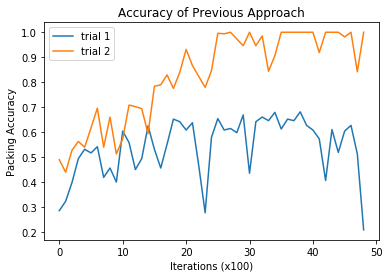

In [287]:
import matplotlib.pyplot as plt
plt.plot(accuracies, label="trial 1")
plt.plot(accuracies1, label="trial 2")
plt.ylabel("Packing Accuracy")
plt.xlabel("Iterations (x100)")
plt.legend()
plt.title("Accuracy of Previous Approach")
plt.show()

3
0.05
7
0.1
0
0.05
1
0.30625
16
-0.5
16
-0.5
16
-0.5
16
-1


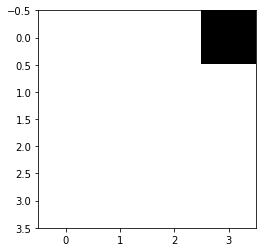

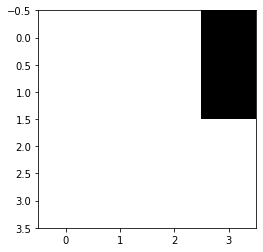

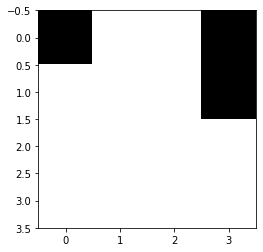

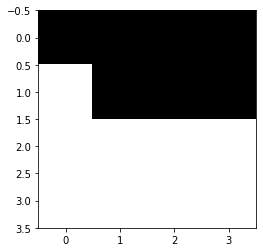

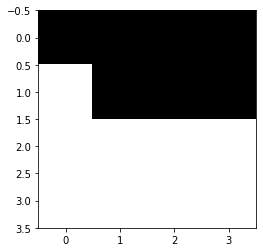

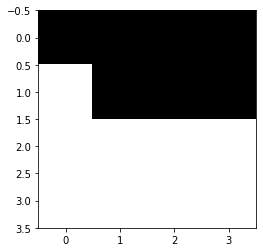

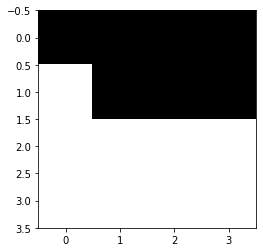

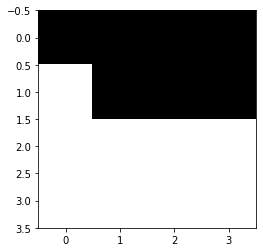

In [281]:
new_state = x.reset()
for i in range(8):
    action = y.trained_act(new_state)
    print(action)
    new_state, reward, done, _ = x.step(action)
    print(reward)
    x.render()

In [259]:
x = PackEnv2(board_shape=(4,4), input_shapes=[[[1]]]*4+[[[1,1],[1,1]]]*3, replacement=False, max_moves=8)

In [266]:
x.step(4)

hi


[array([[1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.]]), 1, True, {}]

In [235]:
y.epsilon

0.05

In [226]:
env = PackEnv2(board_shape=(3,3), input_shapes=[[[1]]]*5+[[[1,1],[1,1]]], replacement=False, max_moves=7)

(None, None)

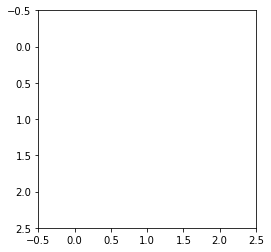

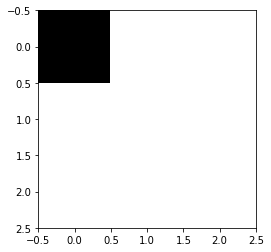

In [227]:
env.render(), env.render_piece()

In [228]:
env.step(0)

[array([[1., 0., 0., 1., 1., 0.],
        [0., 0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0.]]), 0.01, False, {}]

In [230]:
env.step(3)

[array([[1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]), 0.06, False, {}]

In [231]:
env.step(6)

[array([[1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]]), 0.05444444444444445, False, {}]

In [232]:
env.step(7)

[array([[1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.]]), 0.07111111111111111, False, {}]

In [233]:
env.step(8)

hi


[array([[1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.]]), 1, True, {}]

In [201]:
test_input = np.array([[0,0,1,0],[0,0,0,0]]).reshape(1,2,4,1)
move = np.array([[0,0,0,0,1]])

In [131]:
y.target_model.predict([test_input,move])[0][0]

0.0

In [118]:
y.target_model.weights[0]

<tf.Variable 'conv2d_43/kernel:0' shape=(5, 5, 1, 32) dtype=float32>

In [124]:
y.memory[0]

[array([[[[0.],
          [0.],
          [1.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          [0.]]]]), 1, 1.0, array([[[[0.],
          [1.],
          [1.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          [0.]]]]), False]

In [34]:
s = (1,) + (2,3) + (1,)

In [36]:
np.zeros(6).reshape((s))

array([[[[0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]]]])

In [39]:
actions = [[int(j == i) for j in range(10)] for i in range(10)]

In [40]:
actions

[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]

In [71]:
input1 = layers.Input(shape=(3,6,1))
input2 = layers.Input(shape=(10,))
conved1 = layers.Conv2D(32, (5, 5),padding="same",input_shape=(3,6,1), activation="relu")(input1)
conved2 = layers.Conv2D(32, (5, 5),padding="same",input_shape=(3,6,1), activation="relu")(conved1)
compressed = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conved2)
x = Flatten()(compressed)
processed = Dense(10, activation="relu")(x)

merged = keras.layers.Concatenate(axis=1)([processed, input2])
a = Dense(24, activation="relu")(merged)
b = Dense(48, activation="relu")(a)
#flat = Flatten()(b)
output = Dense(1, activation="relu")(b)
model = keras.models.Model(inputs=[input1, input2], output=output)
model.compile(loss="mean_squared_error",
    optimizer=Adam(lr=.01))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [77]:
a = np.random.random(1000*3*6).reshape(1000,3,6,1)
b = np.random.random(10*1000).reshape(1000,10)
c = np.random.random(1000*1).reshape(1000,1)
model.fit([a,b],c, batch_size=16)

Epoch 1/1
1000/1000 [==============================] - 0s 209us/step - loss: 0.0888


In [74]:
d = np.random.random(1000*3*6).reshape(1000,3,6,1)
e = np.random.random(10*1000).reshape(1000,10)

In [75]:
model.predict([d,e], batch_size=16)

array([[0.41907248],
       [0.553383  ],
       [0.5274732 ],
       [0.56514966],
       [0.49624303],
       [0.41020074],
       [0.42723143],
       [0.4783419 ],
       [0.35360003],
       [0.48780122],
       [0.40397915],
       [0.4470216 ],
       [0.40709642],
       [0.36991856],
       [0.41011515],
       [0.5174668 ],
       [0.37397134],
       [0.44182503],
       [0.41064706],
       [0.45077443],
       [0.44720724],
       [0.4862872 ],
       [0.4097422 ],
       [0.42443296],
       [0.4523773 ],
       [0.50396204],
       [0.53062546],
       [0.41105708],
       [0.39570263],
       [0.50219727],
       [0.51234424],
       [0.40777412],
       [0.4408375 ],
       [0.5052793 ],
       [0.4320315 ],
       [0.43318576],
       [0.39227495],
       [0.41818702],
       [0.4097167 ],
       [0.35940483],
       [0.45845672],
       [0.5457914 ],
       [0.4519718 ],
       [0.44552818],
       [0.406315  ],
       [0.44878253],
       [0.5142031 ],
       [0.436

In [269]:
class PrupeQN:
    def __init__(self, env):
        self.env     = env
        self.memory  = deque(maxlen=10000)
        
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.01
        self.tau = .08
        self.min_tau = .02
        self.tau_decay = .999

        self.model        = self.create_model()
        self.target_model = self.create_model()
        
        self.step = (1,1)
        self.subgrid_shape = (2,2)
    

    
    #some env methods copied
    
    def valid_move(self,state, target):
        h = self.env.board_shape[0]
        w = self.env.board_shape[1]
        state = (state[:,:w], state[:, w:])
        board = state[0]
        piece = state[1]
        

        #do nothing
        if target == h * w:
            return True

        if target > h*w or target < 0:
            return False

        h_offset = int(target / h)
        w_offset = target % w

        for H in range(len(piece)):
            for W in range(len(piece[0])):
                if piece[H][W] == 1:
                    if (h_offset + H >= h) or (w_offset + W  >= w):
                        return False
                    if board[H+h_offset][W+w_offset] == 1:
                        return False
        return True
    def merge(self, state, target):
        h = self.env.board_shape[0]
        w = self.env.board_shape[1]
        state = (state[:,:w], state[:, w:])
        board = state[0]
        piece = state[1]
        

        #do nothing
        if target == h * w:
            return state[0]

        h_offset = int(target / h)
        w_offset = target % w

        for H in range(len(piece)):
            for W in range(len(piece[0])):
                if piece[H][W] == 1:
                    #print("HIIIIIII")
                    board[H+h_offset][W+w_offset] = 1
        return board
    
    
    def grid_preprocess(self, board):
        return
    #input should be a binary array describing which action we are taking
    #along with the current state space which is made smaller by solving 
    #using subproblems and then put through several convolutional layers
    #then this is put through several fully connected layers and finally
    #output through a single node
    def create_model(self):
        h, w = self.env.board_shape
        h_step, w_step = self.step
        h_len, w_len = self.subgrid_shape
        updated_shape = 
        
        input_shape = self.env.observation_space.shape + (1,)
        vals_shape = (self.env.num_possible_moves+1,)
        
        input1 = layers.Input(shape=input_shape)
        input2 = layers.Input(shape=vals_shape)
        conved1 = layers.Conv2D(32, (5, 5),padding="same",input_shape=input_shape, activation="relu")(input1)
        conved2 = layers.Conv2D(32, (5, 5),padding="same",input_shape=input_shape, activation="relu")(conved1)
        compressed = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conved2)
        x = Flatten()(compressed)
        processed = Dense(10, activation="relu")(x)

        merged = keras.layers.Concatenate(axis=1)([processed, input2])
        a = Dense(24, activation="relu")(merged)
        b = Dense(48, activation="relu")(a)
        output = Dense(1, activation="linear")(b)
        model = keras.models.Model(inputs=[input1, input2], output=output)
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=.01))
        print(model.summary())
        return model

    
    #eventually replaced with network on previous values TODO
    def subgrid_val(self, subgrid):
        #illegal move
        if np.max(subgrid) == 2:
            return -1
        elif np.sum(subgrid) == 0:
            return 0
        elif np.sum(subgrid) == 1:
            return .2
        elif subgrid[0][0] == subgrid[1][1] and np.sum(subgrid) == 2:
            return -.5
        elif subgrid[0][0] != subgrid[1][1] and np.sum(subgrid) == 2:
            return .4
        elif np.sum(subgrid) == 3:
            return .5
        elif np.sum(subgrid) == 4:
            return 1
        return 0
    
    def preprocess(self, state, action):
        h, w = self.env.board_shape
        h_step, w_step = self.step
        h_len, w_len = self.subgrid_shape
        if not self.valid_move(state, action):
            vals = -np.ones(int((h-h_width)/h_step), int((w-w_width)/w_step))
            return vals
        potential_board = np.array(self.merge(state, action))
        
        vals = []
        for i in range(0, h-h_len+1, h_step):
            for j in range(0, w-w_len+1, w_step):
                subgrid = potential_board[i:i+h_step, j:j+w_step]
                vals.append(self.subgrid_val(subgrid))
        
        vals = np.array(vals)
        vals = vals.reshape(int((h-h_width)/h_step), int((w-w_width)/w_step), order='F')
        return vals

    
    def max_q(self, state):
        new_shape = (1,) + self.env.observation_space.shape + (1,)
        input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))
        #PREPREOCESS INPUT STATES
        q_vals = self.target_model.predict([input_states, actions])
        return max(q_vals)
        
    
    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        
        new_shape = (1,) + self.env.observation_space.shape + (1,)
        input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))
        
        #PREPROCESS INPUT STATES
        predictions = self.model.predict([input_states, actions])
        for i in range(len(predictions)):
            if not self.env.valid_move(i):
                pass
        return np.argmax(predictions)
    
    def trained_act(self, state):
        new_shape = (1,) + self.env.observation_space.shape + (1,)
        input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))


        
        #PREPROECESS STATES
        predictions = self.model.predict([input_states, actions])
        for i in range(len(predictions)):
            if not self.env.valid_move(i):
                #predictions[i] -= 10
                pass
        #print(list(predictions))
        return np.argmax(predictions)

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size = 32
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        states = []
        outputs = []
        actions = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            
            output_prime = 0
            if done:
                output_prime = reward
            else:
                Q_future = self.max_q(new_state)
                output_prime = reward + Q_future * self.gamma
            print("reward is", reward, "output_prime is", output_prime)
            outputs.append(output_prime)
            states.extend(state)
            actions.append([int(j == action) for j in range(self.env.num_possible_moves+1)])
        states = np.array(states)
        outputs = np.array(outputs)
        actions = np.array(actions)
        
        #PREPROCESS STATES
        self.model.fit([states,actions], outputs, epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        self.tau = max(self.min_tau, self.tau*self.tau_decay)
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save(fn)



In [270]:
env.observation_space.shape

(3, 6)

In [ ]:
class PrupeQN:
    def __init__(self, env):
        self.env     = env
        self.memory  = deque(maxlen=10000)
        
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        self.learning_rate = 0.01
        self.tau = .08
        self.min_tau = .02
        self.tau_decay = .999

        self.model        = self.create_model()
        self.target_model = self.create_model()
    
    #def subgrid_q()
    
    
    def grid_preprocess(self, board):
        return
    #input should be a binary array describing which action we are taking
    #along with the current state space which is made smaller by solving 
    #using subproblems and then put through several convolutional layers
    #then this is put through several fully connected layers and finally
    #output through a single node
    def create_model(self):
        input_shape = self.env.observation_space.shape + (1,)
        vals_shape = (self.env.num_possible_moves+1,)
        
        input1 = layers.Input(shape=input_shape)
        input2 = layers.Input(shape=vals_shape)
        conved1 = layers.Conv2D(32, (5, 5),padding="same",input_shape=input_shape, activation="relu")(input1)
        conved2 = layers.Conv2D(32, (5, 5),padding="same",input_shape=input_shape, activation="relu")(conved1)
        compressed = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same')(conved2)
        x = Flatten()(compressed)
        processed = Dense(self.env.num_possible_moves+1, activation="relu")(x)

        merged = keras.layers.Concatenate(axis=1)([processed, input2])
        a = Dense(24, activation="relu")(merged)
        b = Dense(48, activation="relu")(a)
        #flat = Flatten()(b)
        output = Dense(1, activation="linear")(b)
        model = keras.models.Model(inputs=[input1, input2], output=output)
        model.compile(loss="mean_squared_error",
            optimizer=Adam(lr=.01))
        print(model.summary())
        #print(model.input_shape)
        return model

    def max_q(self, state):
        new_shape = (1,) + self.env.observation_space.shape + (1,)
        input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))
        q_vals = self.target_model.predict([input_states, actions])
        return max(q_vals)
        
    
    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        
        
        new_shape = (1,) + self.env.observation_space.shape + (1,)
        input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))
        
        #print("input states!", input_states, input_states.shape)
        #print("Actions!", actions, actions.shape)
        
        predictions = self.model.predict([input_states, actions])
        for i in range(len(predictions)):
            if not self.env.valid_move(i):
                #predictions[i] -= 10
                pass
        #print("predictions", (predictions))
        return np.argmax(predictions)
    
    def trained_act(self, state):
        new_shape = (1,) + self.env.observation_space.shape + (1,)
        input_state = state.reshape(new_shape)
        actions = np.array([[int(j == i) for j in range(self.env.num_possible_moves+1)] for i in range(self.env.num_possible_moves+1)])
        input_states = np.array(list(input_state)*(self.env.num_possible_moves+1))


        
        
        predictions = self.model.predict([input_states, actions])
        for i in range(len(predictions)):
            if not self.env.valid_move(i):
                #predictions[i] -= 10
                pass
        #print(list(predictions))
        return np.argmax(predictions)

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        batch_size = 32
        if len(self.memory) < batch_size: 
            return

        samples = random.sample(self.memory, batch_size)
        states = []
        outputs = []
        actions = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            
            output_prime = 0
            if done:
                output_prime = reward
            else:
                Q_future = self.max_q(new_state)
                output_prime = reward + Q_future * self.gamma
            #print("reward is", reward, "output_prime is", output_prime)
            outputs.append(output_prime)
            states.extend(state)
            actions.append([int(j == action) for j in range(self.env.num_possible_moves+1)])
        print("reward is", reward, "output_prime is", output_prime)
        states = np.array(states)
        outputs = np.array(outputs)
        actions = np.array(actions)
        self.model.fit([states,actions], outputs, epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        self.tau = max(self.min_tau, self.tau*self.tau_decay)
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save_model(self, fn):
        self.model.save(fn)

def main():
    max_moves = 8
    #env = PackEnv2(board_shape=(2,2), input_shapes=[[[1]]]*2+[[[1,1],[0,0]]], replacement=False, max_moves=4)
    env = PackEnv2(board_shape=(4,4), input_shapes=[[[1]]]*4+[[[1,1],[1,1]]]*3, replacement=False, max_moves=max_moves)
    gamma   = 0.95
    epsilon = .99

    trials  = 5000
    trial_len = 50

    # updateTargetNetwork = 1000
    dqn_agent = PrupeQN(env=env)
    accuracies = []
    for trial in range(trials):
        cur_state = env.reset()
        state_shape = (1,) + env.observation_space.shape + (1,)
        cur_state = cur_state.reshape(state_shape)
        for step in range(trial_len):
            action = dqn_agent.act(cur_state)
            new_state, reward, done, _ = env.step(action)
            #print("info", new_state, reward, done)

            #reward = reward/abs(reward) if not done else -.01
            #reward = -.01 if not done else reward/abs(reward)
            #print("reward is ")
            new_state = new_state.reshape(state_shape)
            dqn_agent.remember(cur_state, action, reward, new_state, done)
            
            dqn_agent.replay()       # internally iterates default (prediction) model
            dqn_agent.target_train() # iterates target model

            cur_state = new_state
            if done:
                break
                
        if (trial % 100) == 0 and trial !=0:
            total_accuracy = 0
            for i in range(30):
                accuracy = 0
                new_state = env.reset()
                for j in range(max_moves):
                    action = dqn_agent.trained_act(new_state)
                    new_state, reward, done, _ = env.step(action)
                    board_width = env.board_shape[1]
                accuracy = np.sum(new_state[:,:board_width])/env.num_possible_moves
                print("sub accuracy is", accuracy)

                total_accuracy += accuracy/30
            accuracies.append(total_accuracy)
            print("accuracy is ", total_accuracy)
        print("trial #{}".format(trial))
    return env, dqn_agent, accuracies